In [2]:
import pandas as pd 
#import pandas_datareader as web 
import datetime

import matplotlib.pyplot as plt
#plt.style.use("seaborn-whitegrid")
import matplotlib.dates as mdates
import seaborn as sns
from pandas import to_datetime
from prophet import Prophet

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

#relax the display limits on columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [3]:
test_years = [4,3,2]

## Define a function to plot model results

In [4]:
def plot_results(test_years, model_name, y_pred1, y_pred2):   
    fig, axs = plt.subplots(2, sharex=False, sharey=True, figsize=(16,16), gridspec_kw={'height_ratios': [1, 1]})#define figure size and shape
    axs[0].plot(training_data1, color = "black", label = 'Training Set (Claims Data)') #plot death claims training data
    axs[0].plot(testing_data_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')#plot testing excluding covid claims
    axs[0].set_ylabel('Seasonal Variation',fontsize = 20)#define x label
    axs[0].set_xlabel('Year',fontsize = 20)#define y label
    axs[0].xaxis.set_major_locator(mdates.YearLocator(base=1))#format x-axis in years
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))#format y-axis in years
    axs[0].plot(y_pred1, color='Blue', linestyle = 'dotted', label = f'{model_name} Predictions (Claims Data)')#plot model predictions on model trained with death claims data
    axs[0].legend(fontsize = 12)#format legend
    axs[1].plot(training_data2, color = "black", label = 'Training Set (Population Data)')#plot population deaths training data
    axs[1].plot(testing_data_excovid, color = "red",label = 'Testing Set (Claims Data excluding Covid claims)')#plot testing data excluding covid claims
    axs[1].set_ylabel('Seasonal Variation',fontsize = 20)#define x label
    axs[1].set_xlabel('Year',fontsize = 20)#define y label
    axs[1].xaxis.set_major_locator(mdates.YearLocator(base=1))#format x-axis in years
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))#format y-axis in years
    axs[1].plot(y_pred2, color='Blue', linestyle = 'dashed', label = f'{model_name} Predictions (Population Data)')#plot model predictions on model trained with population deaths data
    axs[1].legend(fontsize = 12)#format legend
    fig.savefig(f'{model_name} Predictions - {17-i} Year Training Period, {i} Year Test Period.png')#save chart

## Import and Format Data

In [5]:
df1 = pd.read_csv('Death Claim Seasonality.csv')#read death claims input data

In [6]:
df1['Q'] = (df1['NOTIFICATION QUARTER'].astype(str)).str[-2:]#extract calendar year quarter from year

In [7]:
df1['Q_num'] = (df1['Q'].astype(str)).str[-1:]#extract number from Quarter

In [8]:
df1['NOTIFICATION QUARTER'] = pd.to_datetime(df1['NOTIFICATION QUARTER'])#format NOTIFICATION QUARTER as datetime

In [9]:
df1 = df1.set_index('NOTIFICATION QUARTER')#set NOTIFICATION QUARTER as the dataframe index

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2005-01-01 to 2021-10-01
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CLAIMS SEASONAL VARIATION  68 non-null     float64
 1   Q                          68 non-null     object 
 2   Q_num                      68 non-null     object 
dtypes: float64(1), object(2)
memory usage: 2.1+ KB


In [11]:
df1.head()#inspect data

CLAIMS SEASONAL VARIATION   Q Q_num
NOTIFICATION QUARTER                                     
2005-01-01                            -0.097826  Q1     1
2005-04-01                             0.010870  Q2     2
2005-07-01                             0.119565  Q3     3
2005-10-01                            -0.032609  Q4     4
2006-01-01                             0.014706  Q1     1

In [12]:
df2 = pd.read_csv('CSO Deaths Seasonality.csv')#read population deaths input data

In [13]:
df2['Q'] = (df2['Quarter'].astype(str)).str[-2:]#extract calendar year quarter from year
df2['Q_num'] = (df2['Q'].astype(str)).str[-1:]#extract number from Quarter

In [14]:
df2['Quarter'] = pd.to_datetime(df2['Quarter'])#format Quarter as datetime
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Quarter                 68 non-null     datetime64[ns]
 1   CSO SEASONAL VARIATION  68 non-null     float64       
 2   Q                       68 non-null     object        
 3   Q_num                   68 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.2+ KB


In [15]:
df2.head()#inspect data

Quarter  CSO SEASONAL VARIATION   Q Q_num
0 2005-01-01                0.002010  Q1     1
1 2005-04-01                0.014504  Q2     2
2 2005-07-01               -0.006223  Q3     3
3 2005-10-01               -0.010291  Q4     4
4 2006-01-01               -0.002905  Q1     1

In [16]:
df2 = df2.set_index('Quarter') #set Quarter as the dataframe index

In [17]:
df3 = pd.read_csv('Death Claim Seasonality - ex Covid Claims.csv') #read death claims input data excluding covid claims

df3['NOTIFICATION QUARTER'] = pd.to_datetime(df3['NOTIFICATION QUARTER'])#format NOTIFCIATION QUARTER as datetime


df3 = df3.rename(columns= {'CLAIMS SEASONAL VARIATION': 'CLAIMS SEASONAL VARIATION EX COVID'})#rename seasonal variation column to show that it excludes covid claims
df3 = df3.set_index('NOTIFICATION QUARTER')#set the dataframe index to NOTIFICATION QUARTER



### Plot Death Claims Data and Population Deaths Data

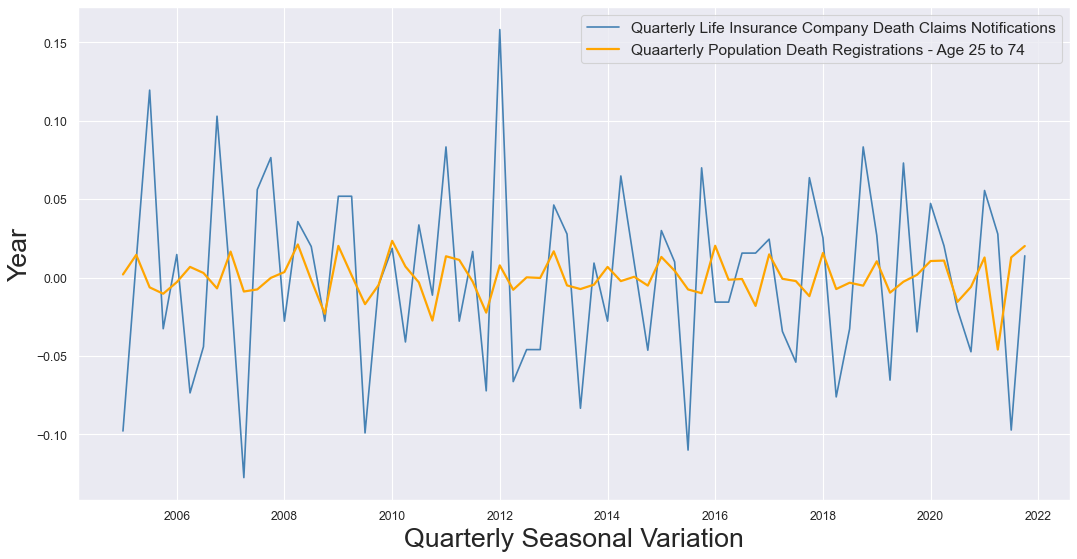

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80) #define chart size and shape
plt.plot(df1['CLAIMS SEASONAL VARIATION'], color = "steelblue", label = 'Quarterly Life Insurance Company Death Claims Notifications')#plot death claims data
plt.plot(df2['CSO SEASONAL VARIATION'], color = "orange",linewidth =2.0, label = 'Quaarterly Population Death Registrations - Age 25 to 74')#plot population deaths data
plt.xlabel('Quarterly Seasonal Variation',fontsize = 24)#define xlabel
plt.ylabel('Year',fontsize = 24)#define y label
plt.legend(fontsize = 14)#format legend
plt.show()#display chart

### Define Training and Testing Datasets

In [19]:
training_data1_4y = df1[:-16]#set death claims training data equal to the death claims input data less the last 16 quarters (4 years)
training_data1_4y = pd.DataFrame(training_data1_4y, columns = ['CLAIMS SEASONAL VARIATION'])#format as dataframe
training_data1_3y = df1[:-12]#set death claims training data equal to the death claims input data less the last 12 quarters (3 years)
training_data1_3y = pd.DataFrame(training_data1_3y, columns = ['CLAIMS SEASONAL VARIATION'])#format as dataframe
training_data1_2y = df1[:-8]#set death claims training data equal to the death claims input data less the last 8 quarters (2 years)
training_data1_2y = pd.DataFrame(training_data1_2y, columns = ['CLAIMS SEASONAL VARIATION'])#format as dataframe

training_data2_4y = df2[:-16]#set population deaths training data equal to the population deaths input data less the last 16 quarters (4 years)
training_data2_4y = pd.DataFrame(training_data2_4y, columns = ['CSO SEASONAL VARIATION'])#format as dataframe
training_data2_3y = df2[:-12]#set population deaths training data equal to the population deaths input data less the last 12 quarters (3 years)
training_data2_3y = pd.DataFrame(training_data2_3y, columns = ['CSO SEASONAL VARIATION'])#format as dataframe
training_data2_2y = df2[:-8]#set population deaths training data equal to the population deaths input data less the last 8 quarters (2 years)
training_data2_2y = pd.DataFrame(training_data2_2y, columns = ['CSO SEASONAL VARIATION'])#format as dataframe

testing_data4y = df1[-16:len(df1)] #Set testing data equal to the last 16 quarters of the death claims data
testing_data4y = pd.DataFrame(testing_data4y,columns=['CLAIMS SEASONAL VARIATION'])#format as dataframe
testing_data3y = df1[-12:len(df1)] #Set testing data equal to the last 12 quarters of the death claims data
testing_data3y = pd.DataFrame(testing_data3y,columns=['CLAIMS SEASONAL VARIATION'])#format as dataframe
testing_data2y = df1[-8:len(df1)] #Set testing data equal to the last 8 quarters of the death claims data 
testing_data2y = pd.DataFrame(testing_data2y,columns=['CLAIMS SEASONAL VARIATION'])#format as dataframe

testing_data4y_excovid = df3[-16:len(df3)] #Set testing data equal to the last 16 quarters of the death claims data ex covid
testing_data4y_excovid = pd.DataFrame(testing_data4y_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])#format as dataframe
testing_data3y_excovid = df3[-12:len(df3)] #Set testing data equal to the last 12 quarters of the death claims data ex covid
testing_data3y_excovid = pd.DataFrame(testing_data3y_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])#format as dataframe
testing_data2y_excovid = df3[-8:len(df3)] #Set testing data equal to the last 8 quarters of the death claims data ex covid
testing_data2y_excovid = pd.DataFrame(testing_data2y_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])#format as dataframe

## Baseline Model

### Define Baseline Model

In [20]:
BL = pd.DataFrame() #define new empty dataframe called BL
BL['NOTIFICATION QUARTER']= testing_data4y.index #add a column called NOTIFICATION QUARTER which is equal to the index column in the 4 year testing data
BL['Seasonal Variation'] = df1['CLAIMS SEASONAL VARIATION']#define a column called 'Seasonal Variation' and set it equal to the Death Claims data Seasonal Variation column
BL['Seasonal Variation'].values[:] = 0 #reset Seasonal Variation column to zeros
BL = BL.set_index('NOTIFICATION QUARTER')#set NOTIFICATION QUARTER as the index column


In [21]:
BL_4y = BL[-16:len(BL)]#set the 4 year Baseline Model equal to the last 16 quarters of the Baseline dataframe
BL_3y = BL[-12:len(BL)]#set the 3 year Baseline Model equal to the last 12 quarters of the Baseline dataframe
BL_2y = BL[-8:len(BL)]#set the 3 year Baseline Model equal to the last 8 quarters of the Baseline dataframe

### Plot the Baseline Model results

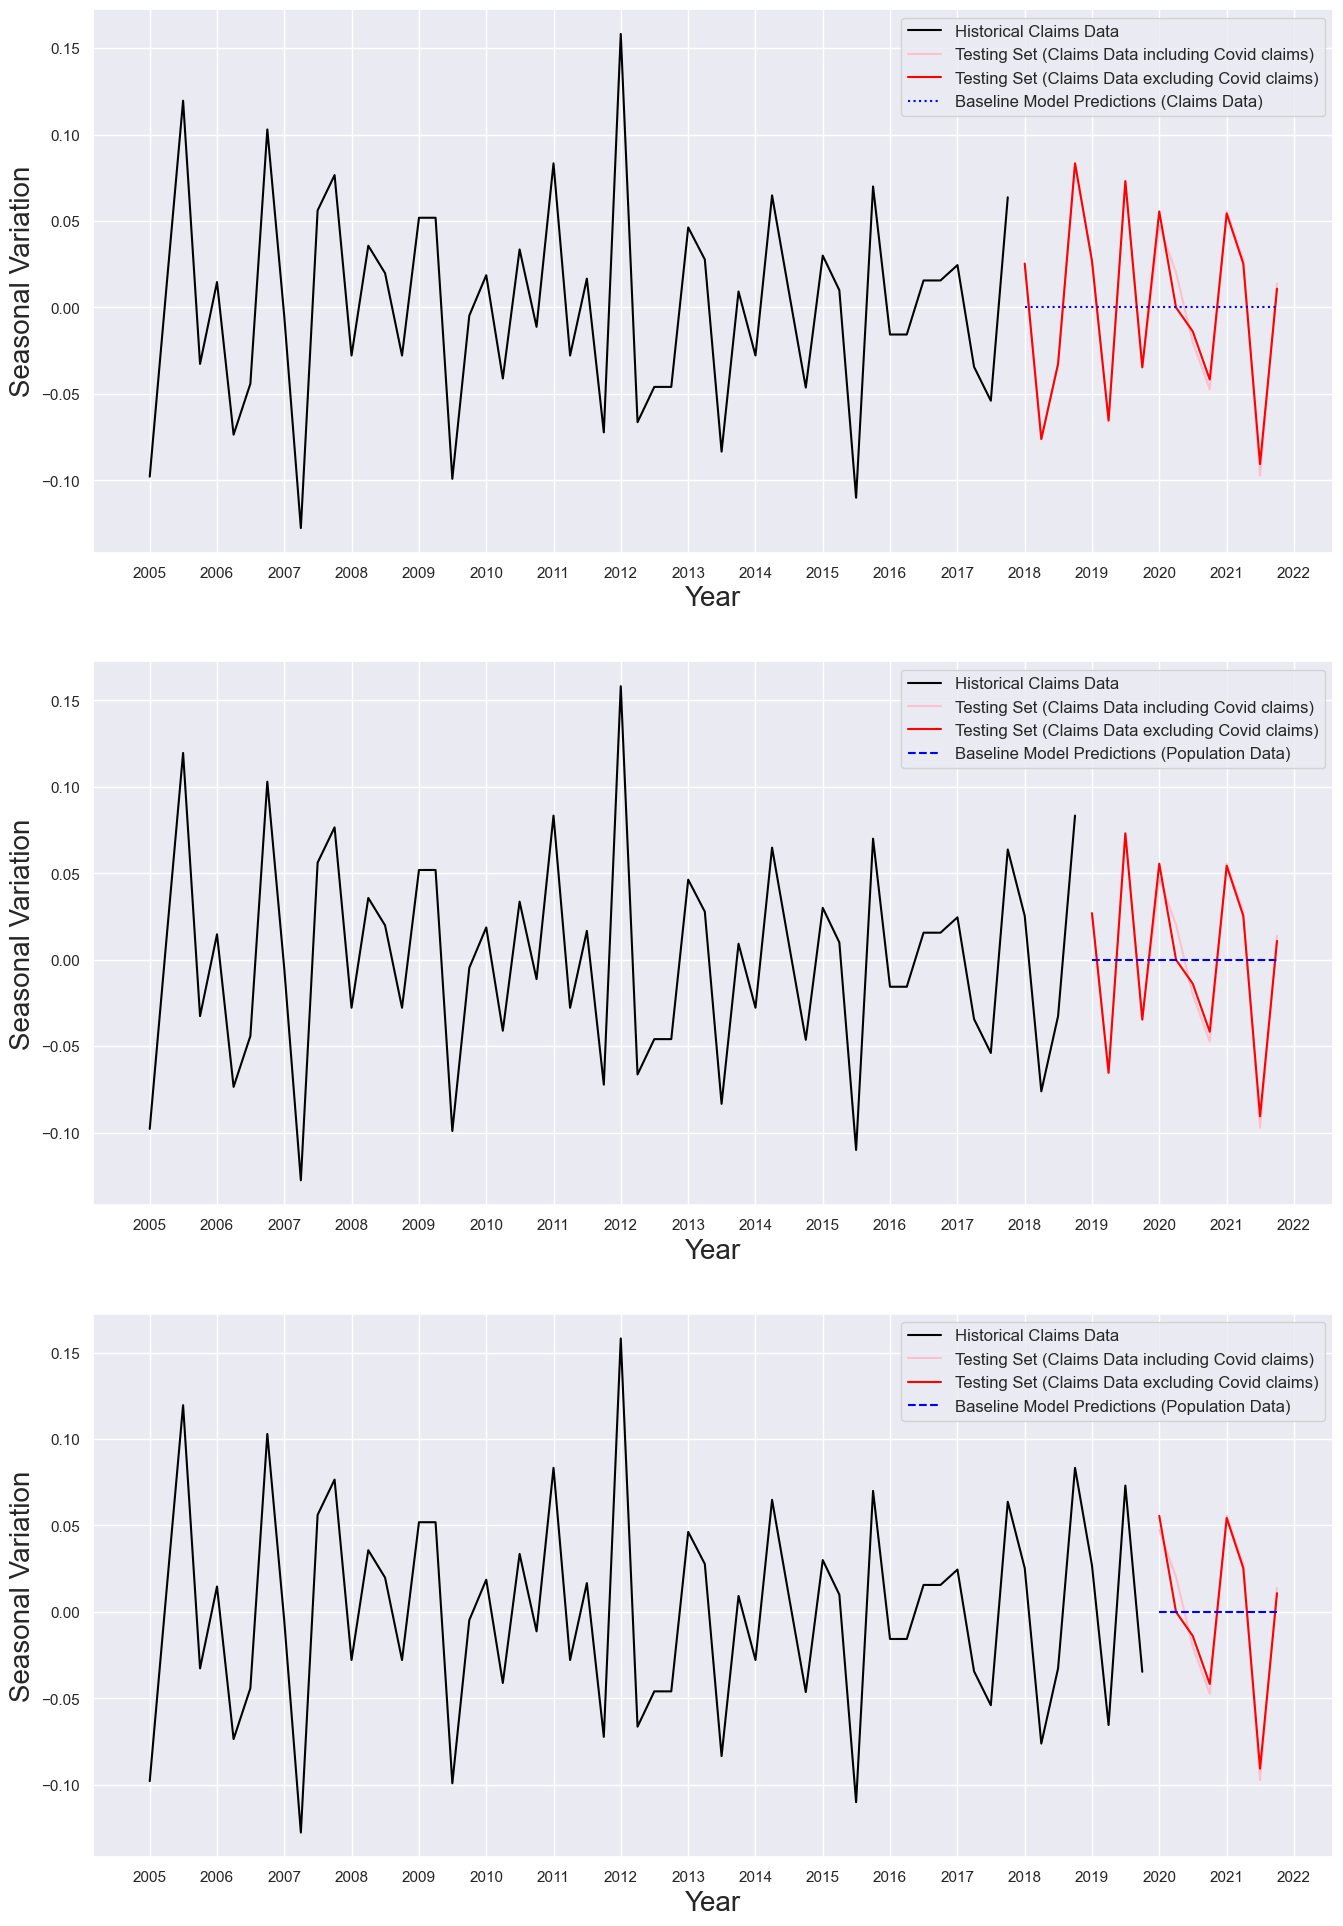

In [22]:
#see plot_results function for relevant comments

fig, axs = plt.subplots(3, sharex=False,sharey=True, figsize=(16,24), gridspec_kw={'height_ratios': [1,1,1]})
axs[0].plot(training_data1_4y, color = "black", label = 'Historical Claims Data')
axs[0].plot(testing_data4y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[0].plot(testing_data4y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[0].set_ylabel('Seasonal Variation',fontsize = 20)
axs[0].set_xlabel('Year',fontsize = 20)
axs[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].plot(BL_4y, color='Blue', linestyle = 'dotted', label = 'Baseline Model Predictions (Claims Data)')
axs[0].legend(fontsize = 12)
axs[1].plot(training_data1_3y, color = "black", label = 'Historical Claims Data')
axs[1].plot(testing_data3y, color = "pink",label = 'Testing Set (Claims Data including Covid claims)')
axs[1].plot(testing_data3y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[1].set_ylabel('Seasonal Variation',fontsize = 20)
axs[1].set_xlabel('Year',fontsize = 20)
axs[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1].plot(BL_3y, color='Blue', linestyle = 'dashed', label = 'Baseline Model Predictions (Population Data)')
axs[1].legend(fontsize = 12)
axs[2].plot(training_data1_2y, color = "black", label = 'Historical Claims Data')
axs[2].plot(testing_data2y, color = "pink",label = 'Testing Set (Claims Data including Covid claims)')
axs[2].plot(testing_data2y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[2].set_ylabel('Seasonal Variation',fontsize = 20)
axs[2].set_xlabel('Year',fontsize = 20)
axs[2].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[2].plot(BL_2y, color='Blue', linestyle = 'dashed', label = 'Baseline Model Predictions (Population Data)')
axs[2].legend(fontsize = 12)
fig.savefig('Baseline Model Death Claim Seasonality Predictions.png')


BL_mae_2y = mean_absolute_error(testing_data2y.values, BL_2y)
BL_rmse_2y = np.sqrt(mean_squared_error(testing_data2y.values, BL_2y))
BL_r2_2y = r2_score(testing_data2y.values, BL_2y)

BL_mae_3y = mean_absolute_error(testing_data3y.values, BL_3y)
BL_rmse_3y = np.sqrt(mean_squared_error(testing_data3y.values, BL_3y))
BL_r2_3y = r2_score(testing_data3y.values, BL_3y)

BL_mae_4y = mean_absolute_error(testing_data4y.values, BL_4y)
BL_rmse_4y = np.sqrt(mean_squared_error(testing_data4y.values, BL_4y))
BL_r2_4y = r2_score(testing_data4y.values, BL_4y)

BL_mae_2y_excovid = mean_absolute_error(testing_data2y_excovid.values, BL_2y)
BL_rmse_2y_excovid = np.sqrt(mean_squared_error(testing_data2y_excovid.values, BL_2y))
BL_r2_2y_excovid = r2_score(testing_data2y_excovid.values, BL_2y)

BL_mae_3y_excovid = mean_absolute_error(testing_data3y_excovid.values, BL_3y)
BL_rmse_3y_excovid = np.sqrt(mean_squared_error(testing_data3y_excovid.values, BL_3y))
BL_r2_3y_excovid = r2_score(testing_data3y_excovid.values, BL_3y)

BL_mae_4y_excovid = mean_absolute_error(testing_data4y_excovid.values, BL_4y)
BL_rmse_4y_excovid = np.sqrt(mean_squared_error(testing_data4y_excovid.values, BL_4y))
BL_r2_4y_excovid = r2_score(testing_data4y_excovid.values, BL_4y)



## Historical Average Models

### Define Historical Average Death Claims Model

In [23]:
ha_claims_2y = df1[:-8]
ha_claims_2y = (ha_claims_2y.groupby('Q')['CLAIMS SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CLAIMS SEASONAL VARIATION': 'Claim Predictions'})
ha_claims_2y= ha_claims_2y.reset_index()
ha_claims_2y['Claim Predictions'].round(2).sum()

0.0

In [24]:
ha_claims_3y = df1[:-12]
ha_claims_3y = (ha_claims_3y.groupby('Q')['CLAIMS SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CLAIMS SEASONAL VARIATION': 'Claim Predictions'})
ha_claims_3y= ha_claims_3y.reset_index()
ha_claims_3y['Claim Predictions'].round(2).sum()

0.0

In [25]:
ha_claims_4y = df1[:-16]
ha_claims_4y = (ha_claims_4y.groupby('Q')['CLAIMS SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CLAIMS SEASONAL VARIATION': 'Claim Predictions'})
ha_claims_4y= ha_claims_4y.reset_index()
ha_claims_4y['Claim Predictions'].round(2).sum()

0.01

### Define Historical Average Population Deaths Model

In [26]:
ha_pop_2y = df2[:-8]
ha_pop_2y = (ha_pop_2y.groupby('Q')['CSO SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CSO SEASONAL VARIATION': 'Pop Predictions'})
ha_pop_2y= ha_pop_2y.reset_index()
ha_pop_2y

Q  Pop Predictions
0  Q1         0.012151
1  Q2         0.001584
2  Q3        -0.003873
3  Q4        -0.009861

In [27]:
ha_pop_3y = df2[:-12]
ha_pop_3y = (ha_pop_3y.groupby('Q')['CSO SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CSO SEASONAL VARIATION': 'Pop Predictions'})
ha_pop_3y= ha_pop_3y.reset_index()
ha_pop_3y

Q  Pop Predictions
0  Q1         0.012275
1  Q2         0.002382
2  Q3        -0.003963
3  Q4        -0.010694

In [28]:
ha_pop_4y = df2[:-16]
ha_pop_4y = (ha_pop_4y.groupby('Q')['CSO SEASONAL VARIATION'].mean().to_frame()).rename(columns={'CSO SEASONAL VARIATION': 'Pop Predictions'})
ha_pop_4y= ha_pop_4y.reset_index()
ha_pop_4y

Q  Pop Predictions
0  Q1         0.012011
1  Q2         0.003127
2  Q3        -0.004017
3  Q4        -0.011121

### Define Historical Average Model Predictions

In [29]:
predictions2y = df1[-8:len(df1)]#Set testing data equal to entire dataset less the last 8 quarters
predictions2y = predictions2y[['Q']]
predictions2y = pd.merge(
    left=predictions2y,
    right=ha_claims_2y,   
    how='left'
)
predictions2y = pd.merge(
    left=predictions2y,
    right=ha_pop_2y,   
    how='left'
)


 
predictions3y = df1[-12:len(df1)] #Set testing data equal to entire dataset less the last 12 quarters
predictions3y = predictions3y[['Q']]
predictions3y = pd.merge(
    left=predictions3y,
    right=ha_claims_3y,   
    how='left'
)
predictions3y = pd.merge(
    left=predictions3y,
    right=ha_pop_3y,   
    how='left'
)



predictions4y = df1[-16:len(df1)] #Set testing data equal to entire dataset less the last 16 quarters
predictions4y = predictions4y[['Q']]
predictions4y = pd.merge(
    left=predictions4y,
    right=ha_claims_4y,   
    how='left'
)
predictions4y = pd.merge(
    left=predictions4y,
    right=ha_pop_4y,   
    how='left'
)

predictions4y.index = testing_data4y.index
predictions3y.index = testing_data3y.index
predictions2y.index = testing_data2y.index

In [31]:
df1_SV = df1[['CLAIMS SEASONAL VARIATION']]
df2_SV = df2[['CSO SEASONAL VARIATION']]
df3_SV = df3[['CLAIMS SEASONAL VARIATION EX COVID']]

### Plot Model Results for each Training/Testing Period

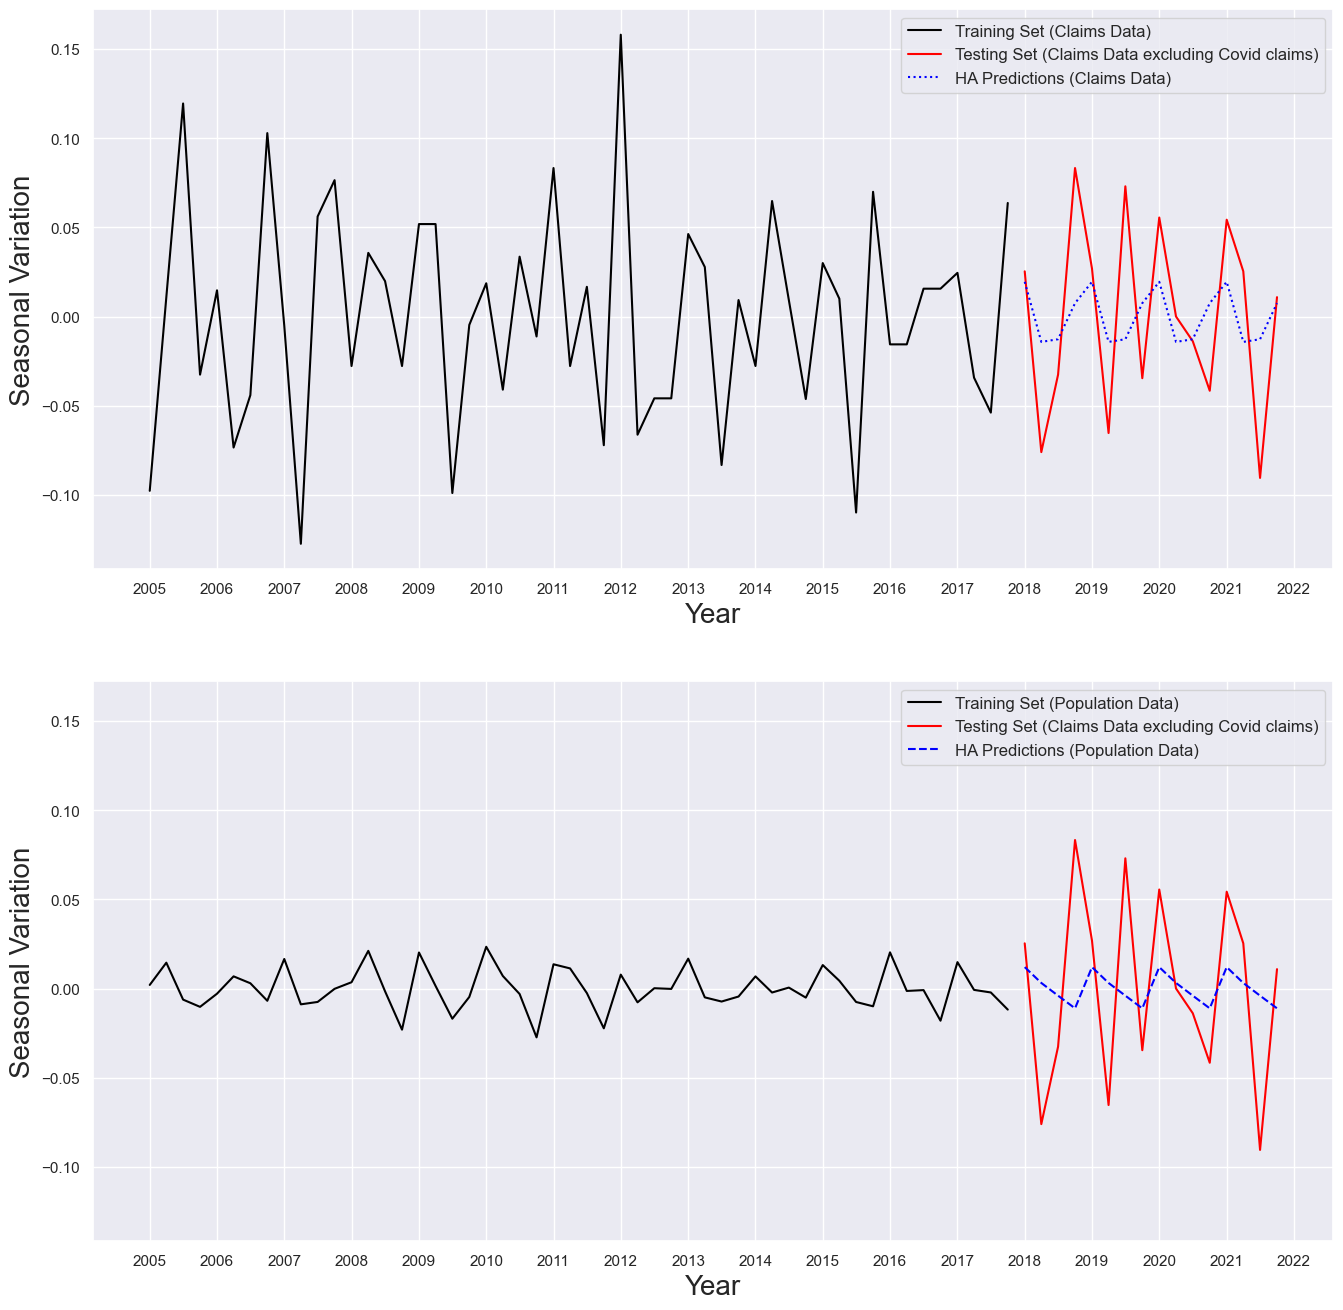

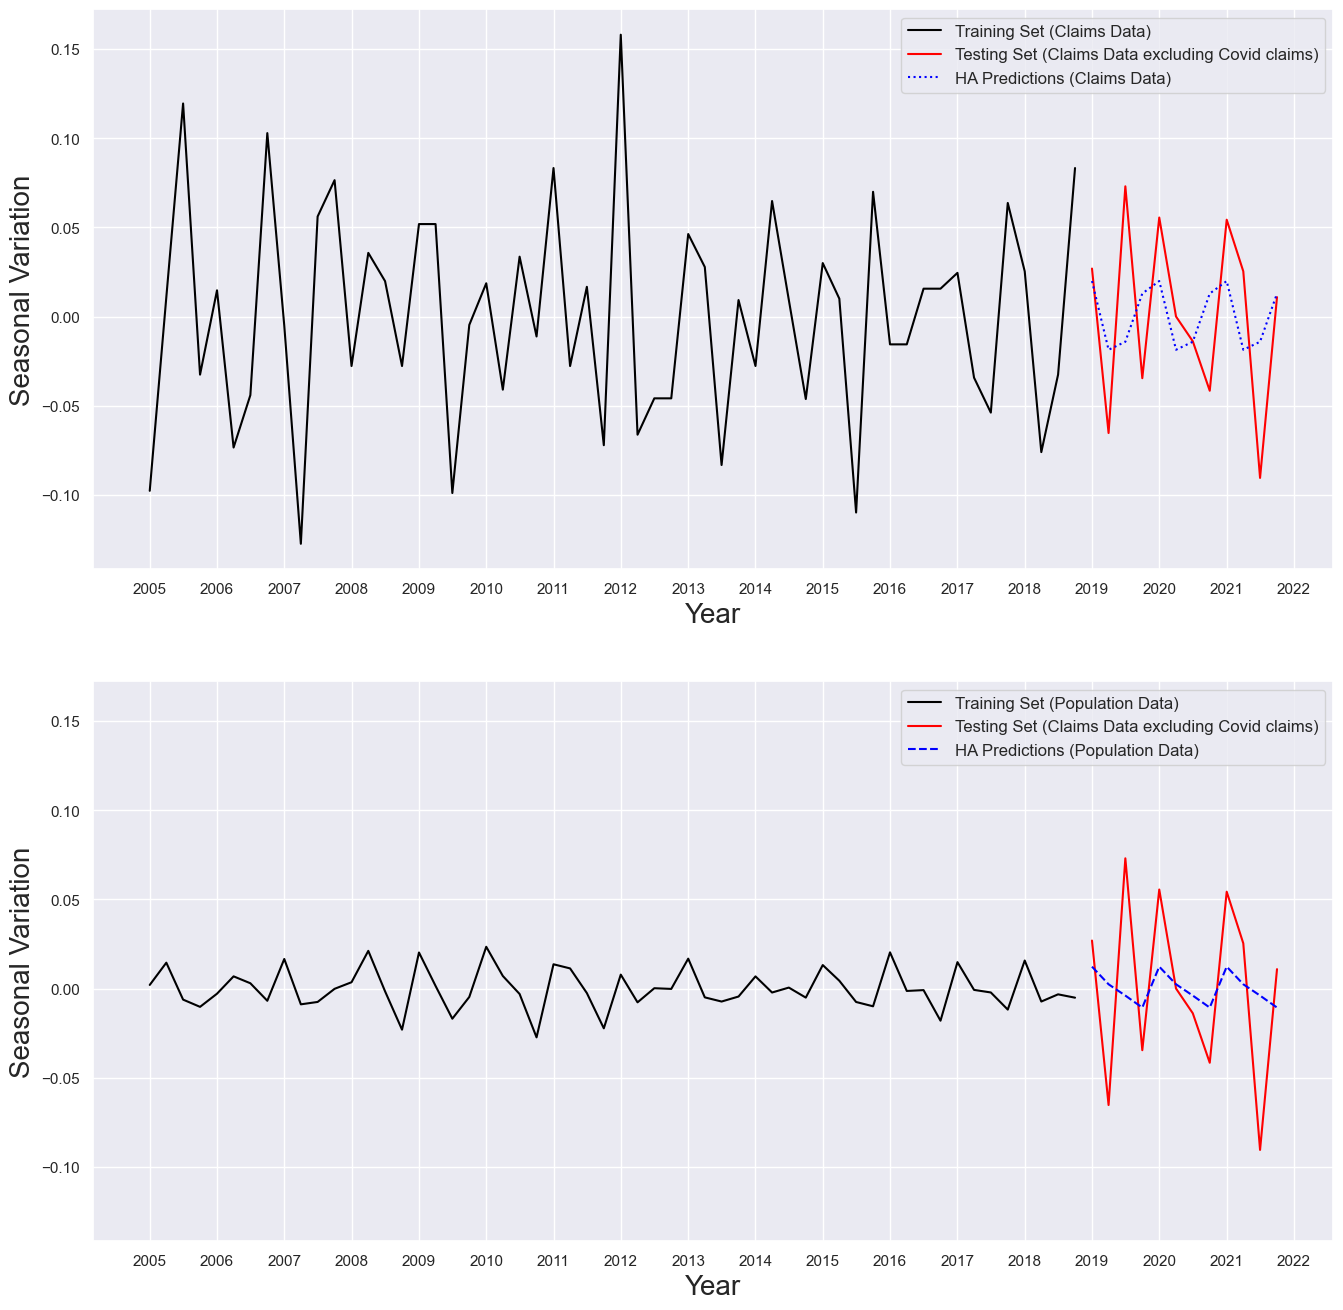

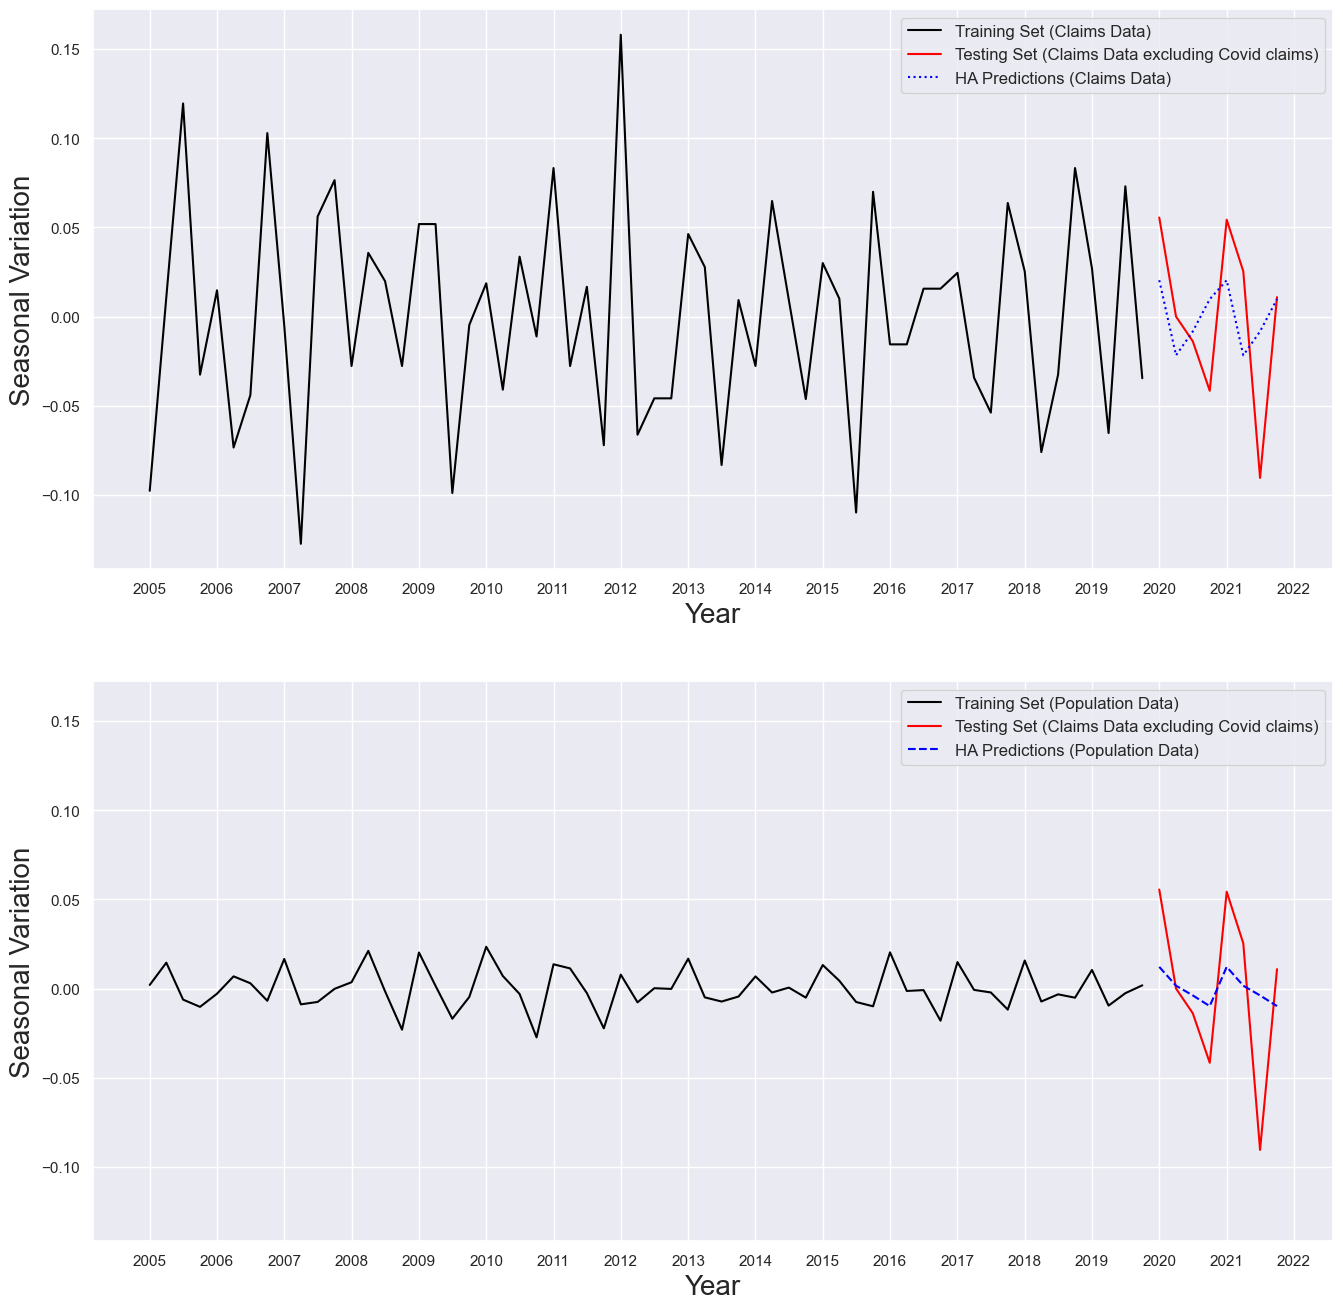

In [33]:
model_name = "HA"

for i in test_years:
    exec(f'y_pred1 = pd.DataFrame(predictions{i}y.iloc[:,1])')
    y_pred1 = y_pred1.rename(columns = {"Claim Predictions":"Predictions"})
    exec(f'y_pred2 = pd.DataFrame(predictions{i}y.iloc[:,2])')
    y_pred2 = y_pred2.rename(columns = {"Pop Predictions":"Predictions"})
    
    training_data1 = df1_SV[:-i*4]
    training_data1 = pd.DataFrame(training_data1, columns = ['CLAIMS SEASONAL VARIATION'])
    training_data1 = training_data1.rename(columns = {'CLAIMS SEASONAL VARIATION':'Seasonal Variation'})
    training_data2 = df2_SV[:-i*4]
    training_data2 = pd.DataFrame(training_data2, columns = ['CSO SEASONAL VARIATION'])
    training_data2 = training_data2.rename(columns = {'CSO SEASONAL VARIATION':'Seasonal Variation'})
    testing_data = df1_SV[-i*4:len(df1_SV)] #Set testing data equal to the last 100 days' prices
    testing_data = testing_data.rename(columns = {'CLAIMS SEASONAL VARIATION':'Seasonal Variation'})
    testing_data_excovid = df3[-i*4:len(df3)]
    testing_data_excovid = testing_data_excovid.rename(columns = {'CLAIMS SEASONAL VARIATION':'Seasonal Variation'})
    
    plot_results(i, model_name, y_pred1, y_pred2)
    
    exec(f'{model_name}_claims_mae_{i}y = mean_absolute_error(testing_data.values, y_pred1["Predictions"])')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_mae_{i}y = mean_absolute_error(testing_data.values, y_pred2["Predictions"])')#calculate and save MAE for population training data
    exec(f'{model_name}_claims_rmse_{i}y = np.sqrt(mean_squared_error(testing_data.values, y_pred1["Predictions"]))')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_rmse_{i}y= np.sqrt(mean_squared_error(testing_data.values, y_pred2["Predictions"]))')#calculate and save MAE for RMSE for population training data
    exec(f'{model_name}_claims_r2_{i}y = r2_score(testing_data.values, y_pred1["Predictions"])')#calculate and save Rsquared for claims training data
    exec(f'{model_name}_pop_r2_{i}y= r2_score(testing_data.values, y_pred2["Predictions"])')#calculate and save Rsquared for population training data
    #Repeat exercise above for Death Claims Testing Data excluding Covid-19 claims
    exec(f'{model_name}_claims_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred2["Predictions"])')
    exec(f'{model_name}_claims_rmse_{i}y_excovid = np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred1["Predictions"]))')
    exec(f'{model_name}_pop_rmse_{i}y_excovid= np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred2["Predictions"]))')
    exec(f'{model_name}_claims_r2_{i}y_excovid = r2_score(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_r2_{i}y_excovid= r2_score(testing_data_excovid.values, y_pred2["Predictions"])')
   

## SARIMA

In [ ]:
### Run model for each set of training data and each train/test period. Plot results

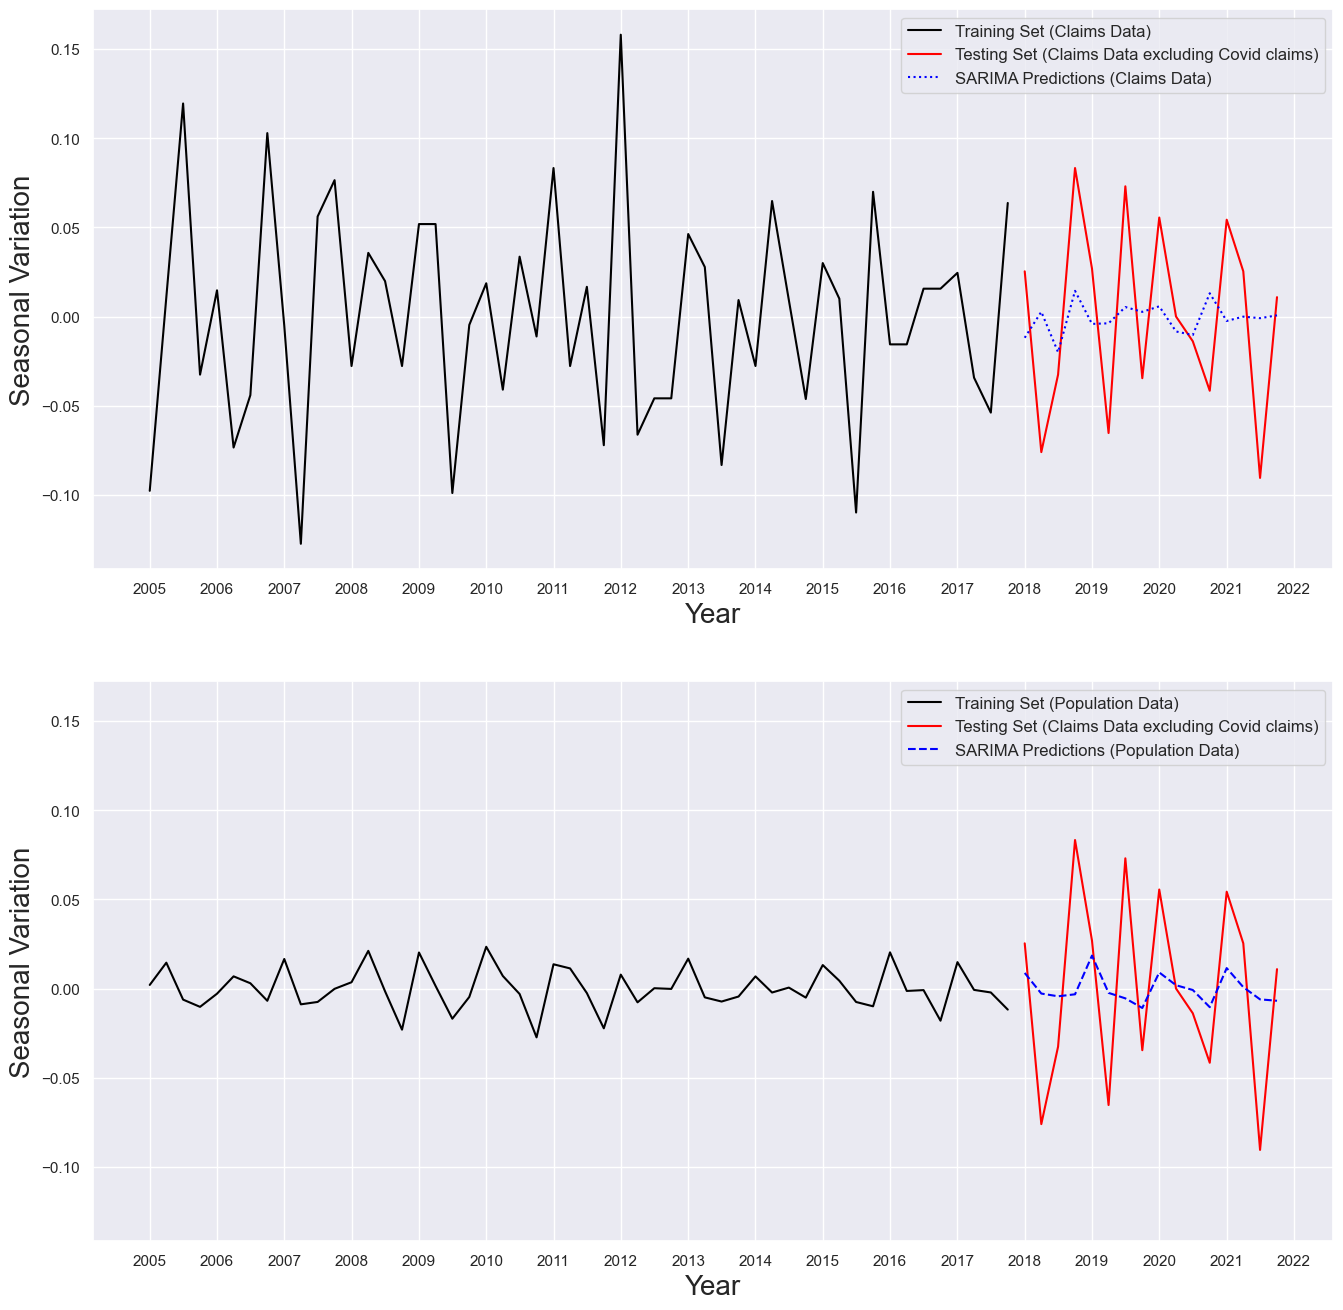

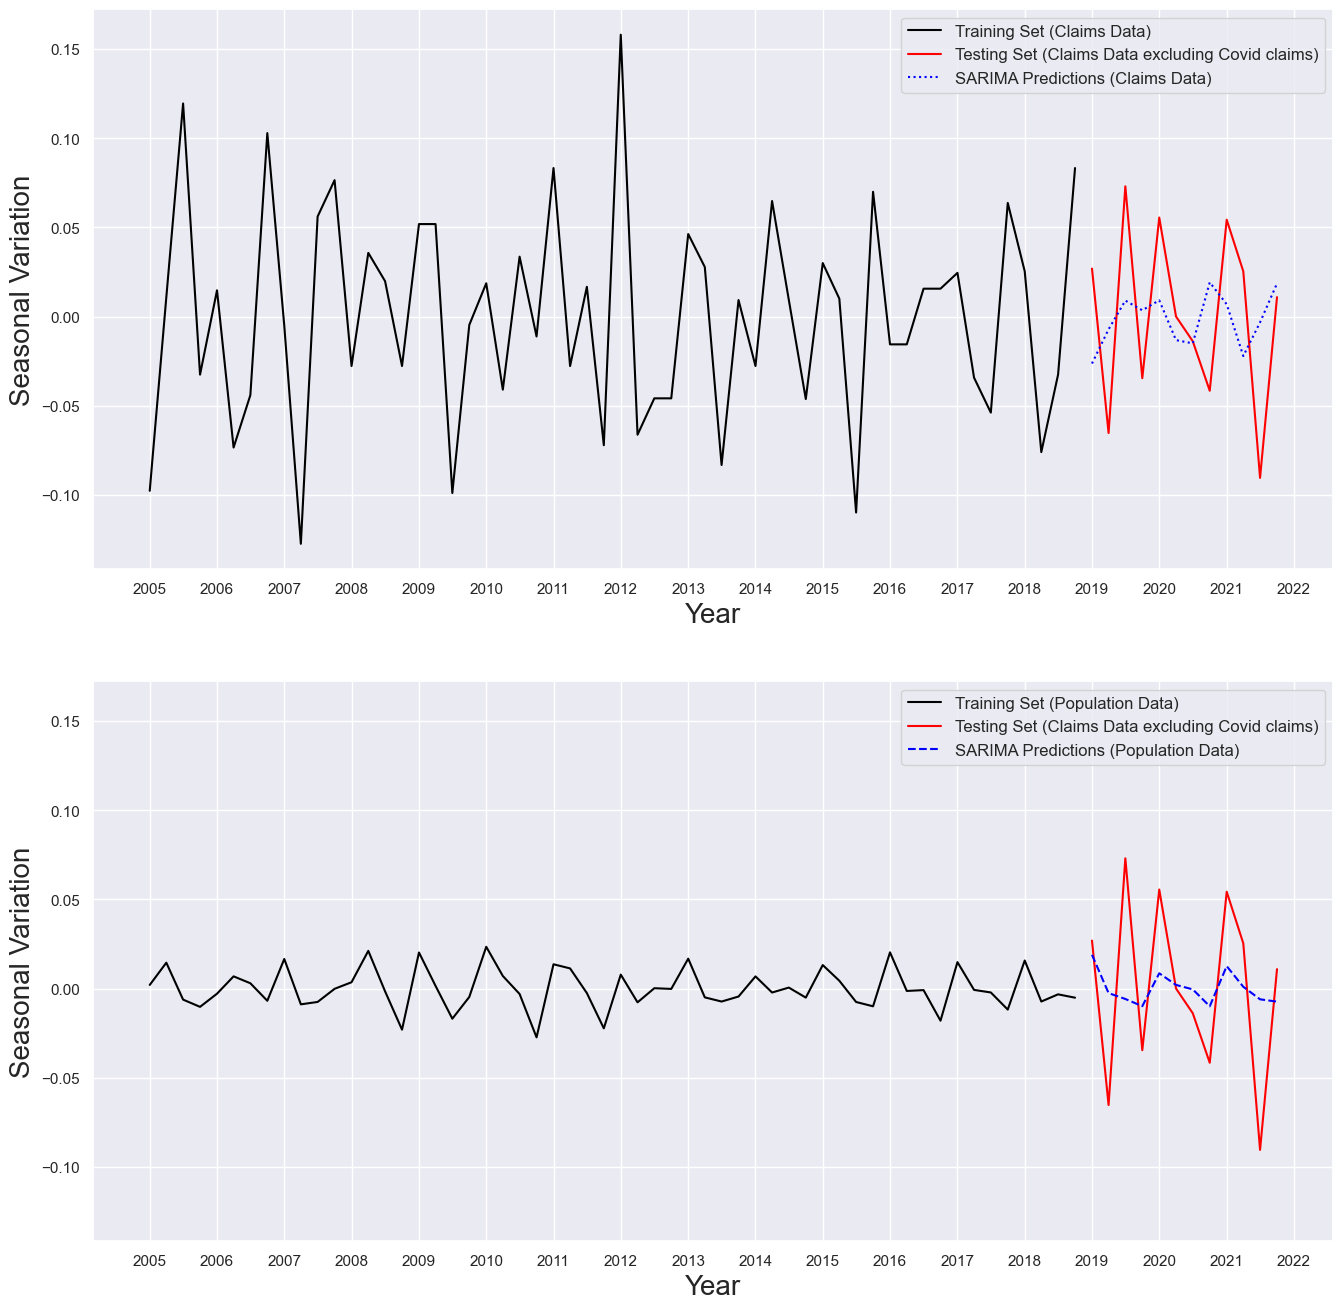

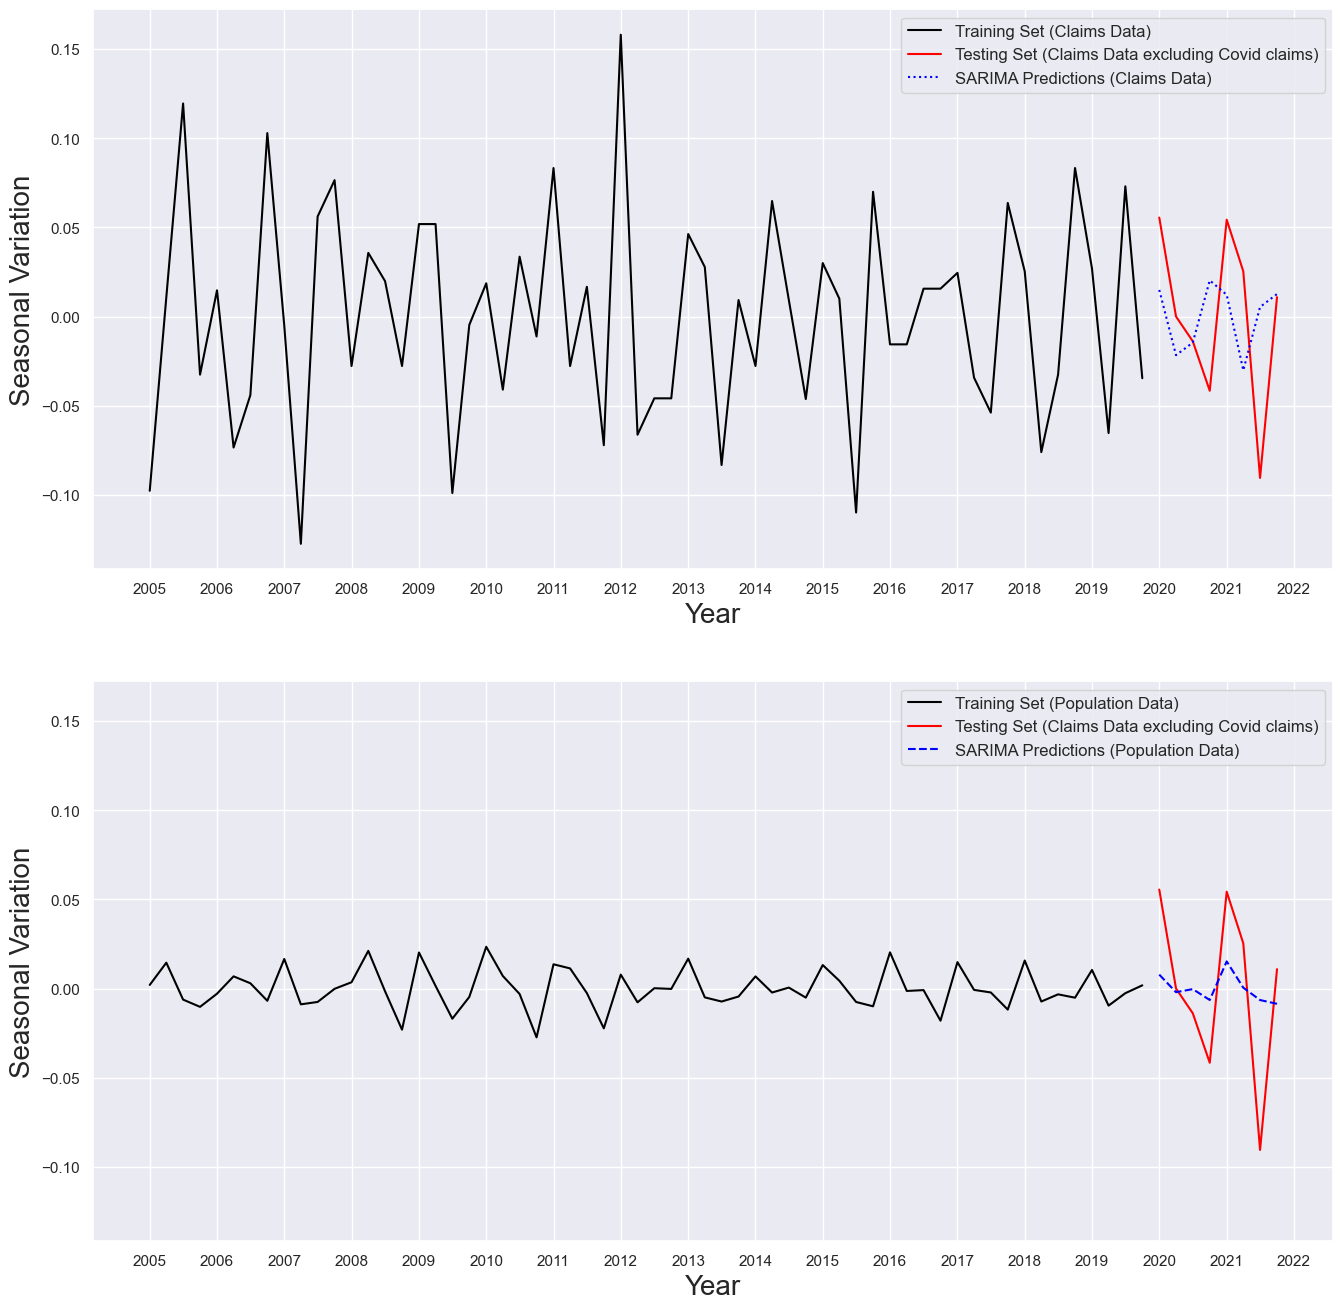

In [35]:
model_name = "SARIMA"

#write for loop to run model for each training/testing period and both claims training data and population training data
for i in test_years:
    train1 = df1_SV[:-i*4]#Set testing training data equal to entire death claims dataset less the last 4 quarters
    train2 = df2_SV[:-i*4]#Set testing training data equal to entire population deaths dataset less the last 4 quarters
    test = df1_SV[-i*4:len(df1_SV)]
    testing_excovid = df3_SV[-i*4:len(df3_SV)]
    y1=train1
    
    SARIMAXmodel1 = SARIMAX(y1, order = (1,0,1), seasonal_order=(1,0,1,12))
    SARIMAXmodel1 = SARIMAXmodel1.fit()

    predictions1 = SARIMAXmodel1.get_forecast(len(test.index))
    predictions1 = predictions1.conf_int(alpha = 0.05) 
    predictions1["Predictions"] = SARIMAXmodel1.predict(start =predictions1.index[0],
                                                end = predictions1.index[-1])
    predictions1.index = test.index
    y_pred1 = pd.DataFrame(predictions1["Predictions"])
    y_pred1.to_csv(f"Death Claim Seasonality Predictions - SARIMA (Claims Data) {i} Year Test Period.csv", index=False)

    y2=train2
    SARIMAXmodel2 = SARIMAX(y2, order = (1,1,1), seasonal_order=(1,1,1,12))
    SARIMAXmodel2 = SARIMAXmodel2.fit()
    
    predictions2 = SARIMAXmodel2.get_forecast(len(test.index))
    predictions2 = predictions2.conf_int(alpha = 0.05) 
    predictions2["Predictions"] = SARIMAXmodel2.predict(start = predictions2.index[0],
                                                end = predictions2.index[-1])
    predictions2.index = test.index
    y_pred2 = pd.DataFrame(predictions2["Predictions"])
    y_pred2.to_csv(f"Death Claim Seasonality Predictions - SARIMA (Population Data) {i} Year Test Period.csv", index=False)
    
    training_data1 = df1[:-i*4]
    training_data1 = pd.DataFrame(training_data1, columns = ['CLAIMS SEASONAL VARIATION'])
    training_data2 = df2[:-i*4]
    training_data2 = pd.DataFrame(training_data2, columns = ['CSO SEASONAL VARIATION'])
    testing_data = df1[-i*4:len(df1)] #Set testing data equal to the last 100 days' prices
    testing_data = pd.DataFrame(testing_data,columns=['CLAIMS SEASONAL VARIATION'])
    testing_data_excovid = df3[-i*4:len(df3)]
    testing_data_excovid = pd.DataFrame(testing_data_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])
    
    plot_results(i, model_name, y_pred1, y_pred2)
    
    exec(f'{model_name}_claims_mae_{i}y = mean_absolute_error(testing_data.values, y_pred1["Predictions"])')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_mae_{i}y = mean_absolute_error(testing_data.values, y_pred2["Predictions"])')#calculate and save MAE for population training data
    exec(f'{model_name}_claims_rmse_{i}y = np.sqrt(mean_squared_error(testing_data.values, y_pred1["Predictions"]))')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_rmse_{i}y= np.sqrt(mean_squared_error(testing_data.values, y_pred2["Predictions"]))')#calculate and save MAE for RMSE for population training data
    exec(f'{model_name}_claims_r2_{i}y = r2_score(testing_data.values, y_pred1["Predictions"])')#calculate and save Rsquared for claims training data
    exec(f'{model_name}_pop_r2_{i}y= r2_score(testing_data.values, y_pred2["Predictions"])')#calculate and save Rsquared for population training data
    #Repeat exercise above for Death Claims Testing Data excluding Covid-19 claims
    exec(f'{model_name}_claims_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred2["Predictions"])')
    exec(f'{model_name}_claims_rmse_{i}y_excovid = np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred1["Predictions"]))')
    exec(f'{model_name}_pop_rmse_{i}y_excovid= np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred2["Predictions"]))')
    exec(f'{model_name}_claims_r2_{i}y_excovid = r2_score(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_r2_{i}y_excovid= r2_score(testing_data_excovid.values, y_pred2["Predictions"])')
    
    #calculate AIC and BIC for death claims training data and population deaths training data
    exec(f'{model_name}_claims_aic_{i}y = SARIMAXmodel1.aic')
    exec(f'{model_name}_pop_aic_{i}y = SARIMAXmodel2.aic')
    exec(f'{model_name}_claims_bic_{i}y = SARIMAXmodel1.bic')
    exec(f'{model_name}_pop_bic_{i}y= SARIMAXmodel2.bic')
    
    


## Random Forest Regressor

### Format input data for Random Forest Regressor

In [37]:
model_name = "RF"

labels1 = np.array(df1['CLAIMS SEASONAL VARIATION'])
labels2 = np.array(df2['CSO SEASONAL VARIATION'])

# Remove the labels from the features
# axis 1 refers to the columns
df1_index = df1.drop(['CLAIMS SEASONAL VARIATION'], axis = 1)
df2_index = df2.drop(['CSO SEASONAL VARIATION'], axis = 1)
df1_list = list(df1.index)# Saving feature names for later use
df2_list = list(df2.index)
df1_array = np.array(df1.Q_num)# Convert to numpy array
df1_array = df1_array.reshape(-1, 1)
df2_array = np.array(df2.Q_num)#was df2.index
df2_array = df2_array.reshape(-1, 1)


In [ ]:
### Run model for each set of training data and each train/test period. Plot results

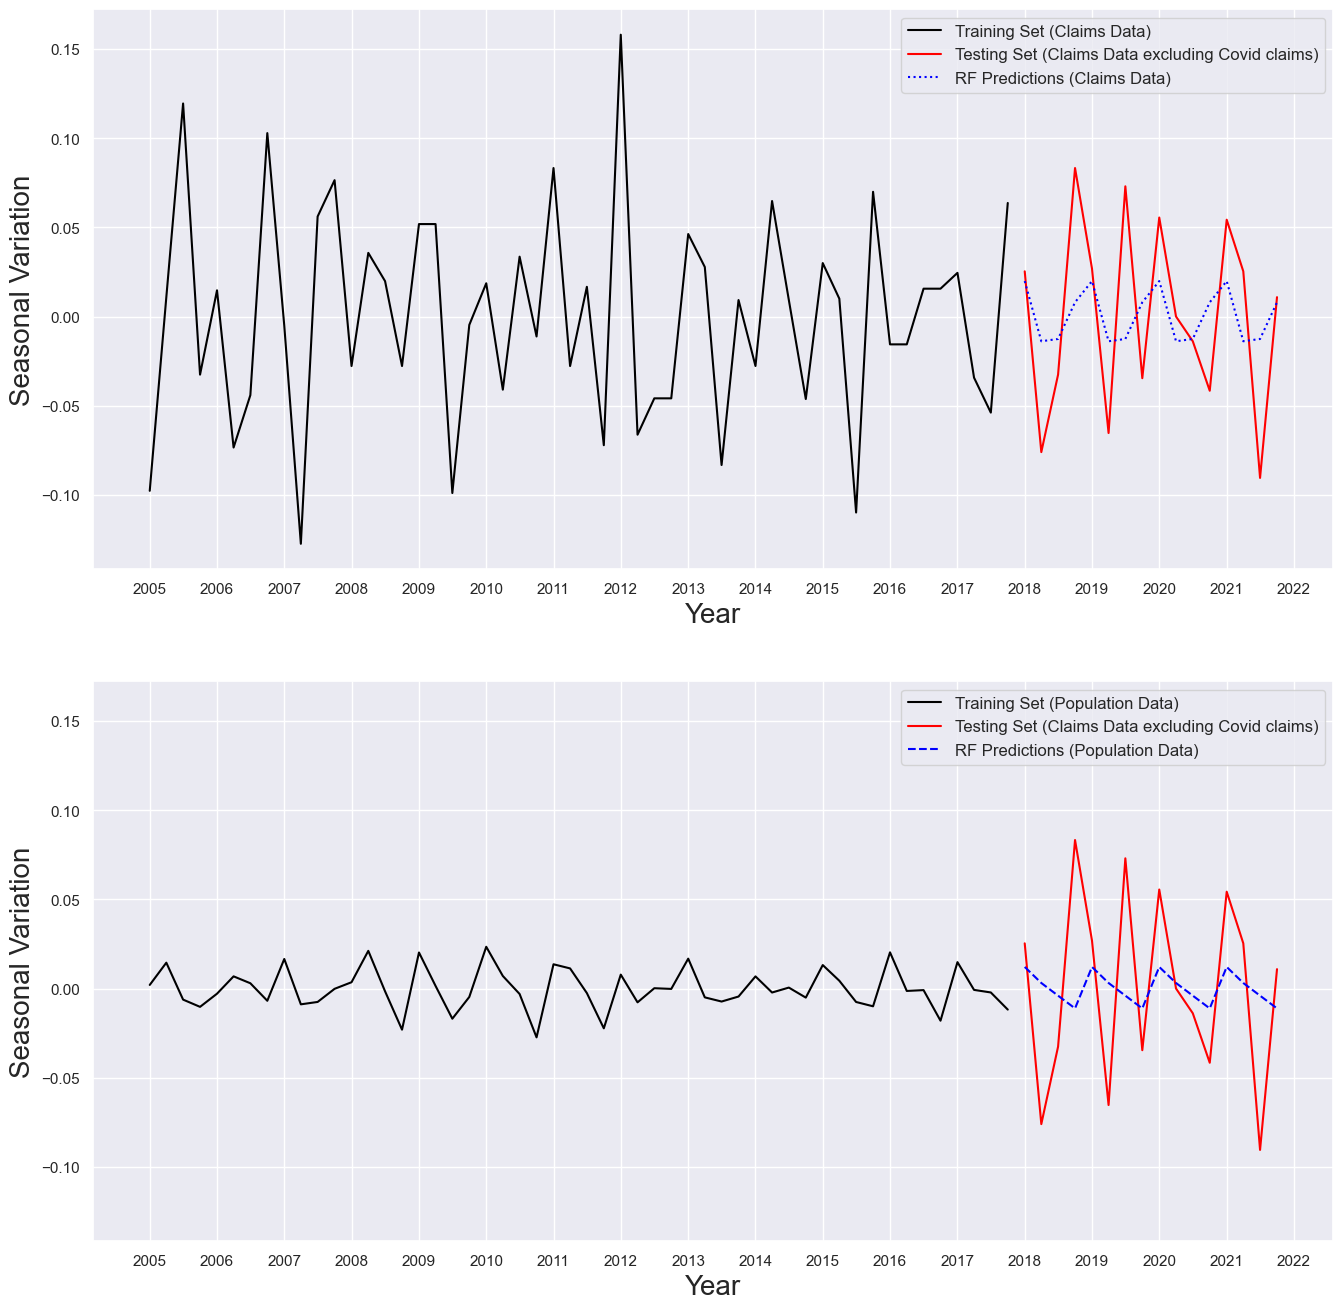

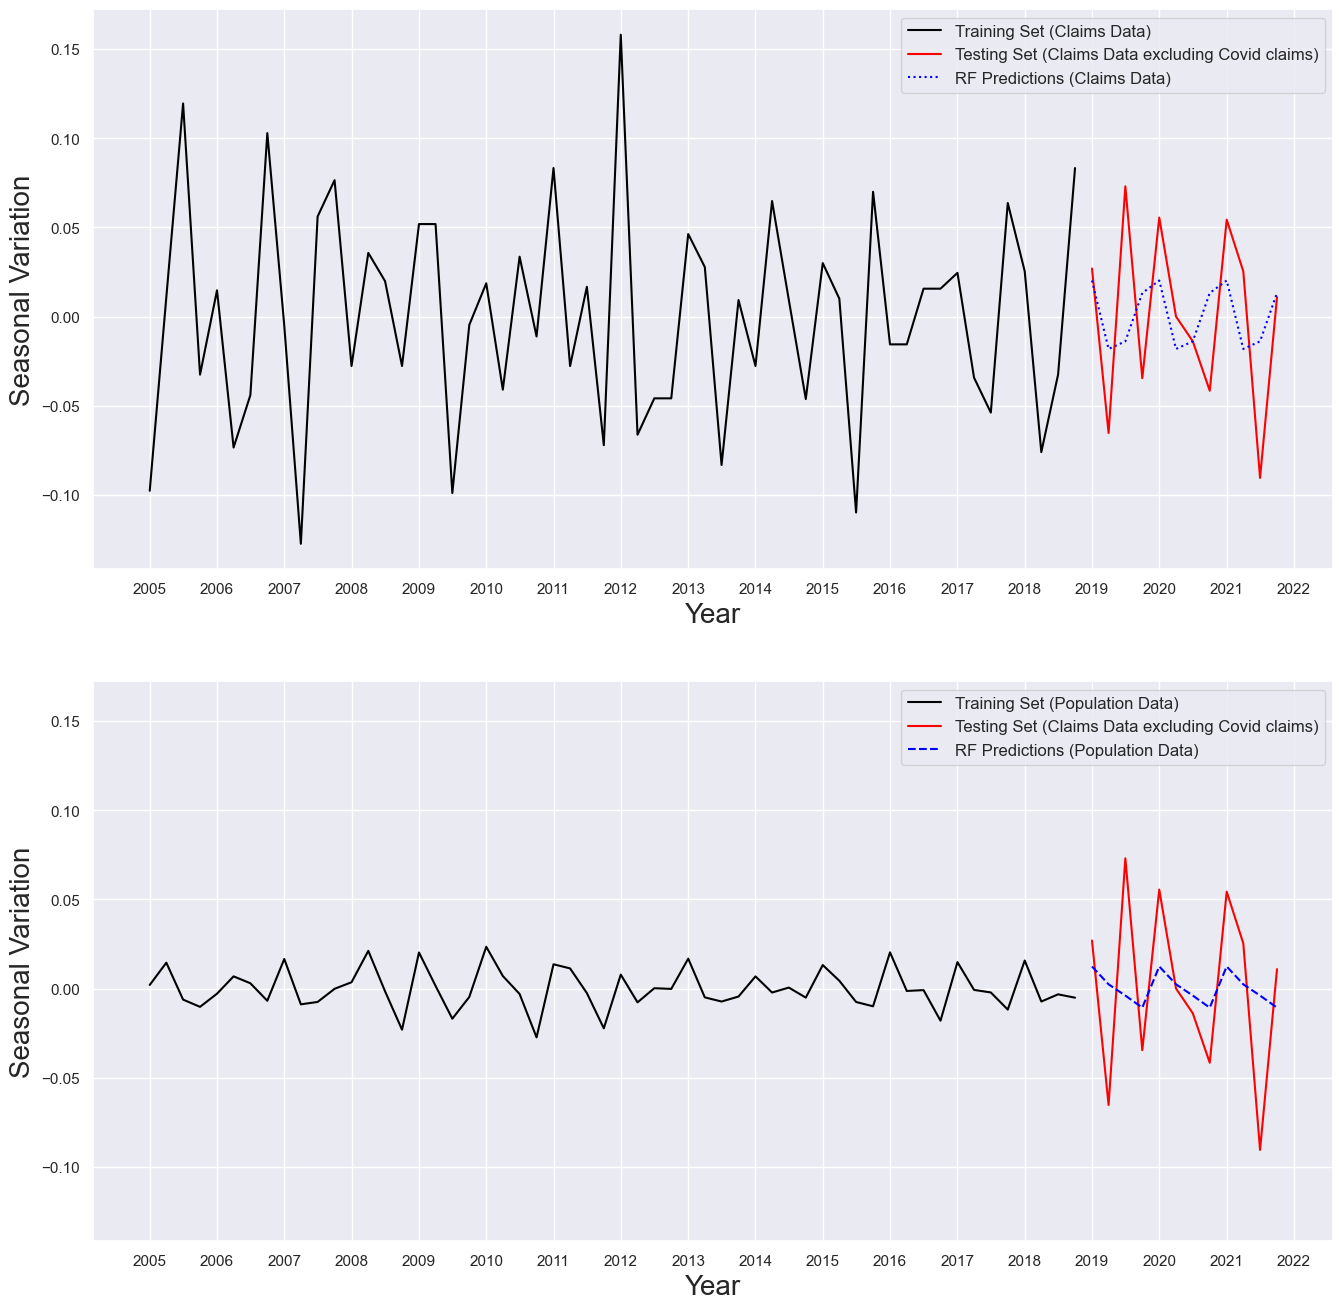

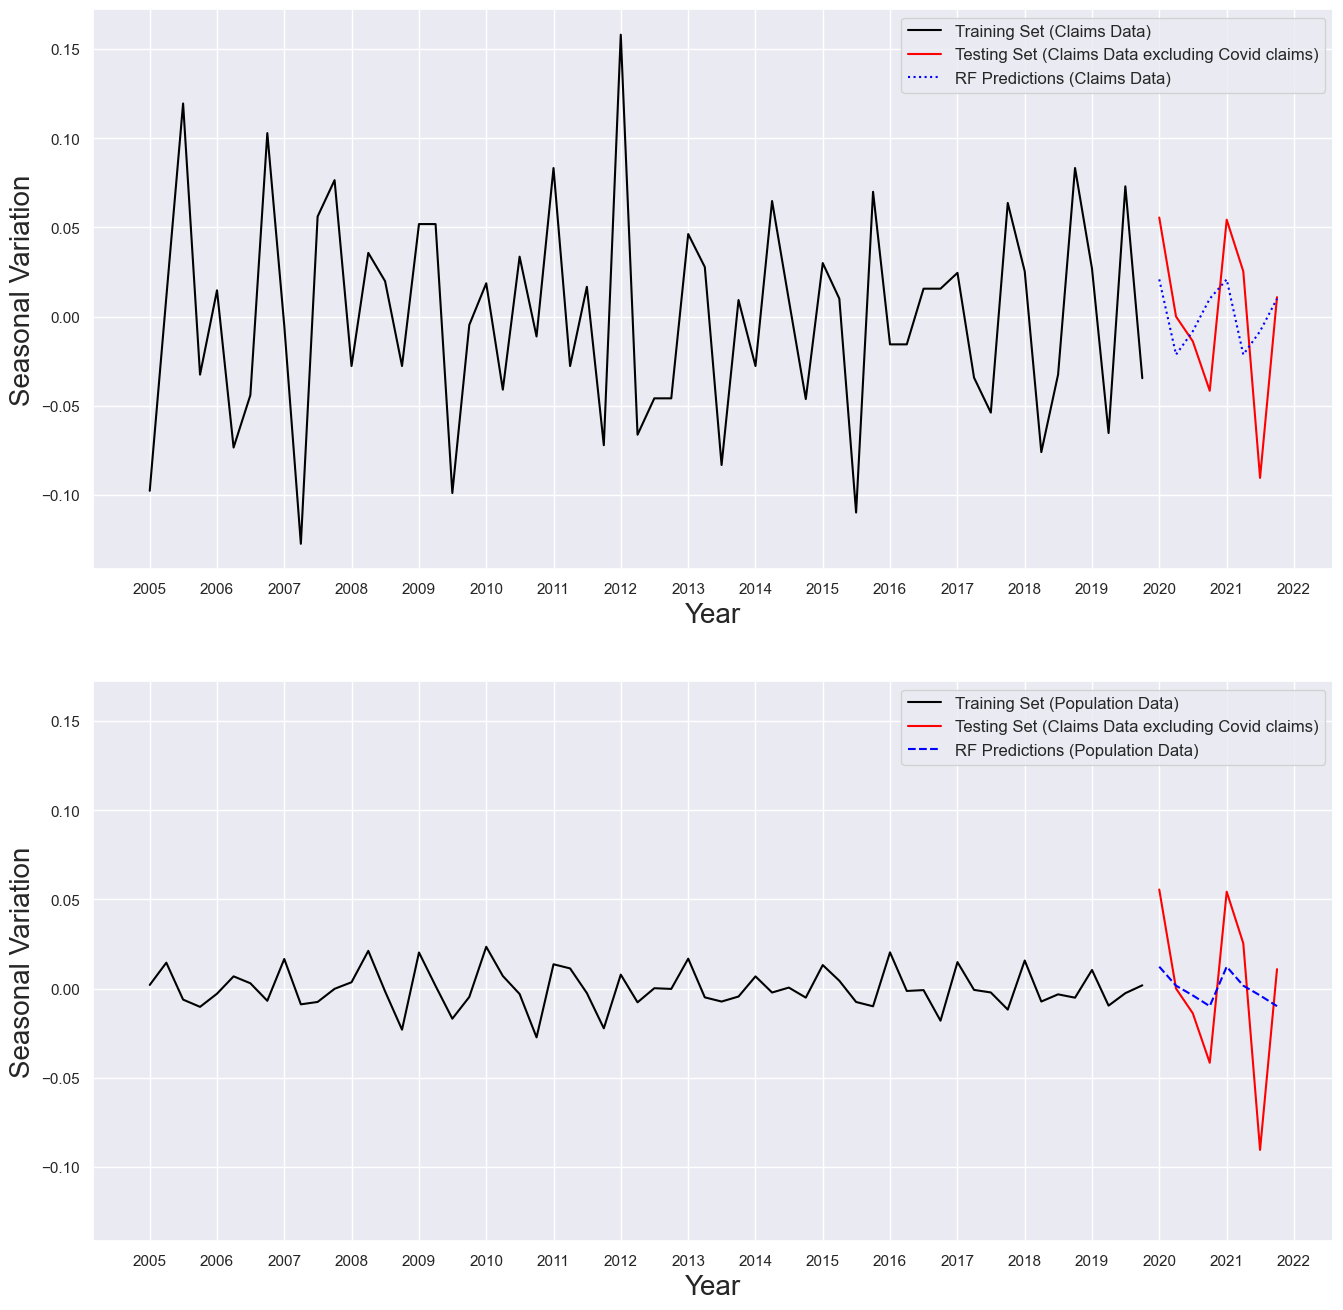

In [39]:
#write for loop to run model for each training/testing period and both claims training data and population training data
for i in test_years:
    train_features1 = df1_array[:-i*4]
    train_features2 = df2_array[:-i*4]
    test_features = df1_array[-i*4:len(df1_array)]
    labels1 = np.array(df1['CLAIMS SEASONAL VARIATION'])
    labels2 = np.array(df2['CSO SEASONAL VARIATION'])
    train_labels1 = labels1[:-i*4]
    train_labels2 = labels2[:-i*4]
    test_labels =  labels1[-i*4:len(df1_array)]
    
    # Import the model we are using
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with 1000 decision trees
    rf1 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf1.fit(train_features1, train_labels1);
    # Use the forest's predict method on the test data
    predictions1 = rf1.predict(test_features)
    # Instantiate model with 1000 decision trees
    rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf2.fit(train_features2, train_labels2);
    # Use the forest's predict method on the test data
    predictions2 = rf2.predict(test_features)
    
    training_data1 = df1[:-i*4]
    training_data1 = pd.DataFrame(training_data1, columns = ['CLAIMS SEASONAL VARIATION'])
    training_data2 = df2[:-i*4]
    training_data2 = pd.DataFrame(training_data2, columns = ['CSO SEASONAL VARIATION'])
    testing_data = df1[-i*4:len(df1)] #Set testing data equal to t
    testing_data = pd.DataFrame(testing_data,columns=['CLAIMS SEASONAL VARIATION'])
    testing_data_excovid = df3[-i*4:len(df3)]
    testing_data_excovid = pd.DataFrame(testing_data_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])
    y_pred1 = pd.DataFrame(predictions1, columns=['Predictions']) 
    y_pred1.index = testing_data.index
    y_pred1.to_csv(f"Death Claim Seasonality Predictions - Random Forest (Claims Data) {i} Year Test Period.csv", index=False)
    y_pred2 = pd.DataFrame(predictions2, columns=['Predictions']) 
    y_pred2.index = testing_data.index
    y_pred2.to_csv(f"Death Claim Seasonality Predictions - Random Forest (Population Data) {i} Year Test Period.csv", index=False)
 
    plot_results(i, model_name, y_pred1, y_pred2) 
    
    exec(f'{model_name}_claims_mae_{i}y = mean_absolute_error(testing_data.values, y_pred1["Predictions"])')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_mae_{i}y = mean_absolute_error(testing_data.values, y_pred2["Predictions"])')#calculate and save MAE for population training data
    exec(f'{model_name}_claims_rmse_{i}y = np.sqrt(mean_squared_error(testing_data.values, y_pred1["Predictions"]))')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_rmse_{i}y= np.sqrt(mean_squared_error(testing_data.values, y_pred2["Predictions"]))')#calculate and save MAE for RMSE for population training data
    exec(f'{model_name}_claims_r2_{i}y = r2_score(testing_data.values, y_pred1["Predictions"])')#calculate and save Rsquared for claims training data
    exec(f'{model_name}_pop_r2_{i}y= r2_score(testing_data.values, y_pred2["Predictions"])')#calculate and save Rsquared for population training data
    #Repeat exercise above for Death Claims Testing Data excluding Covid-19 claims
    exec(f'{model_name}_claims_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred2["Predictions"])')
    exec(f'{model_name}_claims_rmse_{i}y_excovid = np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred1["Predictions"]))')
    exec(f'{model_name}_pop_rmse_{i}y_excovid= np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred2["Predictions"]))')
    exec(f'{model_name}_claims_r2_{i}y_excovid = r2_score(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_r2_{i}y_excovid= r2_score(testing_data_excovid.values, y_pred2["Predictions"])')

    


## LSTM

### Format data for Prophet model

In [40]:
model_name = "LSTM"

array1 = df1.iloc[:, 0].values #Transform dataframe to an array as the keras module of TensorFlow only accepts NumPy arrays as parameters 
array2 = df2.iloc[:, 0].values #Transform dataframe to an array as the keras module of TensorFlow only accepts NumPy arrays as parameters 

### Run model for each set of training data and each train/test period. Plot results

Epoch 1/100
2/2 [==============================] - 6s 11ms/step - loss: 0.4444
Epoch 2/100
2/2 [==============================] - 0s 11ms/step - loss: 0.4225
Epoch 3/100
2/2 [==============================] - 0s 16ms/step - loss: 0.3977
Epoch 4/100
2/2 [==============================] - 0s 11ms/step - loss: 0.3735
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3390
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 0.3013
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.2522
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 0.2147
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1689
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1653
Epoch 11/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1904
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1973
Epoch 13/100
2/2 [==============================] - 0s 8

2/2 [==============================] - 0s 8ms/step - loss: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 9ms/step - loss: 0.4748
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.4453
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 0.4125
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3686
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 0.3206
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2516
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1970
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1761
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 0.2172
Epoch 13/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 14/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1855
Epoch 15/100
2/2 [==============================] - 0s 9ms/step - los

2/2 [==============================] - 0s 8ms/step - loss: 0.2888
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2459
Epoch 8/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1990
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1691
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1713
Epoch 11/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1803
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1867
Epoch 13/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1645
Epoch 14/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1660
Epoch 15/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1655
Epoch 16/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1749
Epoch 17/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1711
Epoch 18/100
2/2 [==============================] - 0s 9ms/step - l

2/2 [==============================] - 0s 10ms/step - loss: 0.2936
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 0.2049
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1695
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1947
Epoch 12/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2217
Epoch 13/100
2/2 [==============================] - 0s 9ms/step - loss: 0.2037
Epoch 14/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1719
Epoch 15/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1620
Epoch 16/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1690
Epoch 17/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1796
Epoch 18/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1910
Epoch 19/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1880
Epoch 20/100
2/2 [==============================] - 0s 8ms/step 

2/2 [==============================] - 0s 9ms/step - loss: 0.1797
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1780
Epoch 13/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1778
Epoch 14/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1630
Epoch 15/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1592
Epoch 16/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1736
Epoch 17/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1757
Epoch 18/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1802
Epoch 19/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1847
Epoch 20/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1712
Epoch 21/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1744
Epoch 22/100
2/2 [==============================] - 0s 10ms/step - loss: 0.1650
Epoch 23/100
2/2 [==============================] - 0s 10ms/

2/2 [==============================] - 0s 10ms/step - loss: 0.4593
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 0.4272
Epoch 6/100
2/2 [==============================] - 0s 11ms/step - loss: 0.3741
Epoch 7/100
2/2 [==============================] - 0s 9ms/step - loss: 0.3229
Epoch 8/100
2/2 [==============================] - 0s 10ms/step - loss: 0.2436
Epoch 9/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1899
Epoch 10/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1855
Epoch 11/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2119
Epoch 12/100
2/2 [==============================] - 0s 9ms/step - loss: 0.2210
Epoch 13/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1911
Epoch 14/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1717
Epoch 15/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1731
Epoch 16/100
2/2 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 1s 1s/step


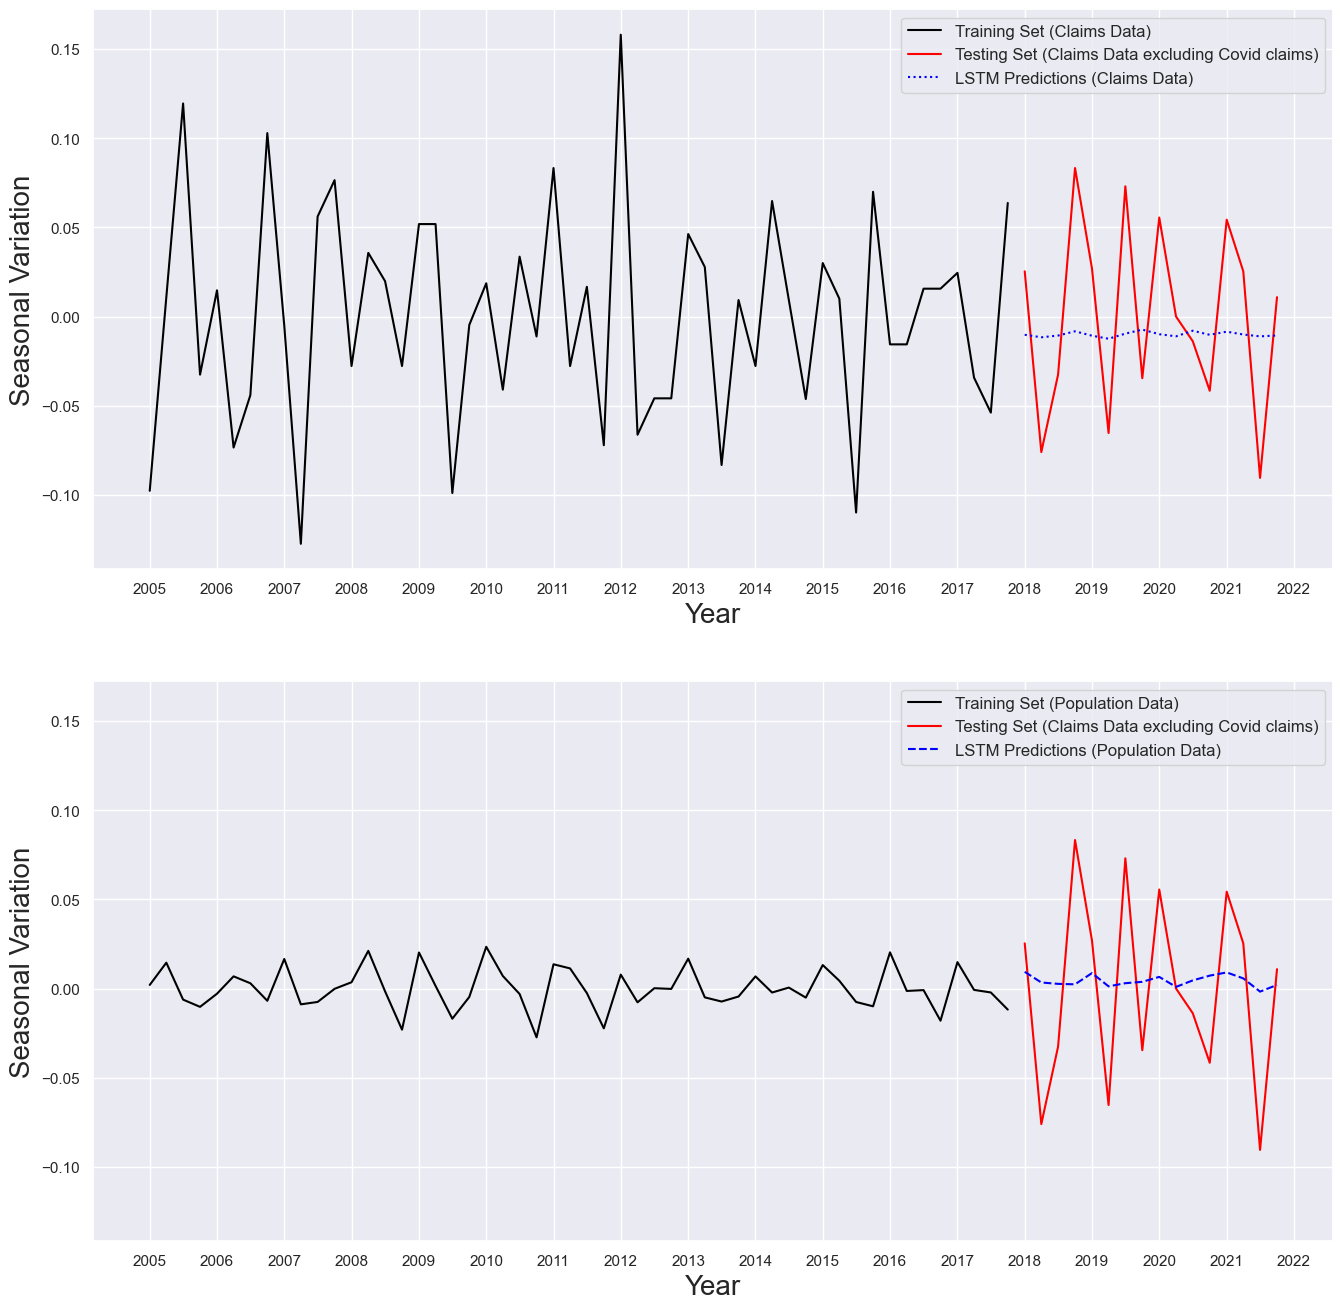

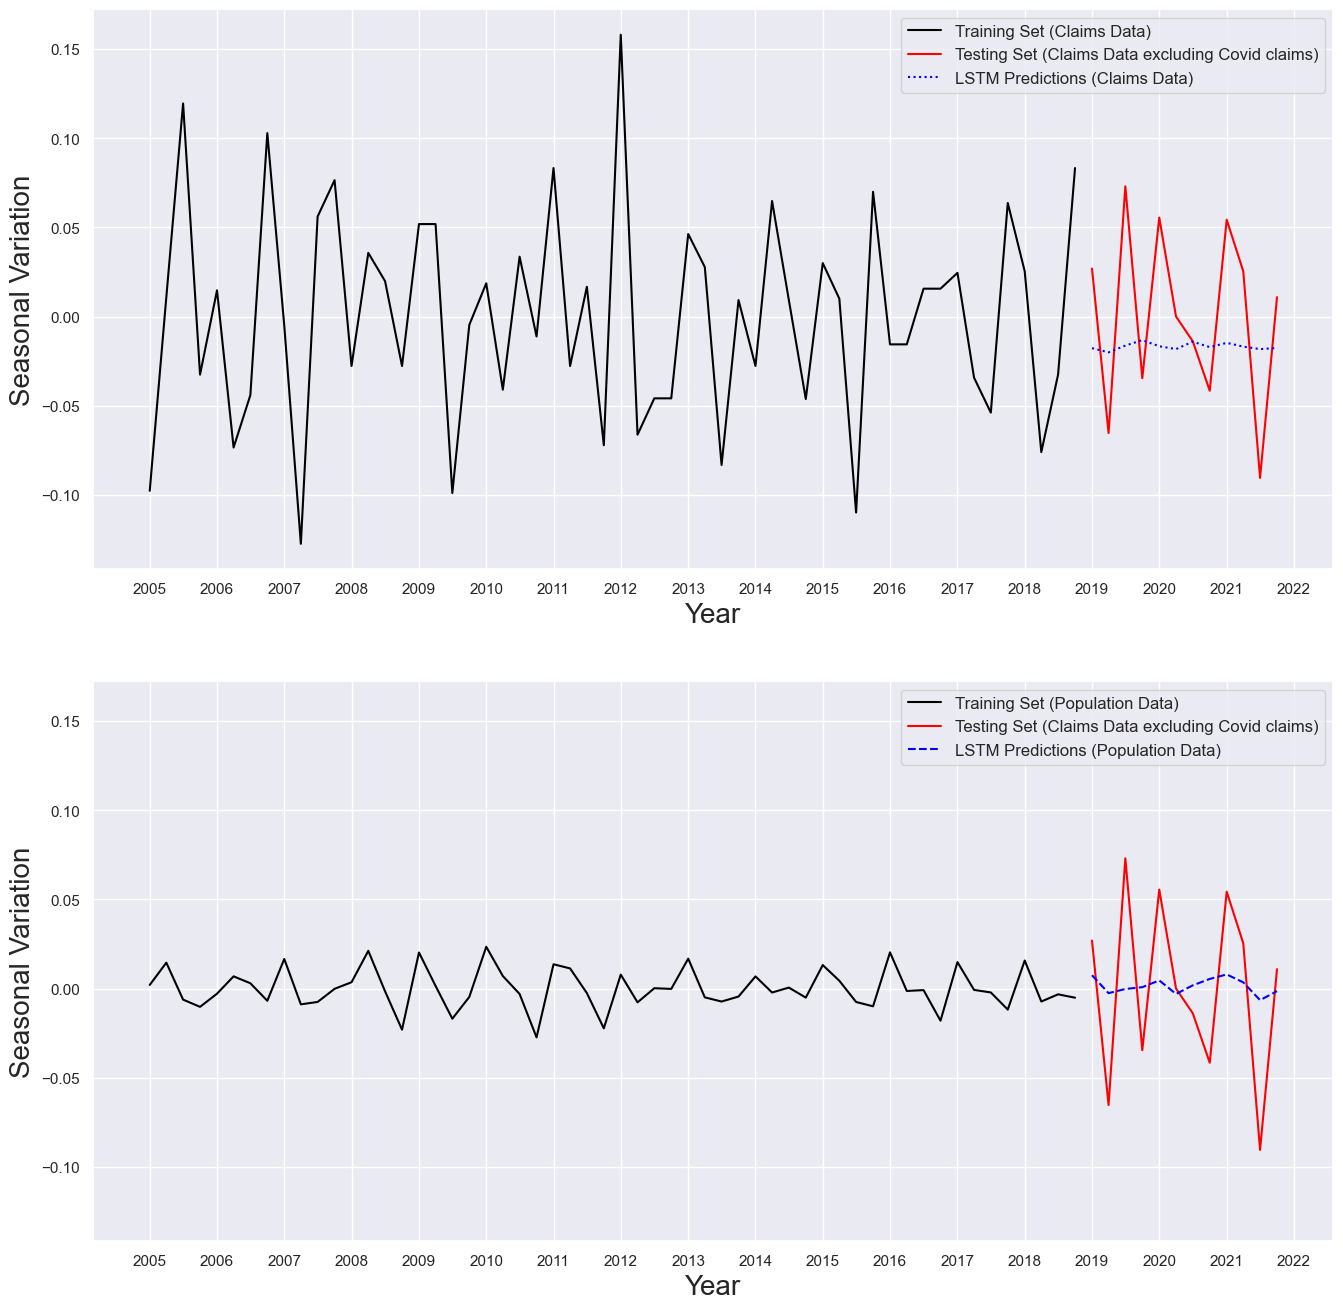

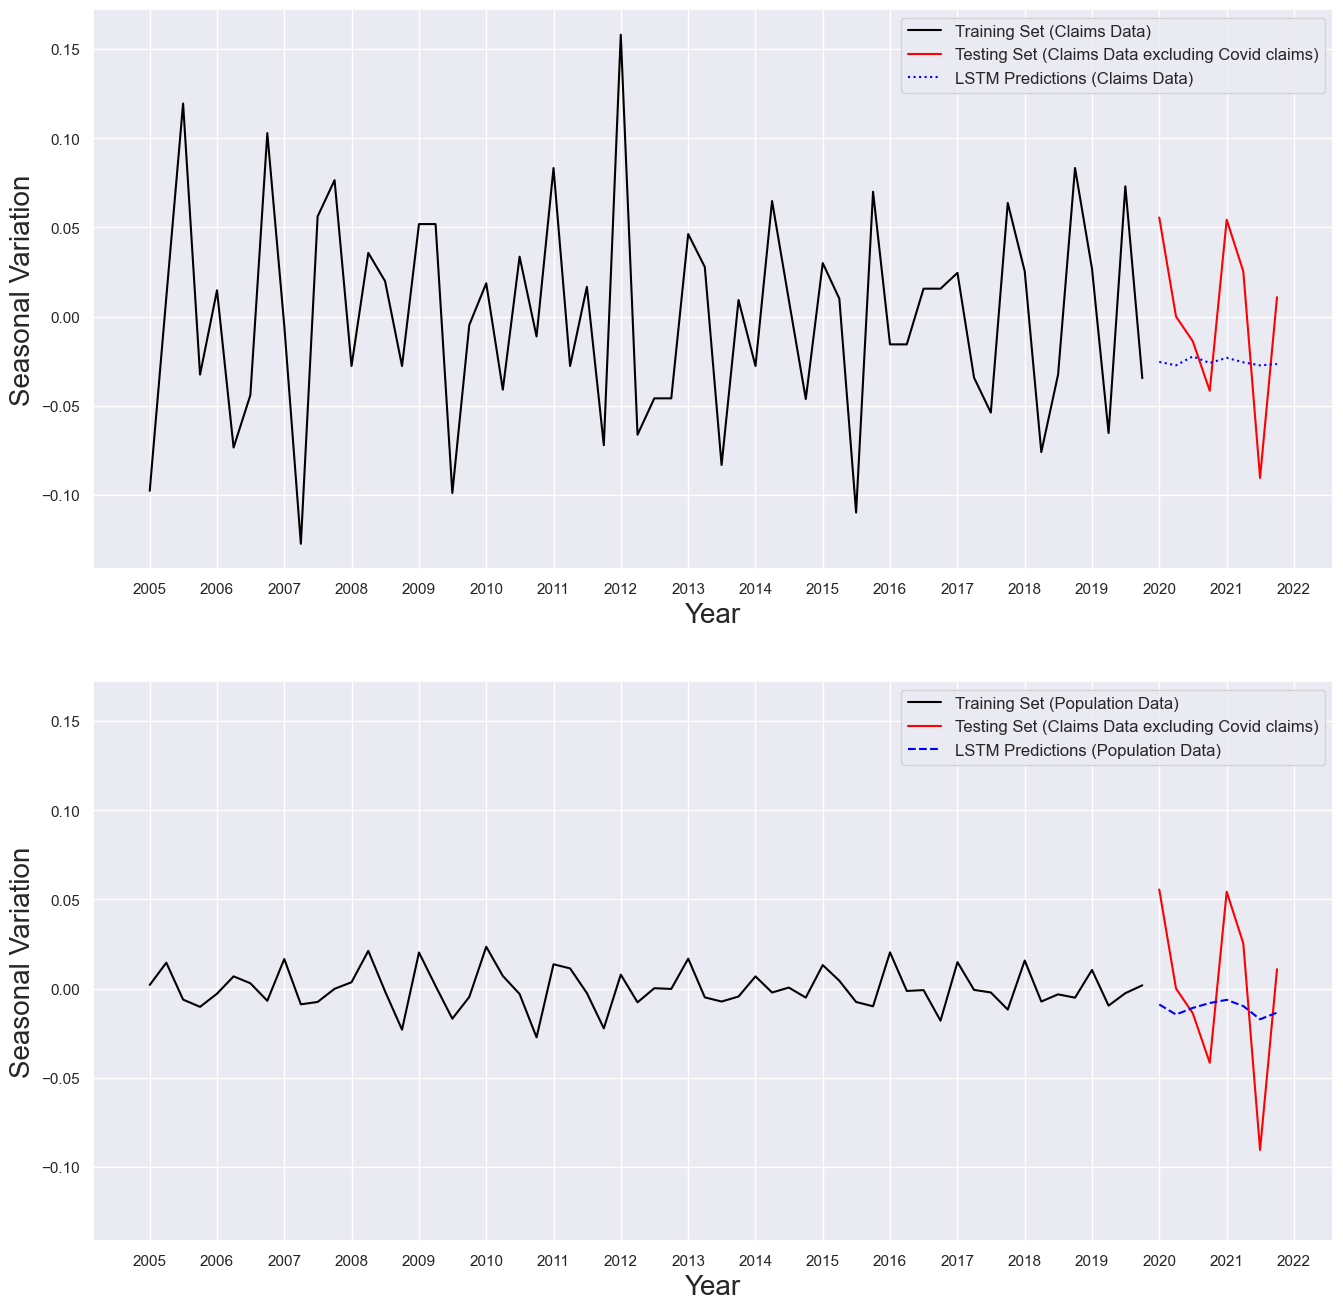

In [41]:
timesteps  = 4

for i in test_years:
    training_data1 = array1[:-i*4]
    training_data2 = array2[:-i*4]
    testing_data = array1[-i*4:len(array1)]
    scaled_training_data1 = scaler.fit_transform(training_data1.reshape(-1, 1)) #Scale testing data so that it fits between -1 and +1
    scaled_training_data2 = scaler.fit_transform(training_data2.reshape(-1, 1)) #Scale testing data so that it fits between -1 and +1
    scaled_testing_data = scaler.fit_transform(testing_data.reshape(-1, 1)) #Scale testing data so that it fits between -1 and +1
    x_training_data1 = [] #Create empty list called 
    y_training_data1 = [] #Create empty list called y_training data
    for j in range(timesteps, len(scaled_training_data1)):          #Specify 4 timesteps. For every day's tweets the model predicts, it will use 4 previous quarters pricing to determine its output.  
        x_training_data1.append(scaled_training_data1[j-timesteps:j, 0]) #Use for loop to populate actual data into the  and y_training_data lists
        y_training_data1.append(scaled_training_data1[j, 0])
    x_training_data1 = np.array(x_training_data1) #TensorFlow is designed to work with arrays so we need to transform the two Python lists we created in the previous step into NumPy arrays.
    y_training_data1 = np.array(y_training_data1)
    x_training_data1 = np.reshape(x_training_data1, (x_training_data1.shape[0], #Reshape the training data one more time because the RNN layer available in TensorFlow only accepts data in a very specific format.  
    x_training_data1.shape[1],1))
    from tensorflow.keras.models import Sequential #Import classes from TensorFlow that are needed to build the RNN 
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    rnn1 = Sequential() #Initialise an object from TensorFlows Sequential class. This class is designed to build neural networks by adding sequences of layers over time.
    rnn1.add(LSTM(units = 50, return_sequences = True, input_shape =(x_training_data1.shape[1], 1))) #Add an LSTM layer first. Specify 3 arguments: Units = 50, return_sequences = True, input_shape = 3 timesteps and  1 predictor 
    rnn1.add(Dropout(0.2)) #Dropout regularisation is a technique used to avoid overfitting when training neural networks. Assume a dropout rate of 20%.
    rnn1.add(LSTM(units = 50, return_sequences = True)) #Add three more LSTM layers
    rnn1.add(Dropout(0.2))
    rnn1.add(LSTM(units = 50, return_sequences = True))
    rnn1.add(Dropout(0.2))
    rnn1.add(LSTM(units = 50)) #Remove return_sequences = True as this is the last LSTM layer
    rnn1.add(Dropout(0.2))
    rnn1.add(Dense(units = 1)) #Add output layer. Units = 1 as we want to predict the next quarter's seasonality
    rnn1.compile(optimizer = 'adam', loss = 'mean_absolute_error') #Specify Adam optimiser. Since we are predicting a continuous variable we can use Mean Squared Error as our loss parameter.
    rnn1.fit(x_training_data1, y_training_data1, epochs = 100, batch_size = 32)  #Train the RNN on our training data ( and y_training_data). Epochs = number of iterations I want the RNN to train on. Batch size = size of batches RNN will be trained on through each epoch.  
    x_test_data1 = df1[len(df1)-i*4-timesteps:] #we need 4 quarters (testing data) set + 1 timestep =  5 quarters
    x_test_data1= x_test_data1.iloc[:,0].values
    x_test_data1.shape #x_test_data should have 5 rows and no columns
    x_test_data1 = np.reshape(x_test_data1, (-1, 1)) #reshape NumPy array to make it suitable for the predict method
    x_test_data1 = scaler.transform(x_test_data1) #Scale test data so we can use model to make predictions. This is because we want to transform the test data according to the fit generated from
#the entire training data set. This means that the transformation that is applied to the test data will be the same as the one applied to the training data - which is necessary for our recurrent neural network to make
#accurate predictions
    final_x_test_data1 = []                             
    for j in range(timesteps, len(x_test_data1)):
        final_x_test_data1.append(x_test_data1[j-timesteps:j, 0])
    final_x_test_data1 = np.array(final_x_test_data1)
    final_x_test_data1 = np.reshape(final_x_test_data1, (final_x_test_data1.shape[0],final_x_test_data1.shape[1],1)) #reshape final test data to meet TensorFlow standards
    predictions1 = rnn1.predict(final_x_test_data1) #Pass final_x_test_data into the predict() method called on the run object and store in a variable called predictions. 
    unscaled_predictions1 = scaler.inverse_transform(predictions1) 
    
    
    
    
    
    

    x_training_data2 = [] #Create empty list called 
    y_training_data2 =[] #Create empty list called y_training data
    for j in range(timesteps, len(scaled_training_data2)):          #Specify 4 timesteps. For every day's tweets the model predicts, it will use 4 previous quarters pricing to determine its output.  
        x_training_data2.append(scaled_training_data2[j-timesteps:j, 0]) #Use for loop to populate actual data into the  and y_training_data lists
        y_training_data2.append(scaled_training_data2[j, 0])
    x_training_data2 = np.array(x_training_data2) #TensorFlow is designed to work with arrays so we need to transform the two Python lists we created in the previous step into NumPy arrays.
    y_training_data2 = np.array(y_training_data2)
    x_training_data2 = np.reshape(x_training_data2, (x_training_data2.shape[0], #Reshape the training data one more time because the RNN layer available in TensorFlow only accepts data in a very specific format.  
    x_training_data2.shape[1],1))
    rnn2 = Sequential() #Initialise an object from TensorFlows Sequential class. This class is designed to build neural networks by adding sequences of layers over time.
    rnn2.add(LSTM(units = 50, return_sequences = True, input_shape =(x_training_data2.shape[1], 1))) #Add an LSTM layer first. Specify 3 arguments: Units = 50, return_sequences = True, input_shape = 3 timesteps and  1 predictor 
    rnn2.add(Dropout(0.2)) #Dropout regularisation is a technique used to avoid overfitting when training neural networks. Assume a dropout rate of 20%.
    rnn2.add(LSTM(units = 50, return_sequences = True)) #Add three more :STM layers
    rnn2.add(Dropout(0.2))
    rnn2.add(LSTM(units = 50, return_sequences = True))
    rnn2.add(Dropout(0.2))
    rnn2.add(LSTM(units = 50)) #Remove return_sequences = True as this is the last LSTM layer
    rnn2.add(Dropout(0.2))
    rnn2.add(Dense(units = 1)) #Add output layer. Units = 1 as we want to predict the next quarter's seasonal variation
    rnn2.compile(optimizer = 'adam', loss = 'mean_absolute_error') #Specify Adam optimiser. Since we are predicting a continuous variable we can use Mean Squared Error as our loss parameter.
    rnn2.fit(x_training_data2, y_training_data2, epochs = 100, batch_size = 32)  #Train the RNN on our training data ( and y_training_data). Epochs = number of iterations I want the RNN to train on. Batch size = size of batches RNN will be trained on through each epoch.  
    x_test_data2 = df2[len(df2)-i*4-timesteps:] #we need 4 quarters (testing data) set + 1 timestep =  5 quarters
    x_test_data2 = x_test_data2.iloc[:,0].values
    x_test_data2.shape #x_test_data should have 5 rows and no columns
    x_test_data2 = np.reshape(x_test_data2, (-1, 1)) #reshape NumPy array to make it suitable for the predict method
    x_test_data2 = scaler.transform(x_test_data2) #Scale test data so we can use model to make predictions. This is because we want to transform the test data according to the fit generated from
#the entire training data set. This means that the transformation that is applied to the test data will be the same as the one applied to the training data - which is necessary for our recurrent neural network to make
#accurate predictions
    final_x_test_data2 = []                             
    
    for j in range(timesteps, len(x_test_data2)):
        final_x_test_data2.append(x_test_data2[j-timesteps:j, 0])
    final_x_test_data2 = np.array(final_x_test_data2)
    final_x_test_data2 = np.reshape(final_x_test_data2, (final_x_test_data2.shape[0],final_x_test_data2.shape[1],1)) #reshape final test data to meet TensorFlow standards
    #training_data1 = df1[:-i*4]
    #training_data1 = training_data1.reset_index()
    #training_data1 = pd.DataFrame(training_data1, columns = ['Seasonal Variation'])
    #training_data2 = df2[:-i*4]
    #training_data2 = training_data2.reset_index()
    #training_data2 = pd.DataFrame(training_data2, columns = ['Seasonal Variation'])
    #testing_data = df1[-i*4:len(df1)] #Set testing data equal 
    #testing_data = pd.DataFrame(testing_data,columns=['Seasonal Variation'])
    #testing_data_excovid = df3[-i*4:len(df3)]
    #testing_data_excovid = pd.DataFrame(testing_data_excovid,columns=['Seasonal Variation'])
    predictions2 = rnn2.predict(final_x_test_data2) #Pass final_x_test_data into the predict() method called on the run object and store in a variable called predictions. 
    unscaled_predictions2 = scaler.inverse_transform(predictions2)
    
    training_data1 = df1[:-i*4]
    training_data1 = pd.DataFrame(training_data1, columns = ['CLAIMS SEASONAL VARIATION'])
    training_data2 = df2[:-i*4]
    training_data2 = pd.DataFrame(training_data2, columns = ['CSO SEASONAL VARIATION'])
    testing_data = df1[-i*4:len(df1)] #Set testing data equal to the last 100 days' prices
    testing_data = pd.DataFrame(testing_data,columns=['CLAIMS SEASONAL VARIATION'])
    testing_data_excovid = df3[-i*4:len(df3)]
    testing_data_excovid = pd.DataFrame(testing_data_excovid,columns=['CLAIMS SEASONAL VARIATION EX COVID'])
    
    y_pred1 = pd.DataFrame(unscaled_predictions1, columns=['Predictions'])
    y_pred1.index = testing_data.index
    y_pred1.to_csv(f"Death Claim Seasonality Predictions - LSTM (Claims Data) {i} Year Testing Period.csv", index=False)#write csv file
    y_pred2 = pd.DataFrame(unscaled_predictions2, columns=['Predictions'])
    y_pred2.index = testing_data.index
    y_pred2.to_csv(f"Death Claim Seasonality Predictions - LSTM (Population Data) {i} Year Testing Period.csv", index=False)#write csv file

    plot_results(i, model_name, y_pred1, y_pred2)
    
    exec(f'{model_name}_claims_mae_{i}y = mean_absolute_error(testing_data.values, y_pred1["Predictions"])')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_mae_{i}y = mean_absolute_error(testing_data.values, y_pred2["Predictions"])')#calculate and save MAE for population training data
    exec(f'{model_name}_claims_rmse_{i}y = np.sqrt(mean_squared_error(testing_data.values, y_pred1["Predictions"]))')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_rmse_{i}y= np.sqrt(mean_squared_error(testing_data.values, y_pred2["Predictions"]))')#calculate and save MAE for RMSE for population training data
    exec(f'{model_name}_claims_r2_{i}y = r2_score(testing_data.values, y_pred1["Predictions"])')#calculate and save Rsquared for claims training data
    exec(f'{model_name}_pop_r2_{i}y= r2_score(testing_data.values, y_pred2["Predictions"])')#calculate and save Rsquared for population training data
    #Repeat exercise above for Death Claims Testing Data excluding Covid-19 claims
    exec(f'{model_name}_claims_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred2["Predictions"])')
    exec(f'{model_name}_claims_rmse_{i}y_excovid = np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred1["Predictions"]))')
    exec(f'{model_name}_pop_rmse_{i}y_excovid= np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred2["Predictions"]))')
    exec(f'{model_name}_claims_r2_{i}y_excovid = r2_score(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_r2_{i}y_excovid= r2_score(testing_data_excovid.values, y_pred2["Predictions"])')
   
   

## Prophet

### Format data for Prophet model

In [44]:
model_name = "Prophet"
df1_SV= df1.loc[:,'CLAIMS SEASONAL VARIATION']
df1_SV = pd.DataFrame(df1_SV)
df2_SV = df2.loc[:,'CSO SEASONAL VARIATION']
df2_SV= pd.DataFrame(df2_SV)
df1_SV.reset_index(inplace=True)
df2_SV.reset_index(inplace=True)
df1_SV.columns = ['ds','y']
df2_SV.columns = ['ds','y']
df1_SV['ds'] = to_datetime(df1_SV['ds'])
df2_SV['ds'] = to_datetime(df2_SV['ds'])

### Run model for each set of training data and each train/test period. Plot results

14:29:36 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing
14:29:37 - cmdstanpy - INFO - Chain [1] start processing


           ds      yhat  yhat_lower  yhat_upper
0  2018-01-01  0.013853   -0.052672    0.085937
1  2018-04-01 -0.022112   -0.090123    0.053302
2  2018-07-01 -0.013084   -0.091111    0.059771
3  2018-10-01  0.014110   -0.064189    0.089957
4  2019-01-01  0.026250   -0.045659    0.101517
5  2019-04-01 -0.036035   -0.107502    0.033416
6  2019-07-01 -0.012371   -0.083502    0.062974
7  2019-10-01  0.027117   -0.045821    0.097594
8  2020-01-01  0.038907   -0.031934    0.102919
9  2020-04-01  0.004562   -0.067692    0.082192
10 2020-07-01 -0.014653   -0.085481    0.060943
11 2020-10-01 -0.013055   -0.085975    0.058395
12 2021-01-01  0.001333   -0.073691    0.070286
13 2021-04-01 -0.008838   -0.078667    0.060446
14 2021-07-01 -0.014109   -0.087550    0.057658
15 2021-10-01  0.000452   -0.068179    0.075226


14:29:37 - cmdstanpy - INFO - Chain [1] done processing


           ds      yhat  yhat_lower  yhat_upper
0  2018-01-01  0.012073    0.002290    0.022077
1  2018-04-01  0.002855   -0.006500    0.012687
2  2018-07-01 -0.004407   -0.014794    0.005356
3  2018-10-01 -0.011048   -0.020193   -0.001963
4  2019-01-01  0.011648    0.001820    0.021404
5  2019-04-01  0.002467   -0.007250    0.011984
6  2019-07-01 -0.004938   -0.014306    0.004092
7  2019-10-01 -0.010849   -0.020783   -0.000807
8  2020-01-01  0.011237    0.001681    0.020836
9  2020-04-01  0.003547   -0.006573    0.013394
10 2020-07-01 -0.003292   -0.012887    0.006632
11 2020-10-01 -0.011584   -0.021345   -0.002169
12 2021-01-01  0.012474    0.002924    0.021937
13 2021-04-01  0.003190   -0.006591    0.012690
14 2021-07-01 -0.003883   -0.014036    0.006010
15 2021-10-01 -0.011319   -0.020777   -0.002154


14:29:37 - cmdstanpy - INFO - Chain [1] start processing
14:29:37 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing


           ds      yhat  yhat_lower  yhat_upper
0  2019-01-01  0.027245   -0.041135    0.097296
1  2019-04-01 -0.042149   -0.113044    0.025514
2  2019-07-01 -0.014408   -0.087364    0.061553
3  2019-10-01  0.035654   -0.033368    0.109635
4  2020-01-01  0.039732   -0.031975    0.109915
5  2020-04-01  0.003618   -0.065422    0.075681
6  2020-07-01 -0.014762   -0.084615    0.055830
7  2020-10-01 -0.011121   -0.082260    0.058522
8  2021-01-01  0.002892   -0.064693    0.074084
9  2021-04-01 -0.011483   -0.083581    0.059759
10 2021-07-01 -0.014827   -0.086978    0.053297
11 2021-10-01  0.004719   -0.069906    0.071880


14:29:38 - cmdstanpy - INFO - Chain [1] done processing


           ds      yhat  yhat_lower  yhat_upper
0  2019-01-01  0.011966    0.001904    0.021046
1  2019-04-01  0.001350   -0.008210    0.010977
2  2019-07-01 -0.004734   -0.014915    0.004782
3  2019-10-01 -0.010076   -0.020051   -0.000866
4  2020-01-01  0.011483    0.002307    0.021431
5  2020-04-01  0.003425   -0.005559    0.013266
6  2020-07-01 -0.003169   -0.012774    0.005957
7  2020-10-01 -0.011364   -0.020327   -0.002579
8  2021-01-01  0.012954    0.004117    0.021959
9  2021-04-01  0.002730   -0.006377    0.012543
10 2021-07-01 -0.003713   -0.013234    0.006109
11 2021-10-01 -0.010898   -0.020598   -0.001752


14:29:38 - cmdstanpy - INFO - Chain [1] start processing
14:29:38 - cmdstanpy - INFO - Chain [1] done processing
14:29:38 - cmdstanpy - INFO - Chain [1] start processing


          ds      yhat  yhat_lower  yhat_upper
0 2020-01-01  0.039548   -0.030577    0.105536
1 2020-04-01  0.004728   -0.065955    0.075188
2 2020-07-01 -0.020075   -0.090037    0.046341
3 2020-10-01 -0.007241   -0.077936    0.064795
4 2021-01-01  0.002598   -0.066655    0.069289
5 2021-04-01 -0.012103   -0.085401    0.052746
6 2021-07-01 -0.013439   -0.085266    0.057231
7 2021-10-01  0.003160   -0.069645    0.073049


14:29:39 - cmdstanpy - INFO - Chain [1] done processing


          ds      yhat  yhat_lower  yhat_upper
0 2020-01-01  0.011344    0.001486    0.020852
1 2020-04-01  0.004120   -0.005113    0.013491
2 2020-07-01 -0.003252   -0.012709    0.006015
3 2020-10-01 -0.012017   -0.021754   -0.002140
4 2021-01-01  0.012995    0.004063    0.022352
5 2021-04-01  0.002583   -0.006973    0.012062
6 2021-07-01 -0.003620   -0.012963    0.005759
7 2021-10-01 -0.010628   -0.020168   -0.000945


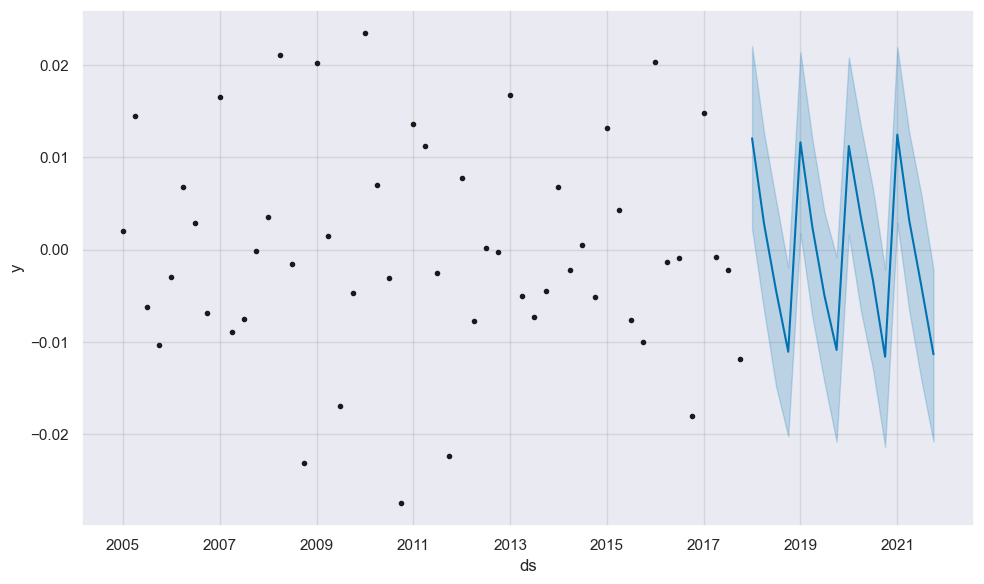

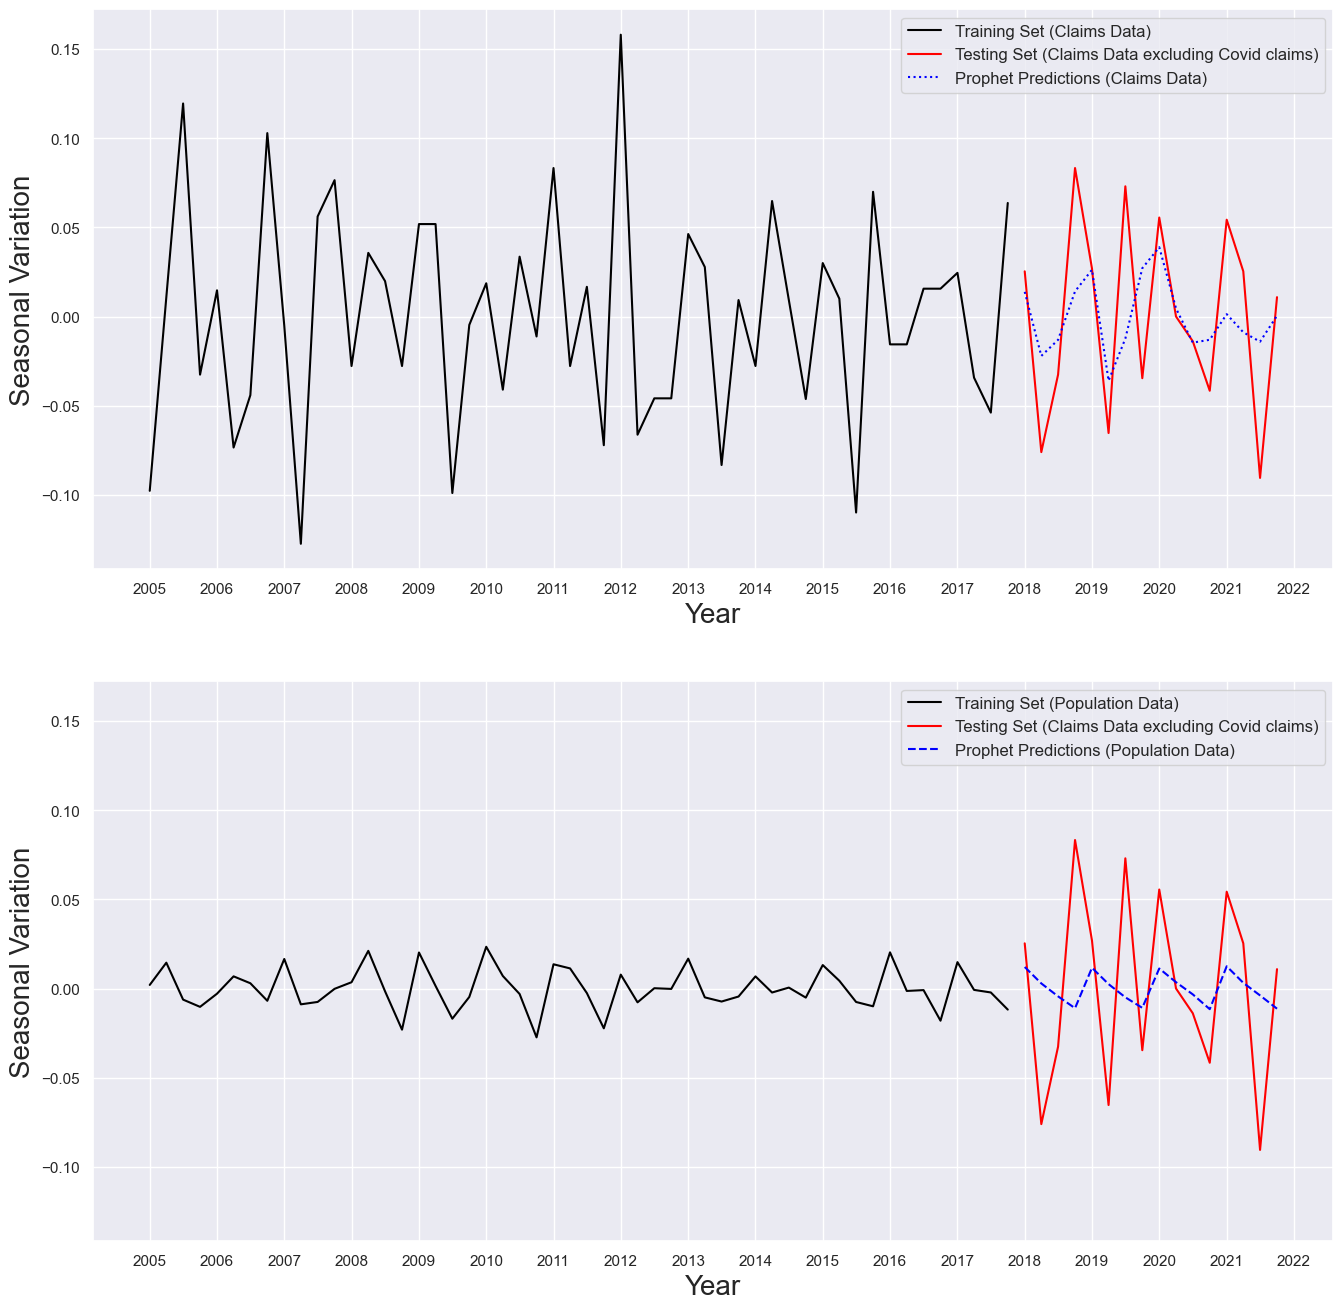

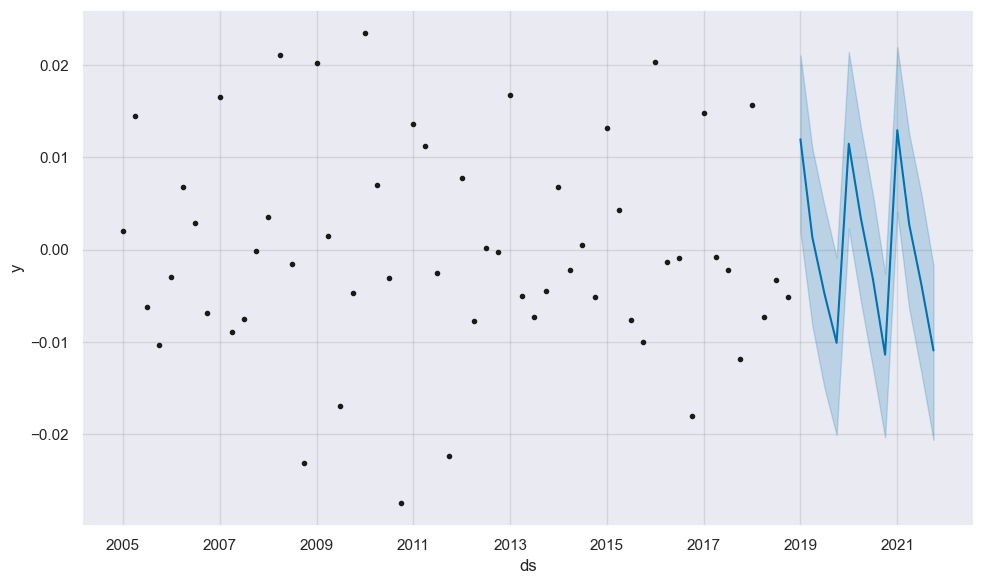

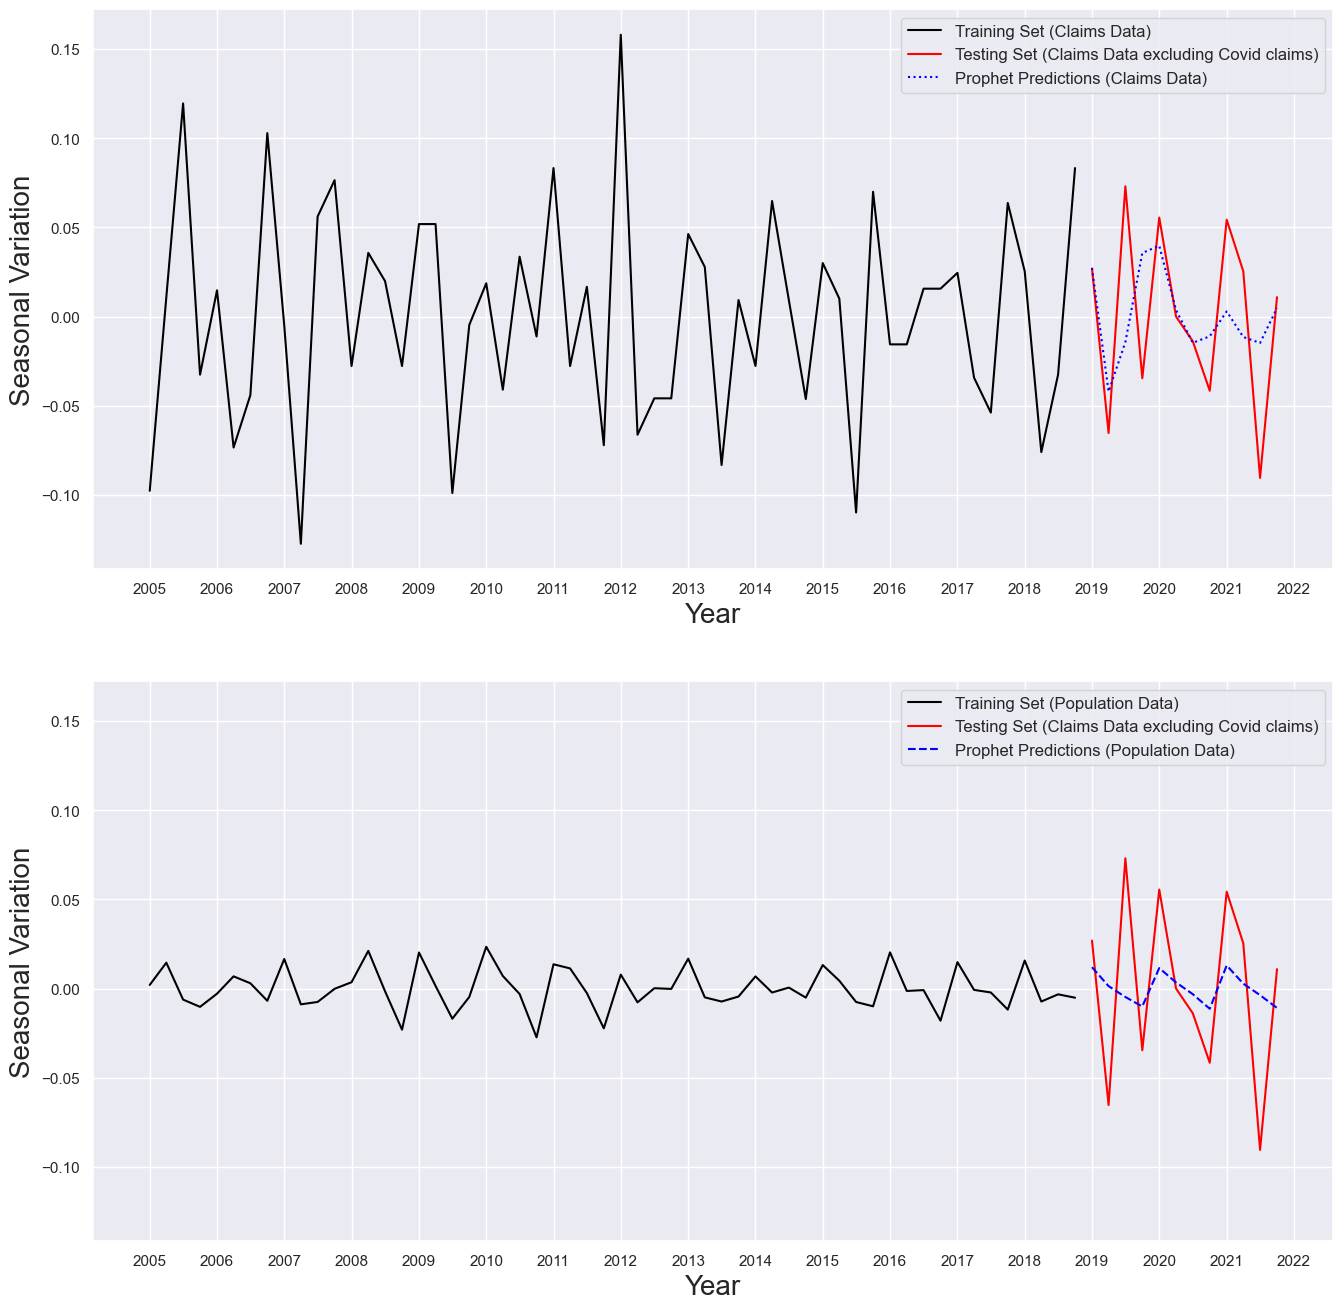

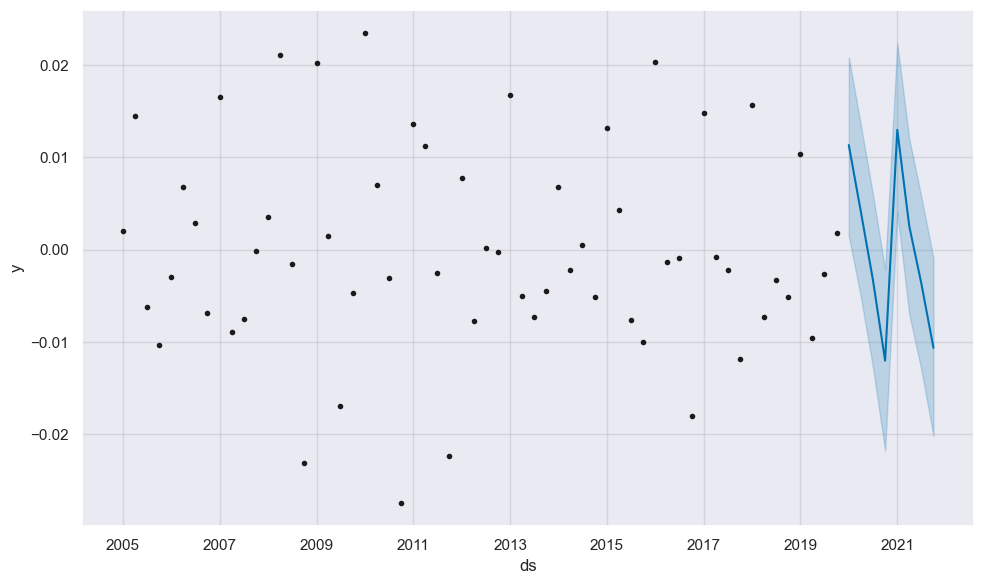

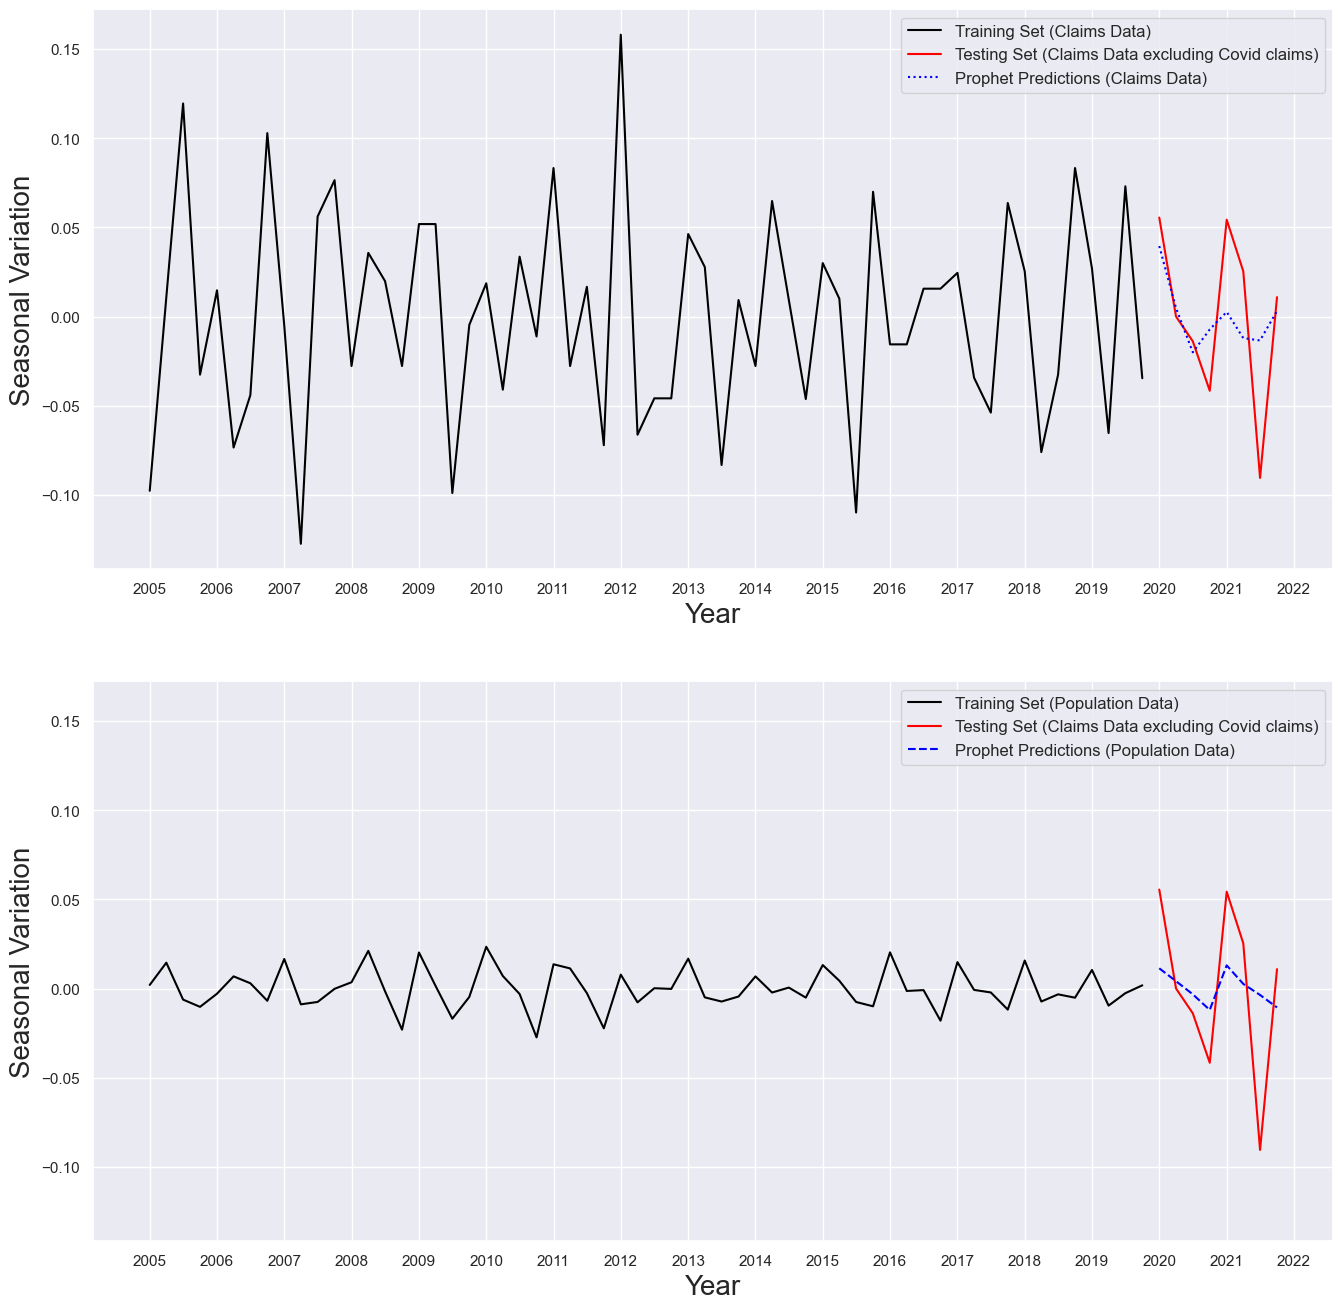

In [47]:
test_years = [4,3,2]

for i in test_years:
    df1_train = df1_SV[:-i*4]
    model = Prophet()
    model.fit(df1_train)
    future = df1_SV[-i*4:len(df1_SV)]
    future.columns = ['ds','y']
    forecast = model.predict(future)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])  # summarize the forecast
    y_pred1 = forecast[['ds','yhat']]
    y_pred1 =  y_pred1.set_index('ds')
    y_pred1.to_csv(f'Death Claim Seasonality Predictions - Prophet (Claims Data) {i} Year Test Period.csv',index=False)
               
    df2_train = df2_SV[:-i*4]
    model = Prophet()
    model.fit(df2_train)
    forecast = model.predict(future)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])  # summarize the forecast
    model.plot(forecast) # plot forecast
    y_pred2 = forecast[['ds','yhat']]
    y_pred2 =  y_pred2.set_index('ds')
    y_pred2.to_csv(f'Death Claim Seasonality Predictions - Prophet (Population Data) {i} Year Test Period.csv',index=False)
    
    training_data1 = df1_train.set_index('ds')
    training_data2 = df2_train.set_index('ds')
    testing_data = df1_SV[-i*4:len(df1_SV)]
    testing_data = testing_data .set_index('ds')
    testing_data_excovid = df3.loc[:,'CLAIMS SEASONAL VARIATION EX COVID']                               
    testing_data_excovid = pd.DataFrame(testing_data_excovid)                         
    testing_data_excovid.reset_index(inplace=True)
    testing_data_excovid.columns = ['ds','y']
    testing_data_excovid['ds'] = to_datetime(testing_data_excovid['ds'])
    testing_data_excovid = testing_data_excovid.set_index('ds') 
    testing_data_excovid = testing_data_excovid[-i*4:len(testing_data_excovid)]       
   
    plot_results(i, model_name, y_pred1, y_pred2)
    
    y_pred1 = y_pred1.rename(columns={'yhat': 'Predictions'})
    y_pred2 = y_pred2.rename(columns={'yhat': 'Predictions'})
    
    exec(f'{model_name}_claims_mae_{i}y = mean_absolute_error(testing_data.values, y_pred1["Predictions"])')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_mae_{i}y = mean_absolute_error(testing_data.values, y_pred2["Predictions"])')#calculate and save MAE for population training data
    exec(f'{model_name}_claims_rmse_{i}y = np.sqrt(mean_squared_error(testing_data.values, y_pred1["Predictions"]))')#calculate and save MAE for claims training data
    exec(f'{model_name}_pop_rmse_{i}y= np.sqrt(mean_squared_error(testing_data.values, y_pred2["Predictions"]))')#calculate and save MAE for RMSE for population training data
    exec(f'{model_name}_claims_r2_{i}y = r2_score(testing_data.values, y_pred1["Predictions"])')#calculate and save Rsquared for claims training data
    exec(f'{model_name}_pop_r2_{i}y= r2_score(testing_data.values, y_pred2["Predictions"])')#calculate and save Rsquared for population training data
    #Repeat exercise above for Death Claims Testing Data excluding Covid-19 claims
    exec(f'{model_name}_claims_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_mae_{i}y_excovid = mean_absolute_error(testing_data_excovid.values, y_pred2["Predictions"])')
    exec(f'{model_name}_claims_rmse_{i}y_excovid = np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred1["Predictions"]))')
    exec(f'{model_name}_pop_rmse_{i}y_excovid= np.sqrt(mean_squared_error(testing_data_excovid.values, y_pred2["Predictions"]))')
    exec(f'{model_name}_claims_r2_{i}y_excovid = r2_score(testing_data_excovid.values, y_pred1["Predictions"])')
    exec(f'{model_name}_pop_r2_{i}y_excovid= r2_score(testing_data_excovid.values, y_pred2["Predictions"])')
                      
    
               

## Summarise Results

### Model Results including Covid-19 Claims

In [48]:
df_full_evaluation_inc_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_full_evaluation_inc_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_full_evaluation_inc_covid['MAE (4 Year Testing Period)'] = [BL_mae_4y, HA_claims_mae_4y,HA_pop_mae_4y,SARIMA_claims_mae_4y,SARIMA_pop_mae_4y,RF_claims_mae_4y,RF_pop_mae_4y,LSTM_claims_mae_4y,LSTM_pop_mae_4y,Prophet_claims_mae_4y,Prophet_pop_mae_4y]
df_full_evaluation_inc_covid['MAE (3 Year Testing Period)'] = [BL_mae_3y,HA_claims_mae_3y,HA_pop_mae_3y,SARIMA_claims_mae_3y,SARIMA_pop_mae_3y,RF_claims_mae_3y,RF_pop_mae_3y,LSTM_claims_mae_3y,LSTM_pop_mae_3y,Prophet_claims_mae_3y,Prophet_pop_mae_3y]
df_full_evaluation_inc_covid['MAE (2 Year Testing Period)'] = [BL_mae_2y,HA_claims_mae_2y,HA_pop_mae_2y, SARIMA_claims_mae_2y,SARIMA_pop_mae_2y,RF_claims_mae_2y,RF_pop_mae_2y,LSTM_claims_mae_2y,LSTM_pop_mae_2y,Prophet_claims_mae_2y,Prophet_pop_mae_2y]
df_full_evaluation_inc_covid['MAE (Average)'] = (df_full_evaluation_inc_covid['MAE (4 Year Testing Period)'] + df_full_evaluation_inc_covid['MAE (3 Year Testing Period)'] + df_full_evaluation_inc_covid['MAE (2 Year Testing Period)'])/3
df_full_evaluation_inc_covid['RMSE (4 Year Testing Period)'] = [BL_rmse_4y,HA_claims_rmse_4y,HA_pop_rmse_4y,SARIMA_claims_rmse_4y,SARIMA_pop_rmse_4y,RF_claims_rmse_4y,RF_pop_rmse_4y,LSTM_claims_rmse_4y,LSTM_pop_rmse_4y,Prophet_claims_rmse_4y,Prophet_pop_rmse_4y]
df_full_evaluation_inc_covid['RMSE (3 Year Testing Period)'] = [BL_rmse_3y,HA_claims_rmse_3y,HA_pop_rmse_3y,SARIMA_claims_rmse_3y,SARIMA_pop_rmse_3y,RF_claims_rmse_3y,RF_pop_rmse_3y,LSTM_claims_rmse_3y,LSTM_pop_rmse_3y,Prophet_claims_rmse_3y,Prophet_pop_rmse_3y]
df_full_evaluation_inc_covid['RMSE (2 Year Testing Period)'] = [BL_rmse_2y,HA_claims_rmse_2y,HA_pop_rmse_2y, SARIMA_claims_rmse_2y,SARIMA_pop_rmse_2y,RF_claims_rmse_2y,RF_pop_rmse_2y,LSTM_claims_rmse_2y,LSTM_pop_rmse_2y,Prophet_claims_rmse_2y,Prophet_pop_rmse_2y]
df_full_evaluation_inc_covid['RMSE (Average)'] = (df_full_evaluation_inc_covid['RMSE (4 Year Testing Period)'] + df_full_evaluation_inc_covid['RMSE (3 Year Testing Period)'] + df_full_evaluation_inc_covid['RMSE (2 Year Testing Period)'])/3
df_full_evaluation_inc_covid['R2 (4 Year Testing Period)'] = [BL_r2_4y,HA_claims_r2_4y,HA_pop_r2_4y,SARIMA_claims_r2_4y,SARIMA_pop_r2_4y,RF_claims_r2_4y,RF_pop_r2_4y,LSTM_claims_r2_4y,LSTM_pop_r2_4y,Prophet_claims_r2_4y,Prophet_pop_r2_4y]
df_full_evaluation_inc_covid['R2 (3 Year Testing Period)'] = [BL_r2_3y,HA_claims_r2_3y,HA_pop_r2_3y,SARIMA_claims_r2_3y,SARIMA_pop_r2_3y,RF_claims_r2_3y,RF_pop_r2_3y,LSTM_claims_r2_3y,LSTM_pop_r2_3y,Prophet_claims_r2_3y,Prophet_pop_r2_3y]
df_full_evaluation_inc_covid['R2 (2 Year Testing Period)'] = [BL_r2_2y,HA_claims_r2_2y,HA_pop_r2_2y,SARIMA_claims_r2_2y,SARIMA_pop_r2_2y,RF_claims_r2_2y,RF_pop_r2_2y,LSTM_claims_r2_2y,LSTM_pop_r2_2y,Prophet_claims_r2_2y,Prophet_pop_r2_2y]
df_full_evaluation_inc_covid['R2 (Average)'] = (df_full_evaluation_inc_covid['R2 (4 Year Testing Period)'] + df_full_evaluation_inc_covid['R2 (3 Year Testing Period)'] + df_full_evaluation_inc_covid['R2 (2 Year Testing Period)'])/3
df_full_evaluation_inc_covid = df_full_evaluation_inc_covid.set_index('Model')
df_full_evaluation_inc_covid.to_csv(f"Death Claim Seasonality Predictions Evaluation Summary - including Covid claims.csv", index=True)
df_full_evaluation_inc_covid

MAE (4 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.046686   
Historical Average (Claims Data)                         0.040219   
Historical Average (Population Data)                     0.043181   
SARIMA (Claims Data))                                    0.045686   
SARIMA (Population Data)                                 0.042144   
Random Forest (Claims Data)                              0.040137   
Random Forest (Population Data)                          0.043157   
LSTM (Claims Data)                                       0.047789   
LSTM (Population Data)                                   0.045030   
Prophet (Claims Data)                                    0.036424   
Prophet (Population Data)                                0.043213   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.044132   
Historical Average (Claims Data)                         0.040603   
Historical Average (Population Data)                     0.039643   
SARIMA (Claims Data))                                    0.046202   
SARIMA (Population Data)                                 0.039229   
Random Forest (Claims Data)                              0.040531   
Random Forest (Population Data)                          0.039616   
LSTM (Claims Data)                                       0.047084   
LSTM (Population Data)                                   0.042484   
Prophet (Claims Data)                                    0.035892   
Prophet (Population Data)                                0.039640   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.041197   
Historical Average (Claims Data)                         0.039458   
Historical Average (Population Data)                     0.036795   
SARIMA (Claims Data))                                    0.044082   
SARIMA (Population Data)                                 0.037934   
Random Forest (Claims Data)                              0.039258   
Random Forest (Population Data)                          0.036768   
LSTM (Claims Data)                                       0.048290   
LSTM (Population Data)                                   0.043321   
Prophet (Claims Data)                                    0.031362   
Prophet (Population Data)                                0.036285   

                                      MAE (Average)  \
Model                                                 
Baseline Model                             0.044005   
Historical Average (Claims Data)           0.040093   
Historical Average (Population Data)       0.039873   
SARIMA (Claims Data))                      0.045324   
SARIMA (Population Data)                   0.039769   
Random Forest (Claims Data)                0.039975   
Random Forest (Population Data)            0.039847   
LSTM (Claims Data)                         0.047721   
LSTM (Population Data)                     0.043612   
Prophet (Claims Data)                      0.034559   
Prophet (Population Data)                  0.039713   

                                      RMSE (4 Year Testing Period)  \
Model                                                                
Baseline Model                                            0.052902   
Historical Average (Claims Data)                          0.048141   
Historical Average (Population Data)                      0.051558   
SARIMA (Claims Data))                                     0.051908   
SARIMA (Population Data)                                  0.049784   
Random Forest (Claims Data)                               0.048134   
Random Forest (Population Data)                           0.051545  

In [49]:
df_mae_inc_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_mae_inc_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_mae_inc_covid['MAE (4 Year Testing Period)'] = [BL_mae_4y, HA_claims_mae_4y,HA_pop_mae_4y,SARIMA_claims_mae_4y,SARIMA_pop_mae_4y,RF_claims_mae_4y,RF_pop_mae_4y,LSTM_claims_mae_4y,LSTM_pop_mae_4y,Prophet_claims_mae_4y,Prophet_pop_mae_4y]
df_mae_inc_covid['MAE (3 Year Testing Period)'] = [BL_mae_3y,HA_claims_mae_3y,HA_pop_mae_3y,SARIMA_claims_mae_3y,SARIMA_pop_mae_3y,RF_claims_mae_3y,RF_pop_mae_3y,LSTM_claims_mae_3y,LSTM_pop_mae_3y,Prophet_claims_mae_3y,Prophet_pop_mae_3y]
df_mae_inc_covid['MAE (2 Year Testing Period)'] = [BL_mae_2y,HA_claims_mae_2y,HA_pop_mae_2y, SARIMA_claims_mae_2y,SARIMA_pop_mae_2y,RF_claims_mae_2y,RF_pop_mae_2y,LSTM_claims_mae_2y,LSTM_pop_mae_2y,Prophet_claims_mae_2y,Prophet_pop_mae_2y]
df_mae_inc_covid['MAE (Average)'] = (df_mae_inc_covid['MAE (4 Year Testing Period)'] + df_mae_inc_covid['MAE (3 Year Testing Period)'] + df_mae_inc_covid['MAE (2 Year Testing Period)'])/3
df_mae_inc_covid = df_mae_inc_covid.set_index('Model')
df_mae_inc_covid.sort_values(by='MAE (Average)', ascending=True)

MAE (4 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.036424   
Prophet (Population Data)                                0.043213   
SARIMA (Population Data)                                 0.042144   
Random Forest (Population Data)                          0.043157   
Historical Average (Population Data)                     0.043181   
Random Forest (Claims Data)                              0.040137   
Historical Average (Claims Data)                         0.040219   
LSTM (Population Data)                                   0.045030   
Baseline Model                                           0.046686   
SARIMA (Claims Data))                                    0.045686   
LSTM (Claims Data)                                       0.047789   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.035892   
Prophet (Population Data)                                0.039640   
SARIMA (Population Data)                                 0.039229   
Random Forest (Population Data)                          0.039616   
Historical Average (Population Data)                     0.039643   
Random Forest (Claims Data)                              0.040531   
Historical Average (Claims Data)                         0.040603   
LSTM (Population Data)                                   0.042484   
Baseline Model                                           0.044132   
SARIMA (Claims Data))                                    0.046202   
LSTM (Claims Data)                                       0.047084   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.031362   
Prophet (Population Data)                                0.036285   
SARIMA (Population Data)                                 0.037934   
Random Forest (Population Data)                          0.036768   
Historical Average (Population Data)                     0.036795   
Random Forest (Claims Data)                              0.039258   
Historical Average (Claims Data)                         0.039458   
LSTM (Population Data)                                   0.043321   
Baseline Model                                           0.041197   
SARIMA (Claims Data))                                    0.044082   
LSTM (Claims Data)                                       0.048290   

                                      MAE (Average)  
Model                                                
Prophet (Claims Data)                      0.034559  
Prophet (Population Data)                  0.039713  
SARIMA (Population Data)                   0.039769  
Random Forest (Population Data)            0.039847  
Historical Average (Population Data)       0.039873  
Random Forest (Claims Data)                0.039975  
Historical Average (Claims Data)           0.040093  
LSTM (Population Data)                     0.043612  
Baseline Model                             0.044005  
SARIMA (Claims Data))                      0.045324  
LSTM (Claims Data)                         0.047721

In [50]:
HA_claims_mae_4y

0.04021863811128014

In [51]:
df_rmse_inc_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_rmse_inc_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_rmse_inc_covid['RMSE (4 Year Testing Period)'] = [BL_rmse_4y,HA_claims_rmse_4y,HA_pop_rmse_4y,SARIMA_claims_rmse_4y,SARIMA_pop_rmse_4y,RF_claims_rmse_4y,RF_pop_rmse_4y,LSTM_claims_rmse_4y,LSTM_pop_rmse_4y,Prophet_claims_rmse_4y,Prophet_pop_rmse_4y]
df_rmse_inc_covid['RMSE (3 Year Testing Period)'] = [BL_rmse_3y,HA_claims_rmse_3y,HA_pop_rmse_3y,SARIMA_claims_rmse_3y,SARIMA_pop_rmse_3y,RF_claims_rmse_3y,RF_pop_rmse_3y,LSTM_claims_rmse_3y,LSTM_pop_rmse_3y,Prophet_claims_rmse_3y,Prophet_pop_rmse_3y]
df_rmse_inc_covid['RMSE (2 Year Testing Period)'] = [BL_rmse_2y,HA_claims_rmse_2y,HA_pop_rmse_2y, SARIMA_claims_rmse_2y,SARIMA_pop_rmse_2y,RF_claims_rmse_2y,RF_pop_rmse_2y,LSTM_claims_rmse_2y,LSTM_pop_rmse_2y,Prophet_claims_rmse_2y,Prophet_pop_rmse_2y]
df_rmse_inc_covid['RMSE (Average)'] = (df_rmse_inc_covid['RMSE (4 Year Testing Period)'] + df_rmse_inc_covid['RMSE (3 Year Testing Period)'] + df_rmse_inc_covid['RMSE (2 Year Testing Period)'])/3
df_rmse_inc_covid = df_rmse_inc_covid.set_index('Model')
df_rmse_inc_covid.sort_values(by='RMSE (Average)', ascending=True)

RMSE (4 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.045472   
SARIMA (Population Data)                                  0.049784   
Prophet (Population Data)                                 0.051570   
Random Forest (Population Data)                           0.051545   
Historical Average (Population Data)                      0.051558   
Random Forest (Claims Data)                               0.048134   
Historical Average (Claims Data)                          0.048141   
LSTM (Population Data)                                    0.051879   
Baseline Model                                            0.052902   
SARIMA (Claims Data))                                     0.051908   
LSTM (Claims Data)                                        0.053286   

                                      RMSE (3 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.046541   
SARIMA (Population Data)                                  0.046367   
Prophet (Population Data)                                 0.046802   
Random Forest (Population Data)                           0.046784   
Historical Average (Population Data)                      0.046803   
Random Forest (Claims Data)                               0.048600   
Historical Average (Claims Data)                          0.048610   
LSTM (Population Data)                                    0.048225   
Baseline Model                                            0.050280   
SARIMA (Claims Data))                                     0.052073   
LSTM (Claims Data)                                        0.052589   

                                      RMSE (2 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.040981   
SARIMA (Population Data)                                  0.043644   
Prophet (Population Data)                                 0.043152   
Random Forest (Population Data)                           0.043425   
Historical Average (Population Data)                      0.043450   
Random Forest (Claims Data)                               0.046642   
Historical Average (Claims Data)                          0.046764   
LSTM (Population Data)                                    0.047952   
Baseline Model                                            0.048475   
SARIMA (Claims Data))                                     0.053812   
LSTM (Claims Data)                                        0.054311   

                                      RMSE (Average)  
Model                                                 
Prophet (Claims Data)                       0.044332  
SARIMA (Population Data)                    0.046599  
Prophet (Population Data)                   0.047175  
Random Forest (Population Data)             0.047251  
Historical Average (Population Data)        0.047270  
Random Forest (Claims Data)                 0.047792  
Historical Average (Claims Data)            0.047838  
LSTM (Population Data)                      0.049352  
Baseline Model                              0.050553  
SARIMA (Claims Data))                       0.052597  
LSTM (Claims Data)                          0.053395

In [52]:
df_r2_inc_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_r2_inc_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_r2_inc_covid['R2 (4 Year Testing Period)'] = [BL_r2_4y,HA_claims_r2_4y,HA_pop_r2_4y,SARIMA_claims_r2_4y,SARIMA_pop_r2_4y,RF_claims_r2_4y,RF_pop_r2_4y,LSTM_claims_r2_4y,LSTM_pop_r2_4y,Prophet_claims_r2_4y,Prophet_pop_r2_4y]
df_r2_inc_covid['R2 (3 Year Testing Period)'] = [BL_r2_3y,HA_claims_r2_3y,HA_pop_r2_3y,SARIMA_claims_r2_3y,SARIMA_pop_r2_3y,RF_claims_r2_3y,RF_pop_r2_3y,LSTM_claims_r2_3y,LSTM_pop_r2_3y,Prophet_claims_r2_3y,Prophet_pop_r2_3y]
df_r2_inc_covid['R2 (2 Year Testing Period)'] = [BL_r2_2y,HA_claims_r2_2y,HA_pop_r2_2y,SARIMA_claims_r2_2y,SARIMA_pop_r2_2y,RF_claims_r2_2y,RF_pop_r2_2y,LSTM_claims_r2_2y,LSTM_pop_r2_2y,Prophet_claims_r2_2y,Prophet_pop_r2_2y]
df_r2_inc_covid['R2 (Average)'] = (df_r2_inc_covid['R2 (4 Year Testing Period)'] + df_r2_inc_covid['R2 (3 Year Testing Period)'] + df_r2_inc_covid['R2 (2 Year Testing Period)'])/3
df_r2_inc_covid = df_r2_inc_covid.set_index('Model')
df_r2_inc_covid.sort_values(by='R2 (Average)', ascending=True)

R2 (4 Year Testing Period)  \
Model                                                              
LSTM (Claims Data)                                     -0.014563   
SARIMA (Claims Data))                                   0.037232   
Baseline Model                                          0.000000   
LSTM (Population Data)                                  0.038289   
Historical Average (Claims Data)                        0.171890   
Random Forest (Claims Data)                             0.172145   
Historical Average (Population Data)                    0.050142   
Random Forest (Population Data)                         0.050623   
Prophet (Population Data)                               0.049702   
SARIMA (Population Data)                                0.114392   
Prophet (Claims Data)                                   0.261163   

                                      R2 (3 Year Testing Period)  \
Model                                                              
LSTM (Claims Data)                                     -0.093933   
SARIMA (Claims Data))                                  -0.072568   
Baseline Model                                          0.000000   
LSTM (Population Data)                                  0.080087   
Historical Average (Claims Data)                        0.065354   
Random Forest (Claims Data)                             0.065727   
Historical Average (Population Data)                    0.133533   
Random Forest (Population Data)                         0.134246   
Prophet (Population Data)                               0.133588   
SARIMA (Population Data)                                0.149588   
Prophet (Claims Data)                                   0.143204   

                                      R2 (2 Year Testing Period)  R2 (Average)  
Model                                                                           
LSTM (Claims Data)                                     -0.255245     -0.121247  
SARIMA (Claims Data))                                  -0.232287     -0.089208  
Baseline Model                                          0.000000      0.000000  
LSTM (Population Data)                                  0.021484      0.046620  
Historical Average (Claims Data)                        0.069344      0.102196  
Random Forest (Claims Data)                             0.074193      0.104022  
Historical Average (Population Data)                    0.196609      0.126761  
Random Forest (Population Data)                         0.197506      0.127458  
Prophet (Population Data)                               0.207587      0.130292  
SARIMA (Population Data)                                0.189393      0.151125  
Prophet (Claims Data)                                   0.285285      0.229884

In [53]:
df_AICBIC = pd.DataFrame()
df_AICBIC['Model'] = ['SARIMA (Claims Data)', 'SARIMA (Population Data)']
df_AICBIC['AIC (4 Year Testing Period)'] = [SARIMA_claims_aic_4y,SARIMA_pop_aic_4y]
df_AICBIC['AIC (3 Year Testing Period)'] = [SARIMA_claims_aic_3y,SARIMA_pop_aic_3y]
df_AICBIC['AIC (2 Year Testing Period)'] = [SARIMA_claims_aic_2y,SARIMA_pop_aic_2y]
df_AICBIC['AIC (Average)'] = (df_AICBIC['AIC (4 Year Testing Period)'] +df_AICBIC['AIC (3 Year Testing Period)']+df_AICBIC['AIC (2 Year Testing Period)'])/3
df_AICBIC['BIC (4 Year Testing Period)'] = [SARIMA_claims_bic_4y,SARIMA_pop_bic_4y]
df_AICBIC['BIC (3 Year Testing Period)'] = [SARIMA_claims_bic_3y,SARIMA_pop_bic_3y]
df_AICBIC['BIC (2 Year Testing Period)'] = [SARIMA_claims_bic_2y,SARIMA_pop_bic_2y]
df_AICBIC['BIC (Average)'] = (df_AICBIC['BIC (4 Year Testing Period)']+df_AICBIC['BIC (3 Year Testing Period)']+df_AICBIC['BIC (2 Year Testing Period)'])/3
df_AICBIC = df_AICBIC.set_index('Model')
df_AICBIC



AIC (4 Year Testing Period)  \
Model                                                   
SARIMA (Claims Data)                      -157.062142   
SARIMA (Population Data)                  -243.669998   

                          AIC (3 Year Testing Period)  \
Model                                                   
SARIMA (Claims Data)                      -171.083221   
SARIMA (Population Data)                  -273.116255   

                          AIC (2 Year Testing Period)  AIC (Average)  \
Model                                                                  
SARIMA (Claims Data)                      -185.691398    -171.278920   
SARIMA (Population Data)                  -297.091119    -271.292457   

                          BIC (4 Year Testing Period)  \
Model                                                   
SARIMA (Claims Data)                      -147.305923   
SARIMA (Population Data)                  -235.352190   

                          BIC (3 Year Testing Period)  \
Model                                                   
SARIMA (Claims Data)                      -160.956463   
SARIMA (Population Data)                  -264.310254   

                          BIC (2 Year Testing Period)  BIC (Average)  
Model                                                                 
SARIMA (Claims Data)                      -175.219676    -161.160687  
SARIMA (Population Data)                  -287.840381    -262.500942

### Model Results excluding Covid 19 Claims

In [54]:
df_full_evaluation_ex_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_full_evaluation_ex_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_full_evaluation_ex_covid['MAE (4 Year Testing Period)'] = [BL_mae_4y_excovid, HA_claims_mae_4y_excovid,HA_pop_mae_4y_excovid,SARIMA_claims_mae_4y_excovid,SARIMA_pop_mae_4y_excovid,RF_claims_mae_4y_excovid,RF_pop_mae_4y_excovid,LSTM_claims_mae_4y_excovid,LSTM_pop_mae_4y_excovid,Prophet_claims_mae_4y_excovid,Prophet_pop_mae_4y_excovid]
df_full_evaluation_ex_covid['MAE (3 Year Testing Period)'] = [BL_mae_3y_excovid,HA_claims_mae_3y_excovid,HA_pop_mae_3y_excovid,SARIMA_claims_mae_3y_excovid,SARIMA_pop_mae_3y_excovid,RF_claims_mae_3y_excovid,RF_pop_mae_3y_excovid,LSTM_claims_mae_3y_excovid,LSTM_pop_mae_3y_excovid,Prophet_claims_mae_3y_excovid,Prophet_pop_mae_3y_excovid]
df_full_evaluation_ex_covid['MAE (2 Year Testing Period)'] = [BL_mae_2y_excovid,HA_claims_mae_2y_excovid,HA_pop_mae_2y_excovid, SARIMA_claims_mae_2y_excovid,SARIMA_pop_mae_2y_excovid,RF_claims_mae_2y_excovid,RF_pop_mae_2y_excovid,LSTM_claims_mae_2y_excovid,LSTM_pop_mae_2y_excovid,Prophet_claims_mae_2y_excovid,Prophet_pop_mae_2y_excovid]
df_full_evaluation_ex_covid['MAE (Average)'] = (df_full_evaluation_ex_covid['MAE (4 Year Testing Period)'] + df_full_evaluation_ex_covid['MAE (3 Year Testing Period)'] + df_full_evaluation_ex_covid['MAE (2 Year Testing Period)'])/3
df_full_evaluation_ex_covid['RMSE (4 Year Testing Period)'] = [BL_rmse_4y_excovid,HA_claims_rmse_4y_excovid,HA_pop_rmse_4y_excovid,SARIMA_claims_rmse_4y_excovid,SARIMA_pop_rmse_4y_excovid,RF_claims_rmse_4y_excovid,RF_pop_rmse_4y_excovid,LSTM_claims_rmse_4y_excovid,LSTM_pop_rmse_4y_excovid,Prophet_claims_rmse_4y_excovid,Prophet_pop_rmse_4y_excovid]
df_full_evaluation_ex_covid['RMSE (3 Year Testing Period)'] = [BL_rmse_3y_excovid,HA_claims_rmse_3y_excovid,HA_pop_rmse_3y_excovid,SARIMA_claims_rmse_3y_excovid,SARIMA_pop_rmse_3y_excovid,RF_claims_rmse_3y_excovid,RF_pop_rmse_3y_excovid,LSTM_claims_rmse_3y_excovid,LSTM_pop_rmse_3y_excovid,Prophet_claims_rmse_3y_excovid,Prophet_pop_rmse_3y_excovid]
df_full_evaluation_ex_covid['RMSE (2 Year Testing Period)'] = [BL_rmse_2y_excovid,HA_claims_rmse_2y_excovid,HA_pop_rmse_2y_excovid, SARIMA_claims_rmse_2y_excovid,SARIMA_pop_rmse_2y_excovid,RF_claims_rmse_2y_excovid,RF_pop_rmse_2y_excovid,LSTM_claims_rmse_2y_excovid,LSTM_pop_rmse_2y_excovid,Prophet_claims_rmse_2y_excovid,Prophet_pop_rmse_2y_excovid]
df_full_evaluation_ex_covid['RMSE (Average)'] = (df_full_evaluation_ex_covid['RMSE (4 Year Testing Period)'] + df_full_evaluation_ex_covid['RMSE (3 Year Testing Period)'] + df_full_evaluation_ex_covid['RMSE (2 Year Testing Period)'])/3
df_full_evaluation_ex_covid['R2 (4 Year Testing Period)'] = [BL_r2_4y_excovid,HA_claims_r2_4y_excovid,HA_pop_r2_4y_excovid,SARIMA_claims_r2_4y_excovid,SARIMA_pop_r2_4y_excovid,RF_claims_r2_4y_excovid,RF_pop_r2_4y_excovid,LSTM_claims_r2_4y_excovid,LSTM_pop_r2_4y_excovid,Prophet_claims_r2_4y_excovid,Prophet_pop_r2_4y_excovid]
df_full_evaluation_ex_covid['R2 (3 Year Testing Period)'] = [BL_r2_3y_excovid,HA_claims_r2_3y_excovid,HA_pop_r2_3y_excovid,SARIMA_claims_r2_3y_excovid,SARIMA_pop_r2_3y_excovid,RF_claims_r2_3y_excovid,RF_pop_r2_3y_excovid,LSTM_claims_r2_3y_excovid,LSTM_pop_r2_3y_excovid,Prophet_claims_r2_3y_excovid,Prophet_pop_r2_3y_excovid]
df_full_evaluation_ex_covid['R2 (2 Year Testing Period)'] = [BL_r2_2y_excovid,HA_claims_r2_2y_excovid,HA_pop_r2_2y_excovid,SARIMA_claims_r2_2y_excovid,SARIMA_pop_r2_2y_excovid,RF_claims_r2_2y_excovid,RF_pop_r2_2y_excovid,LSTM_claims_r2_2y_excovid,LSTM_pop_r2_2y_excovid,Prophet_claims_r2_2y_excovid,Prophet_pop_r2_2y_excovid]
df_full_evaluation_ex_covid['R2 (Average)'] = (df_full_evaluation_ex_covid['R2 (4 Year Testing Period)'] + df_full_evaluation_ex_covid['R2 (3 Year Testing Period)'] + df_full_evaluation_ex_covid['R2 (2 Year Testing Period)'])/3
df_full_evaluation_ex_covid = df_full_evaluation_ex_covid.set_index('Model')
df_full_evaluation_ex_covid.to_csv(f"Death Claim Seasonality Predictions Evaluation Summary - excluding Covid claims.csv", index=True)
df_full_evaluation_ex_covid

MAE (4 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.044354   
Historical Average (Claims Data)                         0.037887   
Historical Average (Population Data)                     0.041240   
SARIMA (Claims Data))                                    0.043354   
SARIMA (Population Data)                                 0.040044   
Random Forest (Claims Data)                              0.037805   
Random Forest (Population Data)                          0.041213   
LSTM (Claims Data)                                       0.045457   
LSTM (Population Data)                                   0.042812   
Prophet (Claims Data)                                    0.034758   
Prophet (Population Data)                                0.041325   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.041023   
Historical Average (Claims Data)                         0.037879   
Historical Average (Population Data)                     0.036931   
SARIMA (Claims Data))                                    0.043790   
SARIMA (Population Data)                                 0.036456   
Random Forest (Claims Data)                              0.037821   
Random Forest (Population Data)                          0.036902   
LSTM (Claims Data)                                       0.044013   
LSTM (Population Data)                                   0.039375   
Prophet (Claims Data)                                    0.033531   
Prophet (Population Data)                                0.037102   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Baseline Model                                           0.036534   
Historical Average (Claims Data)                         0.034794   
Historical Average (Population Data)                     0.032528   
SARIMA (Claims Data))                                    0.040048   
SARIMA (Population Data)                                 0.033271   
Random Forest (Claims Data)                              0.034594   
Random Forest (Population Data)                          0.032504   
LSTM (Claims Data)                                       0.045222   
LSTM (Population Data)                                   0.038657   
Prophet (Claims Data)                                    0.029427   
Prophet (Population Data)                                0.032651   

                                      MAE (Average)  \
Model                                                 
Baseline Model                             0.040637   
Historical Average (Claims Data)           0.036853   
Historical Average (Population Data)       0.036900   
SARIMA (Claims Data))                      0.042398   
SARIMA (Population Data)                   0.036590   
Random Forest (Claims Data)                0.036740   
Random Forest (Population Data)            0.036873   
LSTM (Claims Data)                         0.044898   
LSTM (Population Data)                     0.040281   
Prophet (Claims Data)                      0.032572   
Prophet (Population Data)                  0.037026   

                                      RMSE (4 Year Testing Period)  \
Model                                                                
Baseline Model                                            0.051789   
Historical Average (Claims Data)                          0.046495   
Historical Average (Population Data)                      0.050500   
SARIMA (Claims Data))                                     0.050503   
SARIMA (Population Data)                                  0.048681   
Random Forest (Claims Data)                               0.046490   
Random Forest (Population Data)                           0.050485  

In [55]:
df_mae_ex_covid = pd.DataFrame()
# append columns to an empty DataFrame
# append columns to an empty DataFrame
df_mae_ex_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_mae_ex_covid['MAE (4 Year Testing Period)'] = [BL_mae_4y_excovid, HA_claims_mae_4y_excovid,HA_pop_mae_4y_excovid,SARIMA_claims_mae_4y_excovid,SARIMA_pop_mae_4y_excovid,RF_claims_mae_4y_excovid,RF_pop_mae_4y_excovid,LSTM_claims_mae_4y_excovid,LSTM_pop_mae_4y_excovid,Prophet_claims_mae_4y_excovid,Prophet_pop_mae_4y_excovid]
df_mae_ex_covid['MAE (3 Year Testing Period)'] = [BL_mae_3y_excovid,HA_claims_mae_3y_excovid,HA_pop_mae_3y_excovid,SARIMA_claims_mae_3y_excovid,SARIMA_pop_mae_3y_excovid,RF_claims_mae_3y_excovid,RF_pop_mae_3y_excovid,LSTM_claims_mae_3y_excovid,LSTM_pop_mae_3y_excovid,Prophet_claims_mae_3y_excovid,Prophet_pop_mae_3y_excovid]
df_mae_ex_covid['MAE (2 Year Testing Period)'] = [BL_mae_2y_excovid,HA_claims_mae_2y_excovid,HA_pop_mae_2y_excovid, SARIMA_claims_mae_2y_excovid,SARIMA_pop_mae_2y_excovid,RF_claims_mae_2y_excovid,RF_pop_mae_2y_excovid,LSTM_claims_mae_2y_excovid,LSTM_pop_mae_2y_excovid,Prophet_claims_mae_2y_excovid,Prophet_pop_mae_2y_excovid]
df_mae_ex_covid['MAE (Average)'] = (df_mae_ex_covid['MAE (4 Year Testing Period)'] + df_mae_ex_covid['MAE (3 Year Testing Period)'] + df_mae_ex_covid['MAE (2 Year Testing Period)'])/3
df_mae_ex_covid = df_mae_ex_covid.set_index('Model')
df_mae_ex_covid.sort_values (by ='MAE (Average)')

MAE (4 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.034758   
SARIMA (Population Data)                                 0.040044   
Random Forest (Claims Data)                              0.037805   
Historical Average (Claims Data)                         0.037887   
Random Forest (Population Data)                          0.041213   
Historical Average (Population Data)                     0.041240   
Prophet (Population Data)                                0.041325   
LSTM (Population Data)                                   0.042812   
Baseline Model                                           0.044354   
SARIMA (Claims Data))                                    0.043354   
LSTM (Claims Data)                                       0.045457   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.033531   
SARIMA (Population Data)                                 0.036456   
Random Forest (Claims Data)                              0.037821   
Historical Average (Claims Data)                         0.037879   
Random Forest (Population Data)                          0.036902   
Historical Average (Population Data)                     0.036931   
Prophet (Population Data)                                0.037102   
LSTM (Population Data)                                   0.039375   
Baseline Model                                           0.041023   
SARIMA (Claims Data))                                    0.043790   
LSTM (Claims Data)                                       0.044013   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Prophet (Claims Data)                                    0.029427   
SARIMA (Population Data)                                 0.033271   
Random Forest (Claims Data)                              0.034594   
Historical Average (Claims Data)                         0.034794   
Random Forest (Population Data)                          0.032504   
Historical Average (Population Data)                     0.032528   
Prophet (Population Data)                                0.032651   
LSTM (Population Data)                                   0.038657   
Baseline Model                                           0.036534   
SARIMA (Claims Data))                                    0.040048   
LSTM (Claims Data)                                       0.045222   

                                      MAE (Average)  
Model                                                
Prophet (Claims Data)                      0.032572  
SARIMA (Population Data)                   0.036590  
Random Forest (Claims Data)                0.036740  
Historical Average (Claims Data)           0.036853  
Random Forest (Population Data)            0.036873  
Historical Average (Population Data)       0.036900  
Prophet (Population Data)                  0.037026  
LSTM (Population Data)                     0.040281  
Baseline Model                             0.040637  
SARIMA (Claims Data))                      0.042398  
LSTM (Claims Data)                         0.044898

In [56]:
df_rmse_ex_covid = pd.DataFrame()
# append columns to an empty DataFrame
df_rmse_ex_covid['Model'] = ['Baseline Model', 'Historical Average (Claims Data)','Historical Average (Population Data)','SARIMA (Claims Data))', 'SARIMA (Population Data)','Random Forest (Claims Data)', 'Random Forest (Population Data)','LSTM (Claims Data)', 'LSTM (Population Data)','Prophet (Claims Data)', 'Prophet (Population Data)']
df_rmse_ex_covid['RMSE (4 Year Testing Period)'] = [BL_rmse_4y_excovid,HA_claims_rmse_4y_excovid,HA_pop_rmse_4y_excovid,SARIMA_claims_rmse_4y_excovid,SARIMA_pop_rmse_4y_excovid,RF_claims_rmse_4y_excovid,RF_pop_rmse_4y_excovid,LSTM_claims_rmse_4y_excovid,LSTM_pop_rmse_4y_excovid,Prophet_claims_rmse_4y_excovid,Prophet_pop_rmse_4y_excovid]
df_rmse_ex_covid['RMSE (3 Year Testing Period)'] = [BL_rmse_3y_excovid,HA_claims_rmse_3y_excovid,HA_pop_rmse_3y_excovid,SARIMA_claims_rmse_3y_excovid,SARIMA_pop_rmse_3y_excovid,RF_claims_rmse_3y_excovid,RF_pop_rmse_3y_excovid,LSTM_claims_rmse_3y_excovid,LSTM_pop_rmse_3y_excovid,Prophet_claims_rmse_3y_excovid,Prophet_pop_rmse_3y_excovid]
df_rmse_ex_covid['RMSE (2 Year Testing Period)'] = [BL_rmse_2y_excovid,HA_claims_rmse_2y_excovid,HA_pop_rmse_2y_excovid, SARIMA_claims_rmse_2y_excovid,SARIMA_pop_rmse_2y_excovid,RF_claims_rmse_2y_excovid,RF_pop_rmse_2y_excovid,LSTM_claims_rmse_2y_excovid,LSTM_pop_rmse_2y_excovid,Prophet_claims_rmse_2y_excovid,Prophet_pop_rmse_2y_excovid]
df_rmse_ex_covid['RMSE (Average)'] = (df_rmse_ex_covid['RMSE (4 Year Testing Period)'] + df_rmse_ex_covid['RMSE (3 Year Testing Period)'] + df_rmse_ex_covid['RMSE (2 Year Testing Period)'])/3
df_rmse_ex_covid = df_rmse_ex_covid.set_index('Model')
df_rmse_ex_covid.sort_values (by ='RMSE (Average)')

RMSE (4 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.044192   
SARIMA (Population Data)                                  0.048681   
Random Forest (Claims Data)                               0.046490   
Historical Average (Claims Data)                          0.046495   
Random Forest (Population Data)                           0.050485   
Prophet (Population Data)                                 0.050527   
Historical Average (Population Data)                      0.050500   
LSTM (Population Data)                                    0.050666   
Baseline Model                                            0.051789   
SARIMA (Claims Data))                                     0.050503   
LSTM (Claims Data)                                        0.052149   

                                      RMSE (3 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.044824   
SARIMA (Population Data)                                  0.044783   
Random Forest (Claims Data)                               0.046245   
Historical Average (Claims Data)                          0.046247   
Random Forest (Population Data)                           0.045179   
Prophet (Population Data)                                 0.045246   
Historical Average (Population Data)                      0.045200   
LSTM (Population Data)                                    0.046436   
Baseline Model                                            0.048711   
SARIMA (Claims Data))                                     0.050024   
LSTM (Claims Data)                                        0.051031   

                                      RMSE (2 Year Testing Period)  \
Model                                                                
Prophet (Claims Data)                                     0.038069   
SARIMA (Population Data)                                  0.040793   
Random Forest (Claims Data)                               0.042487   
Historical Average (Claims Data)                          0.042607   
Random Forest (Population Data)                           0.040735   
Prophet (Population Data)                                 0.040646   
Historical Average (Population Data)                      0.040762   
LSTM (Population Data)                                    0.045281   
Baseline Model                                            0.046010   
SARIMA (Claims Data))                                     0.050030   
LSTM (Claims Data)                                        0.052017   

                                      RMSE (Average)  
Model                                                 
Prophet (Claims Data)                       0.042362  
SARIMA (Population Data)                    0.044752  
Random Forest (Claims Data)                 0.045074  
Historical Average (Claims Data)            0.045116  
Random Forest (Population Data)             0.045466  
Prophet (Population Data)                   0.045473  
Historical Average (Population Data)        0.045487  
LSTM (Population Data)                      0.047461  
Baseline Model                              0.048837  
SARIMA (Claims Data))                       0.050185  
LSTM (Claims Data)                          0.051732

In [57]:
df_full_evaluation_diff = df_full_evaluation_ex_covid - df_full_evaluation_inc_covid
df_full_evaluation_diff

MAE (4 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.002332   
Historical Average (Claims Data)                        -0.002332   
Historical Average (Population Data)                    -0.001941   
SARIMA (Claims Data))                                   -0.002332   
SARIMA (Population Data)                                -0.002100   
Random Forest (Claims Data)                             -0.002332   
Random Forest (Population Data)                         -0.001944   
LSTM (Claims Data)                                      -0.002332   
LSTM (Population Data)                                  -0.002218   
Prophet (Claims Data)                                   -0.001666   
Prophet (Population Data)                               -0.001888   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.003109   
Historical Average (Claims Data)                        -0.002724   
Historical Average (Population Data)                    -0.002712   
SARIMA (Claims Data))                                   -0.002411   
SARIMA (Population Data)                                -0.002772   
Random Forest (Claims Data)                             -0.002709   
Random Forest (Population Data)                         -0.002714   
LSTM (Claims Data)                                      -0.003071   
LSTM (Population Data)                                  -0.003109   
Prophet (Claims Data)                                   -0.002361   
Prophet (Population Data)                               -0.002538   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.004664   
Historical Average (Claims Data)                        -0.004664   
Historical Average (Population Data)                    -0.004268   
SARIMA (Claims Data))                                   -0.004034   
SARIMA (Population Data)                                -0.004664   
Random Forest (Claims Data)                             -0.004664   
Random Forest (Population Data)                         -0.004264   
LSTM (Claims Data)                                      -0.003068   
LSTM (Population Data)                                  -0.004664   
Prophet (Claims Data)                                   -0.001935   
Prophet (Population Data)                               -0.003634   

                                      MAE (Average)  \
Model                                                 
Baseline Model                            -0.003368   
Historical Average (Claims Data)          -0.003240   
Historical Average (Population Data)      -0.002974   
SARIMA (Claims Data))                     -0.002926   
SARIMA (Population Data)                  -0.003179   
Random Forest (Claims Data)               -0.003235   
Random Forest (Population Data)           -0.002974   
LSTM (Claims Data)                        -0.002824   
LSTM (Population Data)                    -0.003330   
Prophet (Claims Data)                     -0.001987   
Prophet (Population Data)                 -0.002687   

                                      RMSE (4 Year Testing Period)  \
Model                                                                
Baseline Model                                           -0.001113   
Historical Average (Claims Data)                         -0.001646   
Historical Average (Population Data)                     -0.001059   
SARIMA (Claims Data))                                    -0.001405   
SARIMA (Population Data)                                 -0.001103   
Random Forest (Claims Data)                              -0.001643   
Random Forest (Population Data)                          -0.001060  

In [58]:
df_mae_diff = df_mae_ex_covid - df_mae_inc_covid
df_mae_diff

MAE (4 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.002332   
Historical Average (Claims Data)                        -0.002332   
Historical Average (Population Data)                    -0.001941   
SARIMA (Claims Data))                                   -0.002332   
SARIMA (Population Data)                                -0.002100   
Random Forest (Claims Data)                             -0.002332   
Random Forest (Population Data)                         -0.001944   
LSTM (Claims Data)                                      -0.002332   
LSTM (Population Data)                                  -0.002218   
Prophet (Claims Data)                                   -0.001666   
Prophet (Population Data)                               -0.001888   

                                      MAE (3 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.003109   
Historical Average (Claims Data)                        -0.002724   
Historical Average (Population Data)                    -0.002712   
SARIMA (Claims Data))                                   -0.002411   
SARIMA (Population Data)                                -0.002772   
Random Forest (Claims Data)                             -0.002709   
Random Forest (Population Data)                         -0.002714   
LSTM (Claims Data)                                      -0.003071   
LSTM (Population Data)                                  -0.003109   
Prophet (Claims Data)                                   -0.002361   
Prophet (Population Data)                               -0.002538   

                                      MAE (2 Year Testing Period)  \
Model                                                               
Baseline Model                                          -0.004664   
Historical Average (Claims Data)                        -0.004664   
Historical Average (Population Data)                    -0.004268   
SARIMA (Claims Data))                                   -0.004034   
SARIMA (Population Data)                                -0.004664   
Random Forest (Claims Data)                             -0.004664   
Random Forest (Population Data)                         -0.004264   
LSTM (Claims Data)                                      -0.003068   
LSTM (Population Data)                                  -0.004664   
Prophet (Claims Data)                                   -0.001935   
Prophet (Population Data)                               -0.003634   

                                      MAE (Average)  
Model                                                
Baseline Model                            -0.003368  
Historical Average (Claims Data)          -0.003240  
Historical Average (Population Data)      -0.002974  
SARIMA (Claims Data))                     -0.002926  
SARIMA (Population Data)                  -0.003179  
Random Forest (Claims Data)               -0.003235  
Random Forest (Population Data)           -0.002974  
LSTM (Claims Data)                        -0.002824  
LSTM (Population Data)                    -0.003330  
Prophet (Claims Data)                     -0.001987  
Prophet (Population Data)                 -0.002687

In [59]:
df_rmse_diff = df_rmse_ex_covid - df_rmse_inc_covid
df_rmse_diff

RMSE (4 Year Testing Period)  \
Model                                                                
Baseline Model                                           -0.001113   
Historical Average (Claims Data)                         -0.001646   
Historical Average (Population Data)                     -0.001059   
SARIMA (Claims Data))                                    -0.001405   
SARIMA (Population Data)                                 -0.001103   
Random Forest (Claims Data)                              -0.001643   
Random Forest (Population Data)                          -0.001060   
LSTM (Claims Data)                                       -0.001137   
LSTM (Population Data)                                   -0.001213   
Prophet (Claims Data)                                    -0.001280   
Prophet (Population Data)                                -0.001043   

                                      RMSE (3 Year Testing Period)  \
Model                                                                
Baseline Model                                           -0.001569   
Historical Average (Claims Data)                         -0.002363   
Historical Average (Population Data)                     -0.001603   
SARIMA (Claims Data))                                    -0.002049   
SARIMA (Population Data)                                 -0.001585   
Random Forest (Claims Data)                              -0.002355   
Random Forest (Population Data)                          -0.001605   
LSTM (Claims Data)                                       -0.001558   
LSTM (Population Data)                                   -0.001789   
Prophet (Claims Data)                                    -0.001717   
Prophet (Population Data)                                -0.001555   

                                      RMSE (2 Year Testing Period)  \
Model                                                                
Baseline Model                                           -0.002466   
Historical Average (Claims Data)                         -0.004157   
Historical Average (Population Data)                     -0.002688   
SARIMA (Claims Data))                                    -0.003782   
SARIMA (Population Data)                                 -0.002851   
Random Forest (Claims Data)                              -0.004156   
Random Forest (Population Data)                          -0.002690   
LSTM (Claims Data)                                       -0.002294   
LSTM (Population Data)                                   -0.002671   
Prophet (Claims Data)                                    -0.002913   
Prophet (Population Data)                                -0.002505   

                                      RMSE (Average)  
Model                                                 
Baseline Model                             -0.001716  
Historical Average (Claims Data)           -0.002722  
Historical Average (Population Data)       -0.001783  
SARIMA (Claims Data))                      -0.002412  
SARIMA (Population Data)                   -0.001847  
Random Forest (Claims Data)                -0.002718  
Random Forest (Population Data)            -0.001785  
LSTM (Claims Data)                         -0.001663  
LSTM (Population Data)                     -0.001891  
Prophet (Claims Data)                      -0.001970  
Prophet (Population Data)                  -0.001701

### Plot Best model results, Worst model results and Historical Average results for each Training/Testing Period

#### 13 Year Training Period/4 Year Testing Period

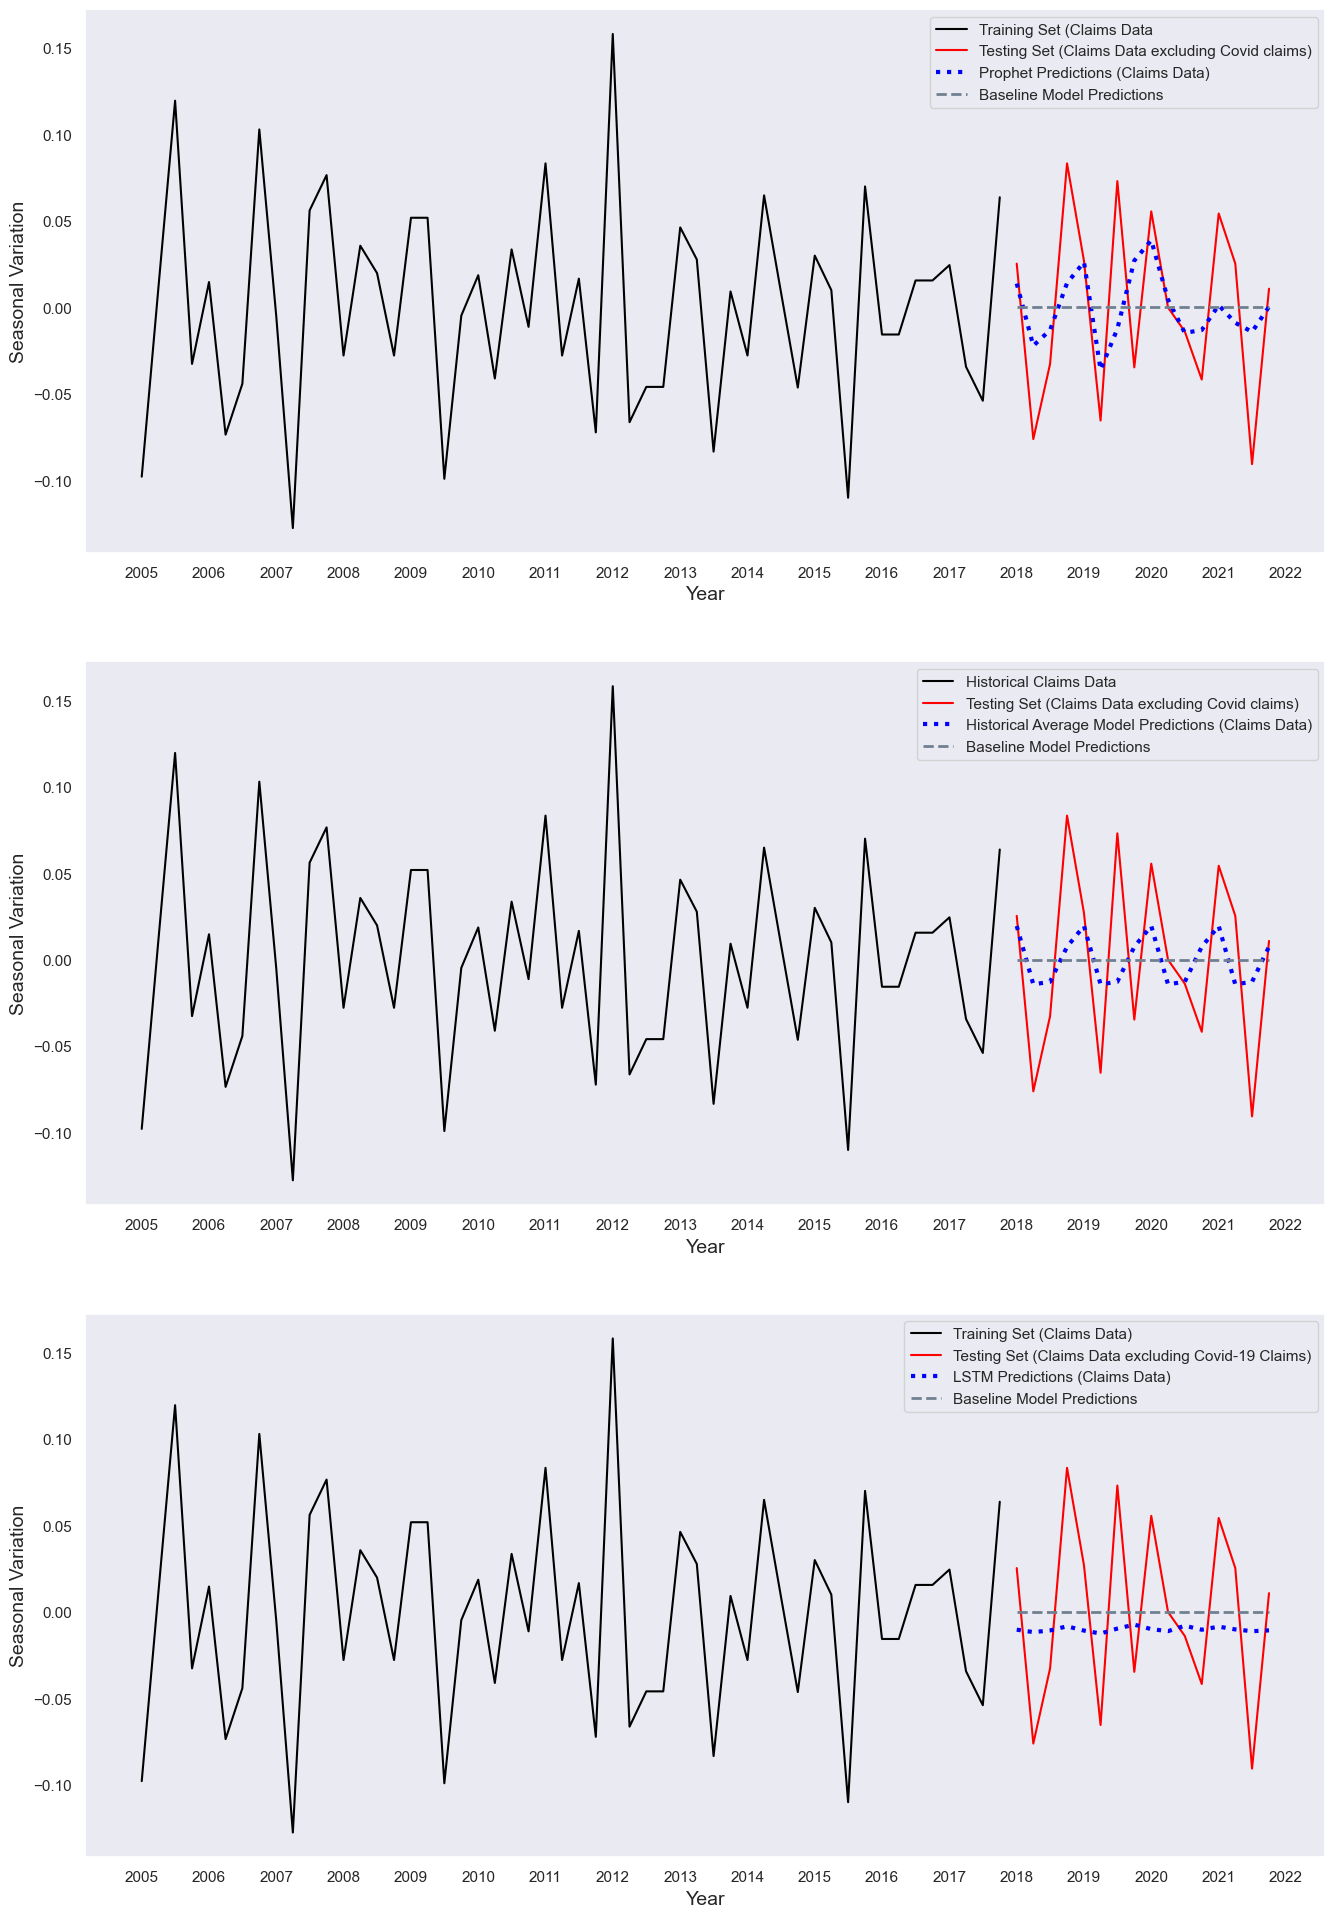

In [64]:
df_top_4y = pd.read_csv('Death Claim Seasonality Predictions - Prophet (Claims Data) 4 Year Test Period.csv')
df_top_4y.index = BL_4y.index
df_bottom_4y = pd.read_csv('Death Claim Seasonality Predictions - LSTM (Claims Data) 4 Year Testing Period.csv')
df_bottom_4y.index = BL_4y.index

fig, axs = plt.subplots(3, sharex=False,sharey=True, figsize=(16,24), gridspec_kw={'height_ratios': [1,1,1]})
axs[0].plot(training_data1_4y, color = "black", label = 'Training Set (Claims Data')
#axs[0].plot(testing_data4y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[0].plot(testing_data4y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[0].plot(df_top_4y, color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Prophet Predictions (Claims Data)')
axs[0].plot(BL_4y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[0].set_ylabel('Seasonal Variation',fontsize = 14)
axs[0].set_xlabel('Year',fontsize = 14)
axs[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].legend()
axs[0].grid(False)
axs[1].plot(training_data1_4y, color = "black", label = 'Historical Claims Data')
#axs[1].plot(testing_data4y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[1].plot(testing_data4y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[1].set_ylabel('Seasonal Variation',fontsize = 14)
axs[1].set_xlabel('Year',fontsize = 14)
axs[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1].plot(pd.DataFrame(predictions4y.iloc[:,1]), color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Historical Average Model Predictions (Claims Data)')
axs[1].plot(BL_4y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[1].legend()
axs[1].grid(False)
axs[2].plot(training_data1_4y, color = "black", label = 'Training Set (Claims Data)')
#axs[2].plot(testing_data4y, color = "pink", label = 'Testing Set (Claims Data including Covid-19 claims)')
axs[2].plot(testing_data4y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid-19 Claims)')
axs[2].plot(df_bottom_4y, color='Blue', linestyle = 'dotted', linewidth = 3.0,label = 'LSTM Predictions (Claims Data)')
axs[2].plot(BL_4y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[2].set_ylabel('Seasonal Variation',fontsize = 14)
axs[2].set_xlabel('Year',fontsize = 14)
axs[2].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[2].legend()
axs[2].grid(False)

#### 14 Year Training Period/3 Year Testing Period

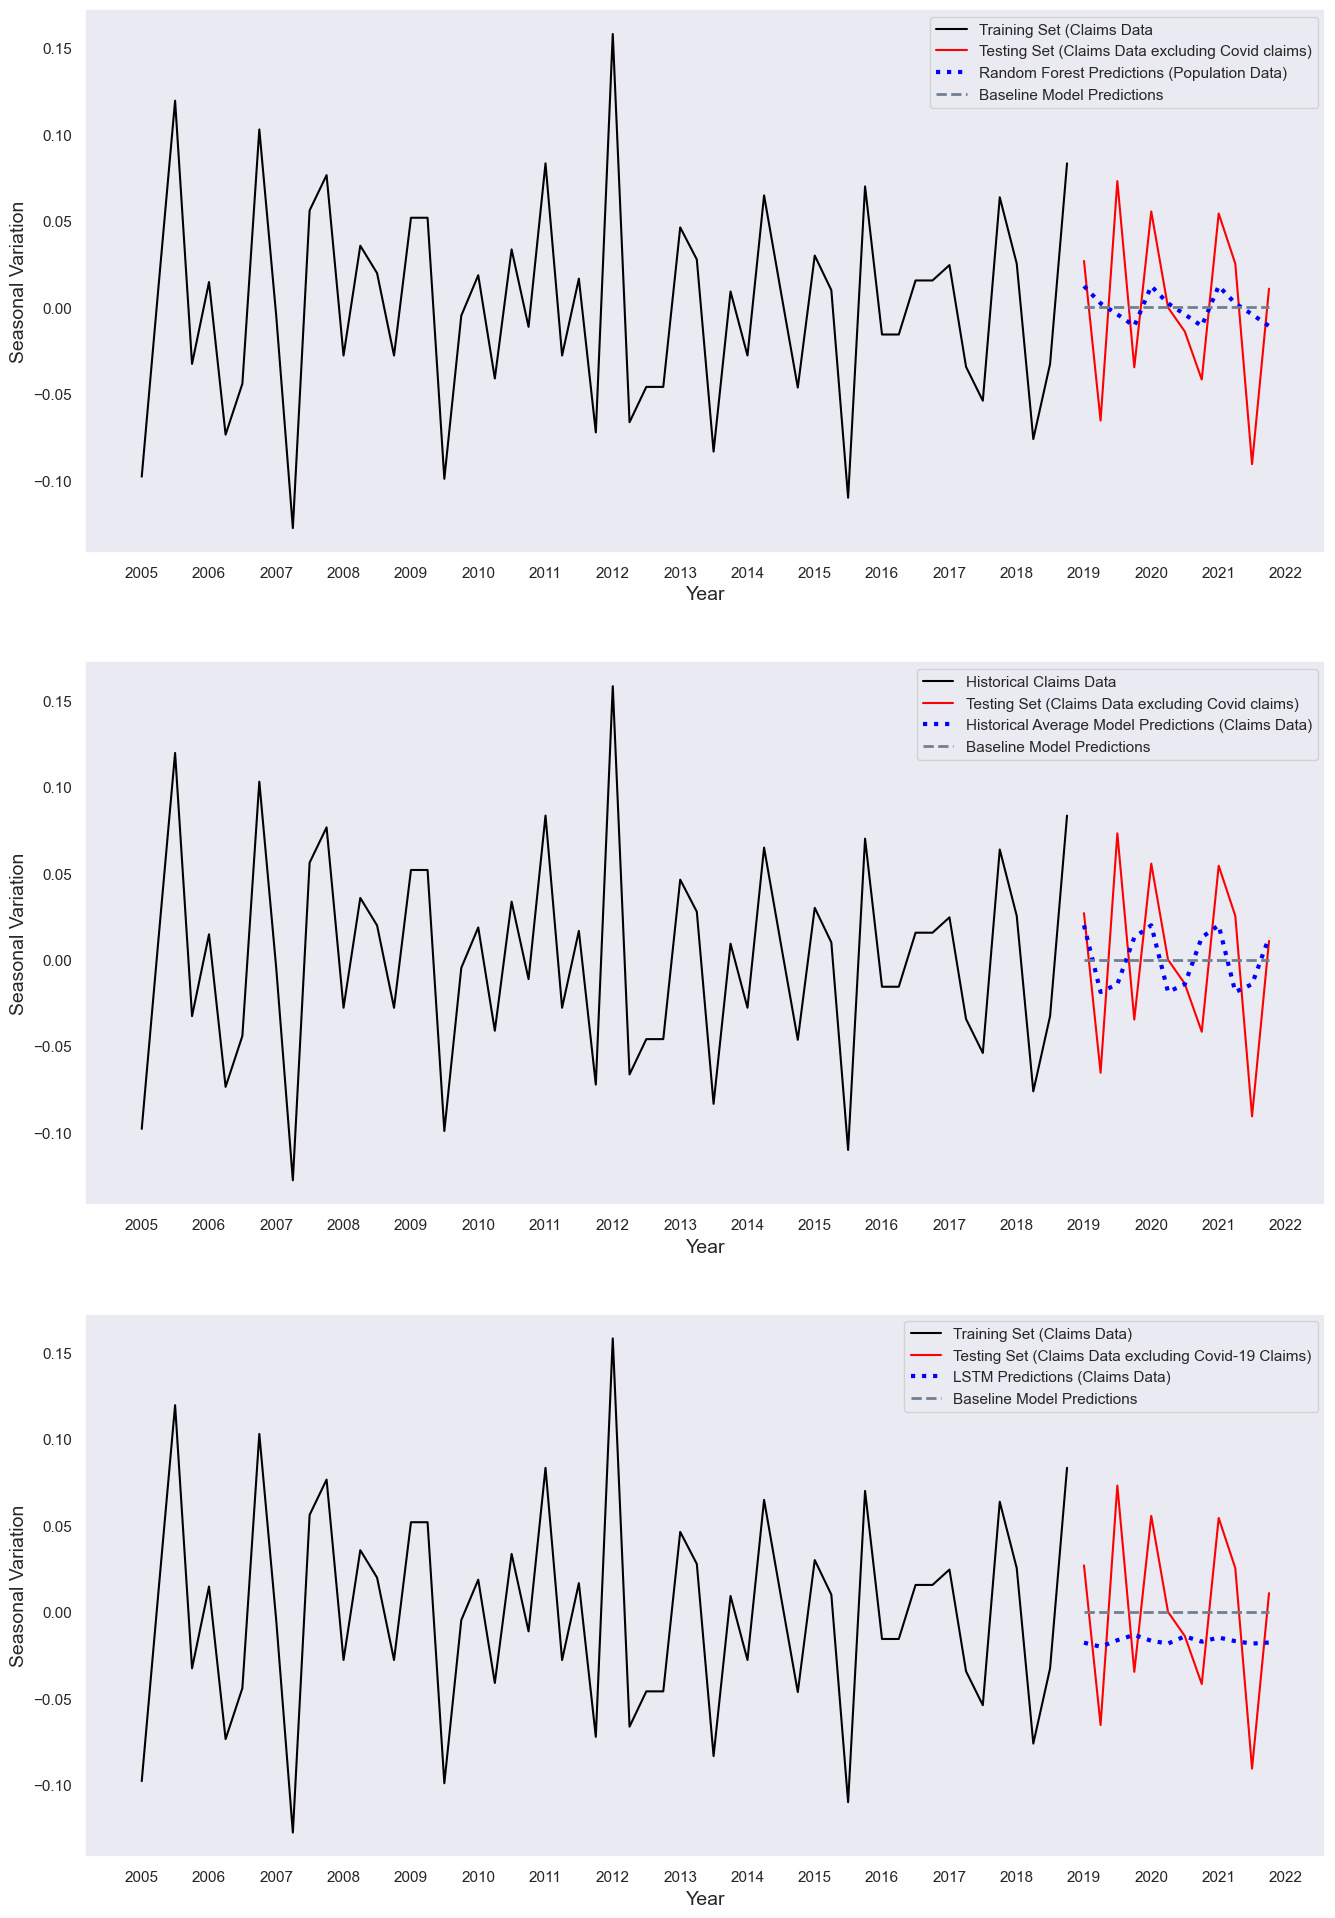

In [65]:
df_top_3y = pd.read_csv('Death Claim Seasonality Predictions - Random Forest (Population Data) 3 Year Test Period.csv')
df_top_3y.index = BL_3y.index
df_bottom_3y = pd.read_csv('Death Claim Seasonality Predictions - LSTM (Claims Data) 3 Year Testing Period.csv')
df_bottom_3y.index = BL_3y.index

fig, axs = plt.subplots(3, sharex=False,sharey=True, figsize=(16,24), gridspec_kw={'height_ratios': [1,1,1]})
axs[0].plot(training_data1_3y, color = "black", label = 'Training Set (Claims Data')
#axs[0].plot(testing_data3y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[0].plot(testing_data3y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[0].plot(df_top_3y, color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Random Forest Predictions (Population Data)')
axs[0].plot(BL_3y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[0].set_ylabel('Seasonal Variation',fontsize = 14)
axs[0].set_xlabel('Year',fontsize = 14)
axs[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].legend()
axs[0].grid(False)
axs[1].plot(training_data1_3y, color = "black", label = 'Historical Claims Data')
#axs[1].plot(testing_data3y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[1].plot(testing_data3y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[1].plot(pd.DataFrame(predictions3y.iloc[:,1]), color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Historical Average Model Predictions (Claims Data)')
axs[1].plot(BL_3y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[1].set_ylabel('Seasonal Variation',fontsize = 14)
axs[1].set_xlabel('Year',fontsize = 14)
axs[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1].legend()
axs[1].grid(False)
axs[2].plot(training_data1_3y, color = "black", label = 'Training Set (Claims Data)')
#axs[2].plot(testing_data3y, color = "pink", label = 'Testing Set (Claims Data including Covid-19 claims)')
axs[2].plot(testing_data3y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid-19 Claims)')
axs[2].plot(df_bottom_3y, color='Blue', linestyle = 'dotted', linewidth = 3.0,label = 'LSTM Predictions (Claims Data)')
axs[2].plot(BL_3y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[2].set_ylabel('Seasonal Variation',fontsize = 14)
axs[2].set_xlabel('Year',fontsize = 14)
axs[2].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[2].legend()
axs[2].grid(False)


#### 15 Year Training Period/2 Year Testing Period

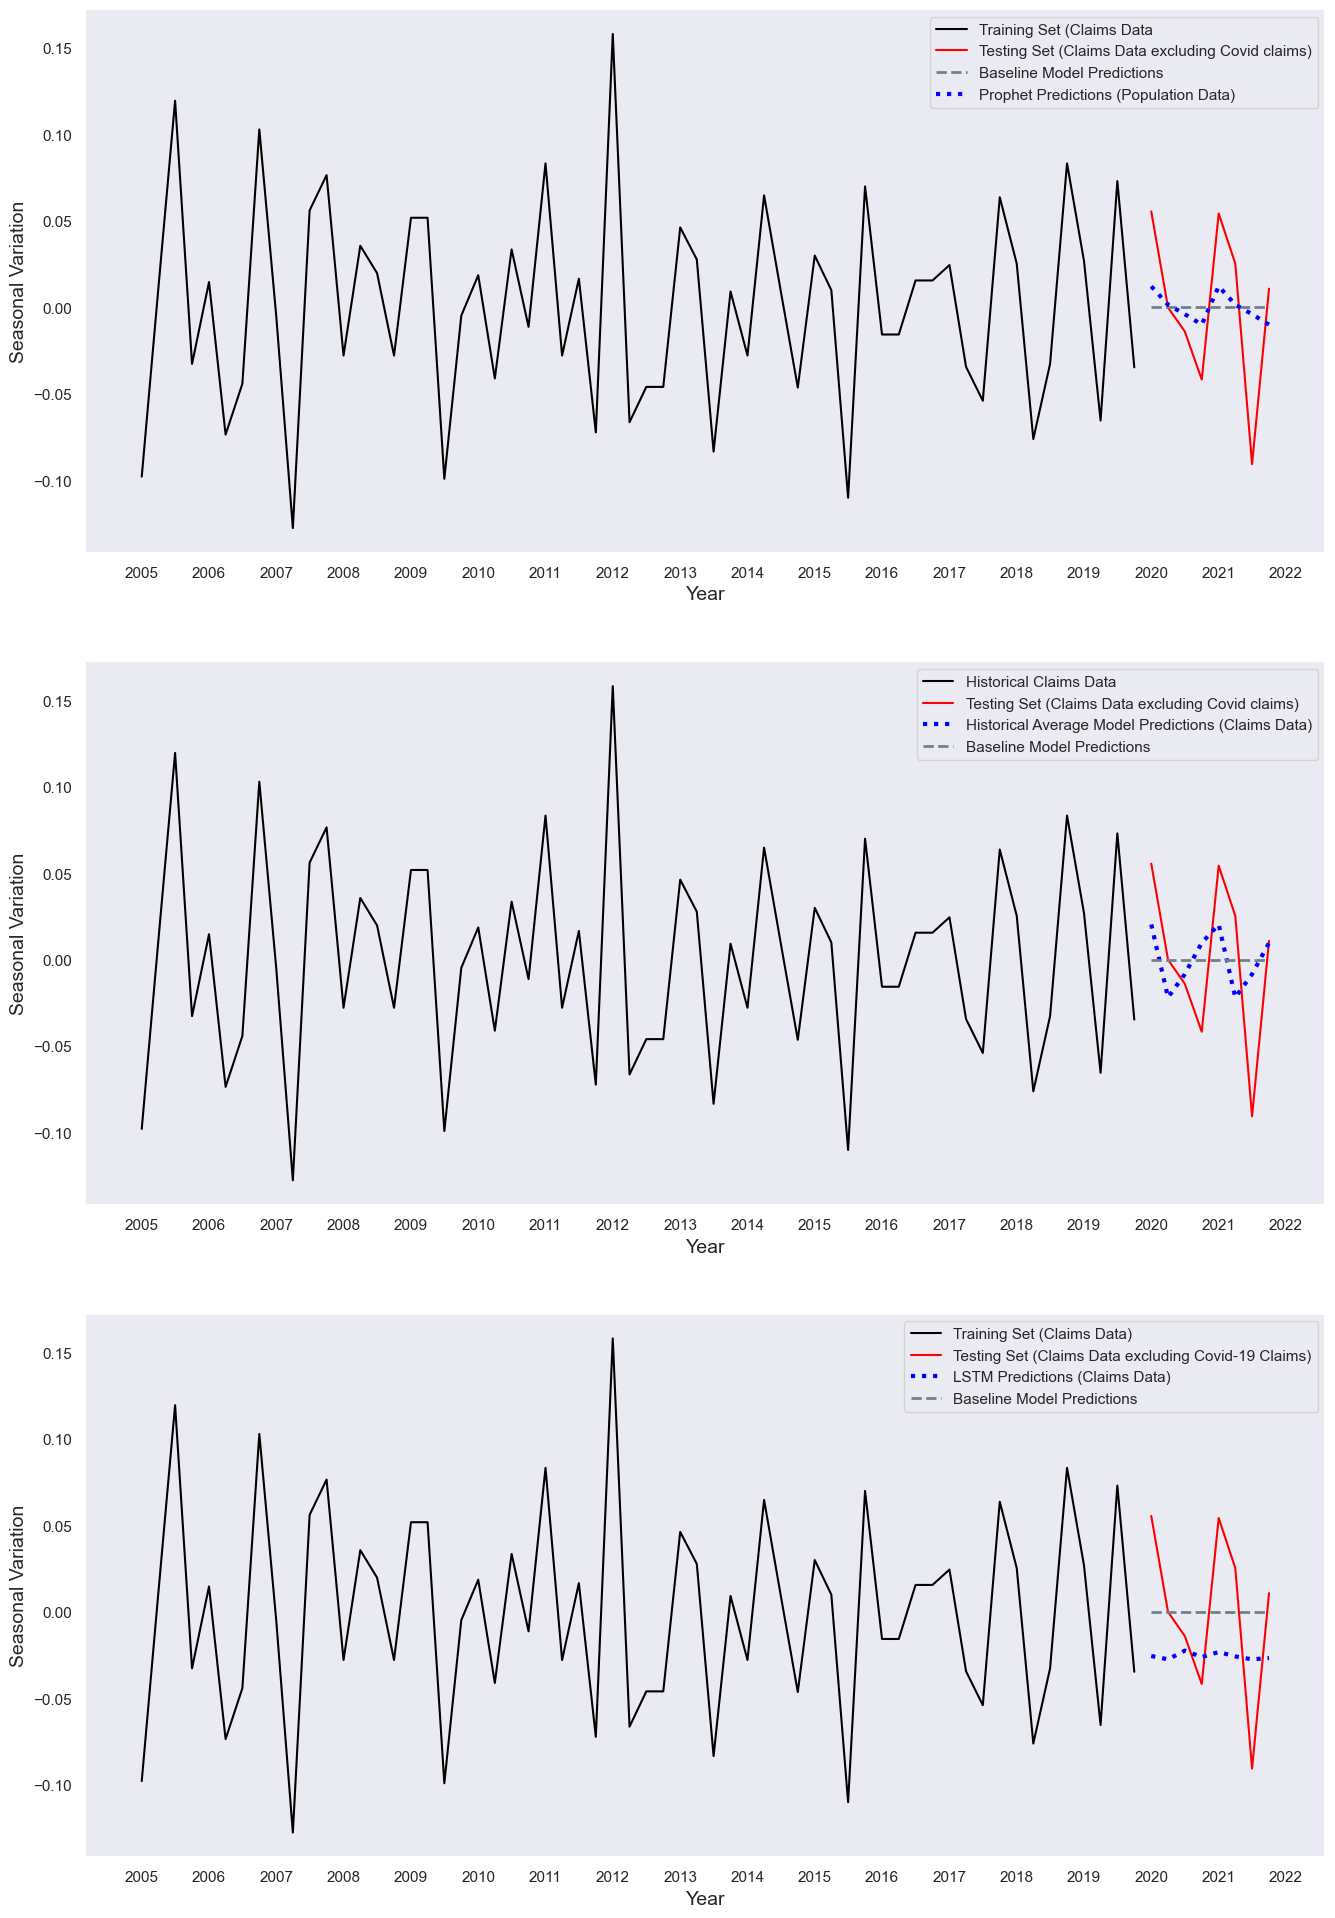

In [66]:
df_top_2y = pd.read_csv('Death Claim Seasonality Predictions - Random Forest (Population Data) 2 Year Test Period.csv')
df_top_2y.index = BL_2y.index
df_bottom_2y = pd.read_csv('Death Claim Seasonality Predictions - LSTM (Claims Data) 2 Year Testing Period.csv')
df_bottom_2y.index = BL_2y.index
fig, axs = plt.subplots(3, sharex=False,sharey=True, figsize=(16,24), gridspec_kw={'height_ratios': [1,1,1]})

axs[0].plot(training_data1_2y, color = "black", label = 'Training Set (Claims Data')
#axs[0].plot(testing_data2y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[0].plot(testing_data2y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[0].plot(BL_2y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[0].plot(df_top_2y, color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Prophet Predictions (Population Data)')
axs[0].set_ylabel('Seasonal Variation',fontsize = 14)
axs[0].set_xlabel('Year',fontsize = 14)
axs[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].legend()
axs[0].grid(False)
axs[1].plot(training_data1_2y, color = "black", label = 'Historical Claims Data')
#axs[1].plot(testing_data2y, color = "pink", label = 'Testing Set (Claims Data including Covid claims)')
axs[1].plot(testing_data2y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid claims)')
axs[1].plot(pd.DataFrame(predictions2y.iloc[:,1]), color='Blue', linestyle = 'dotted', linewidth = 3.0, label = 'Historical Average Model Predictions (Claims Data)')
axs[1].plot(BL_2y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[1].set_ylabel('Seasonal Variation',fontsize = 14)
axs[1].set_xlabel('Year',fontsize = 14)
axs[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1].legend()
axs[1].grid(False)
axs[2].plot(training_data1_2y, color = "black", label = 'Training Set (Claims Data)')
#axs[2].plot(testing_data2y, color = "pink", label = 'Testing Set (Claims Data including Covid-19 claims)')
axs[2].plot(testing_data2y_excovid, color = "red", label = 'Testing Set (Claims Data excluding Covid-19 Claims)')
axs[2].plot(df_bottom_2y, color='Blue', linestyle = 'dotted', linewidth = 3.0,label = 'LSTM Predictions (Claims Data)')
axs[2].plot(BL_2y, color='slategrey', linestyle = 'dashed', linewidth = 2.0, label = 'Baseline Model Predictions')
axs[2].set_ylabel('Seasonal Variation',fontsize = 14)
axs[2].set_xlabel('Year',fontsize = 14)
axs[2].xaxis.set_major_locator(mdates.YearLocator(base=1))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[2].legend()
axs[2].grid(False)